# let's see the results if we run 100x with only 1 landmark!

In [1]:
import cv2, os 
import numpy as np 
import warnings
warnings.filterwarnings('ignore')

In [2]:
import mediapipe as mp 
from PIL import Image as im 
import mediapipe as mp

def hand_locations(frame, min_detection_confidence = 0.5, min_tracking_confidence = 0.5): 
    """Only give the 0th landmark"""

    hands = mp.solutions.hands.Hands(min_detection_confidence=min_detection_confidence, min_tracking_confidence=min_tracking_confidence)  
    results = hands.process(frame.astype('uint8'))
    X_locations = [0] * 2
    Y_locations = [0] * 2
    Z_locations = [0] * 2
    if results.multi_hand_landmarks:
        for hand, hand_landmark in enumerate(results.multi_hand_landmarks):
            for i in range(0, 21):
                landmark = hand_landmark.landmark[i]
                X_locations[hand] = landmark.x
                Y_locations[hand] = landmark.y
                Z_locations[hand] = landmark.z
                break # take only the first landmark
            
    hands.close()
    return np.concatenate([X_locations, Y_locations, Z_locations]) 

In [3]:
#https://stackoverflow.com/questions/41908379/keras-plot-training-validation-and-test-set-accuracy
import matplotlib.pyplot as plt 
def plot(history, show_pr = False, num = None): 
    
    if num: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision_{num}'], label = "train_precision")
            plt.plot(history.history[f'val_precision_{num}'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall_{num}'], label = "train_recall")
            plt.plot(history.history[f'val_recall_{num}'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    else: 
        plt.plot(history.history['accuracy'], label = "train_acc")
        plt.plot(history.history['val_accuracy'], label = "val_acc")
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        plt.plot(history.history['loss'], label = "train_loss")
        plt.plot(history.history['val_loss'], label = "val_loss")
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend()
        plt.show()

        if show_pr: 
            plt.plot(history.history[f'precision'], label = "train_precision")
            plt.plot(history.history[f'val_precision'], label = "val_precision")
            plt.title('model precision')
            plt.ylabel('precision')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()

            plt.plot(history.history[f'recall'], label = "train_recall")
            plt.plot(history.history[f'val_recall'], label = "val_recall")
            plt.title('model recall')
            plt.ylabel('recall')
            plt.xlabel('epoch')
            plt.legend()
            plt.show()
    # let's see whether it can detect me not doing anything 

# we can create a padding function in order to pad 
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = np.array(locations).tolist() 
    empty_row = np.zeros((1, 126))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)
    
def predict_on_video(model, path): 
    LOCATIONS = []
    cap = cv2.VideoCapture(path)
    while cap.isOpened():
        _, frame = cap.read()
        if not _: break 

        LOCATIONS.append(hand_locations(frame))
    LOCATIONS = pad(np.array([LOCATIONS]),maxlen=90)
    return model.predict(LOCATIONS)


In [4]:
import random, cv2
import mediapipe as mp
import tensorflow as tf 
from warnings import filterwarnings
filterwarnings("ignore") 
tf.config.run_functions_eagerly(True)

def _shift(X):
        
        X = tf.Variable(X, dtype = tf.float32)
        
        X_locations = X[:, :2] 
        Y_locations = X[:, 2:4] 
        Z_locations = X[:, 4:6]
        
        mask = tf.not_equal(Y_locations, 0) 
        nonzero_Y_locations = tf.boolean_mask(Y_locations, mask) # contains all nonzero elements of Y_locations 
    
        maximum = tf.math.reduce_max(nonzero_Y_locations)
        minimum = tf.math.reduce_min(nonzero_Y_locations)

        can_move_up = 1 - maximum 
        can_move_down = minimum 
        mask = tf.cast(mask, tf.float32)
    
        if tf.random.uniform((1,)) > 0.5: 
            move_up = tf.random.uniform((1,), 0, can_move_up)
            X[:, 2:4].assign(X[:, 2:4] + mask * tf.ones_like(X[:, 2:4]) * move_up)
        else: 

            move_down = tf.random.uniform((1,), 0, can_move_down)
            X[:, 2:4].assign(X[:, 2:4] - mask * tf.ones_like(X[:, 2:4]) * move_down)

        mask = tf.not_equal(X_locations, 0) 
        nonzero_X_locations = tf.boolean_mask(X_locations, mask) 

        maximum = tf.math.reduce_max(nonzero_X_locations)
        minimum = tf.math.reduce_min(nonzero_X_locations)
            
        can_move_right = 1- maximum
        can_move_left = minimum 
        mask = tf.cast(mask, tf.float32)

        if tf.random.uniform((1,)) > 0.5: 
            #print("right")
            # move right
            move_right = tf.random.uniform((1,), 0, can_move_right)
            X[:, :2].assign(X[:, :2] + mask * tf.ones_like(X[:, :2]) * move_right)

        else: 
            # move left 
            move_left = tf.random.uniform((1,), 0, can_move_left)
            X[:, :2].assign(X[:, :2] - mask * tf.ones_like(X[:, :2]) * move_left)

        mask = tf.not_equal(Z_locations, 0) 
        nonzero_Z_locations = tf.boolean_mask(Z_locations, mask)

        maximum = tf.math.reduce_max(nonzero_Z_locations)
        minimum = tf.math.reduce_min(nonzero_Z_locations)
        mask = tf.cast(mask, tf.float32)

        can_move_far = 1 - maximum 
        can_move_close = minimum 

        if tf.random.uniform((1,)) > 0.5: 
            # move right
            move_far = tf.random.uniform((1,), 0, can_move_far)
            X[:, 4:6].assign(X[:, 4:6] + mask * tf.ones_like(X[:, 4:6]) * move_far)
        else: 
            # move left 
            move_close = tf.random.uniform((1,), 0, can_move_close)
            X[:, 4:6].assign(X[:, 4:6] - mask * tf.ones_like(X[:, 4:6]) * move_close)

        return X

class Augmenter(tf.keras.layers.Layer): 
    def __init__(self, rotation_range = None, **kwargs): 
        super().__init__(kwargs)
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180) + X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) - X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'vocab_size': 0,
            'num_layers': 1,
            'units': 0,
            'd_model': 1,
            'num_heads': 1,
            'dropout': 0,
        })
        return config
    
    def call(self, X, training = True):
        if training: 
            X =  tf.map_fn(_shift, X)
            if self.rotation_range: 
                X = tf.map_fn(self._rotate, X)
            return X
        else: 
            return X 

class TTAugmenter(tf.keras.layers.Layer): 
    """apply augmentation during test-time too"""
    def __init__(self, rotation_range = None, **kwargs): 
        super().__init__(**kwargs)
        self.trainable = False 
        self._trainable_weights = [] 
        self._non_trainable_weights = []
        self.rotation_range = rotation_range 
    
    def _rotate(self, X):  
        """
        new_x = X * np.cos(theta * np.pi/180) + y * np.sin(theta * np.pi/180)
        new_y = -X * np.sin(theta* np.pi/180) + y * np.cos(theta * np.pi/180)
        """
        X = tf.Variable(X, dtype = tf.float32)

        pi = 3.1415
        rotate_by = tf.random.uniform((1,), -self.rotation_range, self.rotation_range)
        
        X[:, :12].assign(X[:, :12] * tf.math.cos(rotate_by * pi/180)  - X[:, 12:24] * tf.math.sin(rotate_by * pi/180))
        X[:, 12:24].assign(X[:, 12:24] * tf.math.cos(rotate_by * pi/180) + X[:, :12] * tf.math.sin(rotate_by * pi/180))
        return X 

    def call(self, X):
        X =  tf.map_fn(_shift, X)
        if self.rotation_range: 
            X = tf.map_fn(self._rotate, X)
        return X 

class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('val_accuracy') > 0.9):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(0.9*100))   
            self.model.stop_training = True  

In [5]:
def pad(locations, maxlen = 90, padding = "post", truncating = "post"): 
    new_locations = locations.tolist() 
    empty_row = np.zeros((1, 6))
    for i, video in tqdm(enumerate(new_locations)): 
        if len(video) < maxlen:  
            for new_row in range(maxlen - len(video)): 
                if padding == "post": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([new_locations[i], empty_row])
                if padding == "pre": 
                    new_locations[i] = np.array(new_locations[i])
                    new_locations[i] = np.concatenate([empty_row, new_locations[i]])

        if len(video) > maxlen: 
            if truncating == "post": 
                new_locations[i] = new_locations[i][:maxlen]
            elif truncating == "pre": 
                new_locations[i] = new_locations[i][len(video) - maxlen : ]
    return np.array(new_locations)

In [6]:
from scipy import interpolate
def adjust(frame_matrix): 
    assert len(frame_matrix.shape) == 2
    rows, columns = frame_matrix.shape
    for column in range(columns): 
        loc_dimension = frame_matrix[column]
        x = np.arange(0, rows, 1)
        idx = np.nonzero(loc_dimension)
        if len(idx) == 1: 
            continue 
        interp_func = interpolate.interp1d(x[idx], loc_dimension[idx], kind='cubic', fill_value = "extrapolate")
        frame_matrix[:, column] = interp_func(x) 
    return frame_matrix

def interp_X(X): 
    temp_X = np.concatenate([X_i for X_i in X])
    temp_X =  np.array([adjust(temp_X_i) for temp_X_i in temp_X])
    print(temp_X.shape)
    return temp_X.reshape(X.shape)

In [7]:
def plot_roc_auroc(base_fpr, TPRs, FPRs, aurocs): 
    

    for i, (tpr, fpr) in enumerate(zip(TPRs, FPRs)): 
        plt.plot(base_fpr, tpr, label = f"fold {i + 1}")

    mean_tpr = np.mean(TPRs, axis=0)
    plt.plot(base_fpr, mean_tpr, label = "average of folds")
    
    std_tpr = np.std(TPRs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3,
                 label=r'$\pm$ 1 std. dev.')

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve across folds')
    plt.legend(loc="lower right")
    plt.show()

    # plot the auroc curves 
    mean_auroc = sum(aurocs) / len(aurocs)
    descriptions = [f"fold {i + 1}" for i in range(len(aurocs))] + ["average fold"]
    aurocs.append(mean_auroc)
    plt.bar(descriptions, aurocs, color = "green")
    plt.xlabel("Fold")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across folds")
    plt.show() 

    return mean_tpr, mean_auroc

def plot_meta_roc_auroc(average_aurocs, average_tprs, base_fpr): 
    meta_avg_tpr = np.mean(average_tprs, axis = 0) 
    meta_avg_auroc = sum(average_aurocs) / len(average_aurocs)
    
    for i, average_tpr in enumerate(average_tprs): 
        plt.plot(base_fpr, average_tpr, label = f"run {i + 1}")
    
    plt.plot(base_fpr, meta_avg_tpr, label = "average of runs")
    
    std_tpr = np.std(average_tprs, axis=0)
    tprs_upper = np.minimum(meta_avg_tpr + std_tpr, 1)
    tprs_lower = np.maximum(meta_avg_tpr - std_tpr, 0)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='grey', alpha=.3, label=r'$\pm$ 1 std. dev.')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--', label = "chance")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve across Runs (No Aug)')
    plt.legend(loc="lower right")
    plt.show()

    descriptions = [f"{i + 1}" for i in range(len(average_aurocs))] + ["avg"]
    average_aurocs.append(meta_avg_auroc)
    plt.bar(descriptions, average_aurocs, color = "green")
    plt.xlabel("Run Number")
    plt.ylabel("Area Under Curve")
    plt.title("Area Under ROC Curve across Runs (No Aug)")
    plt.show()

In [8]:
from glob import glob
from tqdm import tqdm 
from scipy import interp
import tensorflow_addons as tfa
from sklearn.metrics import roc_curve, roc_auc_score
AVERAGE_TPRS, AVERAGE_AUROCS = [], []
META_RESULT_MATRIX = [] 
def cross_validate(make_model, epochs = 50, callbacks=[]):
    """adds the training & validation accuracy, precision, recall, and F1 for each of the folds to a meta matrix"""
    model = make_model()

    base_fpr = np.linspace(0, 1, 101)
    FPRS, TPRS, AUROCS = [], [], []
    for i in range(5): 
        # for each fold change up the dataset 
        model = make_model()

        ARMFLAPPING_TRAINING_FRAMES = np.concatenate([fold for j, fold in enumerate(ARMFLAPPING_FRAMES_SPLIT) if j != i])
        CONTROL_TRAINING_FRAMES = np.concatenate([fold for j, fold in enumerate(CONTROL_FRAMES_SPLIT) if j != i])

        ARMFLAPPING_VALIDATION_FRAMES = ARMFLAPPING_FRAMES_SPLIT[i]
        CONTROL_VALIDATION_FRAMES = CONTROL_FRAMES_SPLIT[i]

        print(ARMFLAPPING_TRAINING_FRAMES.shape, CONTROL_TRAINING_FRAMES.shape)
        print(ARMFLAPPING_VALIDATION_FRAMES.shape, CONTROL_VALIDATION_FRAMES.shape)
        
        X_test = np.concatenate([ARMFLAPPING_VALIDATION_FRAMES, CONTROL_VALIDATION_FRAMES])
        X_train = np.concatenate([ARMFLAPPING_TRAINING_FRAMES, CONTROL_TRAINING_FRAMES])
        
        y_train = np.concatenate([np.ones(len(ARMFLAPPING_TRAINING_FRAMES)), np.zeros(len(CONTROL_TRAINING_FRAMES))])
        y_test = np.concatenate([np.ones(len(ARMFLAPPING_VALIDATION_FRAMES)), np.zeros(len(CONTROL_VALIDATION_FRAMES))])

        # shuffle it to avoid 0e+00 error 
        N = np.random.permutation(X_train.shape[0])
        X_train = X_train[N]
        y_train = y_train[N]

        N= np.random.permutation(X_test.shape[0])
        X_test = X_test[N]
        y_test = y_test[N]

        try:
            os.remove("best.h5") 
        except Exception as e: 
            pass 
        
        # train 
        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = epochs, callbacks = callbacks)
        
        try: 
            model.load_weights("best.h5")
        except Exception as e: 
            pass 

        # evaluate again 
        model.evaluate(X_test, y_test)
        
        # plot accuracy and loss 
        plot(history)

        # get this information  
        y_pred = model.predict(X_test).flatten()
        fpr, tpr, _ = roc_curve(y_test, y_pred) 
        FPRS.append(fpr)
        tpr = interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0 
        TPRS.append(tpr)
        AUROCS.append(roc_auc_score(y_test, y_pred))


        # accuracy: 0.7625 - precision: 0.7442 - recall: 0.8000 - val_loss: 0.6086 - val_accuracy: 0.7500 - val_precision: 0.6923 - val_recall: 0

        training_accuracy = history.history['accuracy'][-1]
        validation_accuracy = history.history['val_accuracy'][-1]
        training_precision = history.history['precision'][-1]
        validation_precision = history.history['val_precision'][-1]
        training_recall = history.history['recall'][-1]
        validation_recall = history.history['val_recall'][-1]
        training_f1 = 2 * training_precision * training_recall / (training_precision + training_recall)
        validation_f1 = 2 * validation_precision * validation_recall / (validation_precision + validation_recall)

        # add to meta matrix
        META_RESULT_MATRIX.append([training_accuracy, training_precision, training_recall, training_f1, validation_accuracy, validation_precision, validation_recall, validation_f1])

        # evaluate on our own custom videos
        for file in glob("*.mov"):
            print(f"prediction for video {file} is {predict_on_video(model, file)}")

    mean_tpr, mean_auroc = plot_roc_auroc(base_fpr, TPRS, FPRS, AUROCS) 
    AVERAGE_TPRS.append(mean_tpr) 
    AVERAGE_AUROCS.append(mean_auroc)

In [9]:
# don't shuffle  

import random 
def shuffle(X, y, seed = None):
    if seed == None:  
        seed = random.randrange(0, 100)
        print(f"using seed {seed}")
    np.random.seed(seed) 
    new_X = np.concatenate([X_i for X_i in X])
    new_y = np.concatenate([y_i for y_i in y])
    N = np.random.permutation(new_X.shape[0])
    new_X = new_X[N]
    new_y = new_y[N]
    new_X = new_X.reshape(5, 20, 90, 6)
    new_y = new_y.reshape(5, 20)
    return new_X, new_y


In [10]:
def f1(y_true, y_pred):
    y_pred = tf.round(y_pred)
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p+r+tf.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return tf.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = tf.math.reduce_sum(tf.cast(y_true*y_pred, 'float'), axis=0)
    tn = tf.math.reduce_sum(tf.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = tf.math.reduce_sum(tf.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = tf.math.reduce_sum(tf.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + tf.keras.backend.epsilon())
    r = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*p*r / (p+r+tf.keras.backend.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - tf.math.reduce_mean(f1)

In [11]:
def make_model(): 
    model = tf.keras.models.Sequential([
        #Augmenter(), 
        tf.keras.layers.LSTM(64, return_sequences=False, input_shape = (None, 6)), 
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(1, activation = 'sigmoid') 
    ]) 

    model.compile(loss = tf.keras.losses.BinaryCrossentropy(), optimizer = tf.keras.optimizers.Adam(learning_rate=0.01), metrics = ['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")])

    return model

In [12]:
import pickle, numpy as np
with open("one_point_folds_seeds", 'rb') as f: 
    information = pickle.load(f)

ARMFLAPPING_FRAMES, ARMFLAPPING_FILE_NAMES, CONTROL_FRAMES, CONTROL_FILE_NAMES = [np.concatenate(info) for info in information]

assert ARMFLAPPING_FILE_NAMES.shape == CONTROL_FILE_NAMES.shape
assert ARMFLAPPING_FRAMES.shape == CONTROL_FRAMES.shape

In [13]:
WRITE_DATA = False
if WRITE_DATA: 
    SEEDS = np.abs(np.array(np.random.randn(100) * 100, dtype = np.int32))
    FILES_FOR_FOLD = []
    for seed in SEEDS:
        np.random.seed(seed) # set seed 
        
        N = np.random.permutation(ARMFLAPPING_FRAMES.shape[0])
        ARMFLAPPING_FILE_NAMES = ARMFLAPPING_FILE_NAMES[N]
        CONTROL_FILE_NAMES = CONTROL_FILE_NAMES[N]

        armflapping_file_name_folds =  np.array_split(ARMFLAPPING_FILE_NAMES, 5)
        control_file_name_folds =  np.array_split(CONTROL_FILE_NAMES, 5)

        for i in range(5):
            # the ith fold is for validation, everything else is for whatever 

            armflapping_training_files = np.concatenate([fold for j, fold in enumerate(armflapping_file_name_folds) if j != i])
            control_training_files = np.concatenate([fold for j, fold in enumerate(control_file_name_folds) if j != i])

            armflapping_validation_files = armflapping_file_name_folds[i]
            control_validation_files = control_file_name_folds[i]

            FILES_FOR_FOLD.append({"train": np.concatenate([armflapping_training_files, control_training_files]).tolist(), "test": np.concatenate([armflapping_validation_files, control_validation_files]).tolist()})
    # save this and the seeds used in a pickle file 

    with open("file_names_folds.pkl", 'wb') as f: 
        pickle.dump((SEEDS.tolist(), FILES_FOR_FOLD), f)

In [14]:
if not WRITE_DATA: 
    with open("file_names_folds.pkl", 'rb') as f: 
        SEEDS, _ = pickle.load(f)

# okay so this is the same thing but for the one landmark approach

2021-11-11 16:09:10.345880: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)


2021-11-11 16:09:11.256876: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/75
3/3 [==============================] - 1s 220ms/step - loss: 0.6908 - accuracy: 0.4375 - precision: 0.4615 - recall: 0.7500 - val_loss: 0.6698 - val_accuracy: 0.5500 - val_precision: 0.5294 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 1s 186ms/step - loss: 0.7020 - accuracy: 0.4625 - precision: 0.4483 - recall: 0.3250 - val_loss: 0.6595 - val_accuracy: 0.5500 - val_precision: 0.5294 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 1s 195ms/step - loss: 0.6791 - accuracy: 0.5625 - precision: 0.5333 - recall: 1.0000 - val_loss: 0.6547 - val_accuracy: 0.5500 - val_precision: 0.5294 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 1s 194ms/step - loss: 0.6623 - accuracy: 0.6750 - precision: 0.6458 - recall: 0.7750 - val_loss: 0.6727 - val_accuracy: 0.7000 - val_precision: 1.0000 - val_recall: 0.4000
Epoch 5/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6639 - accuracy: 0.6250 - precision: 0

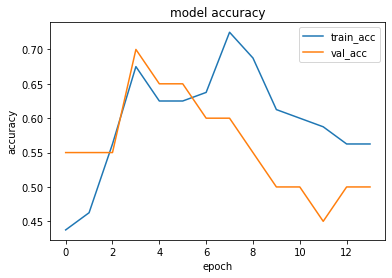

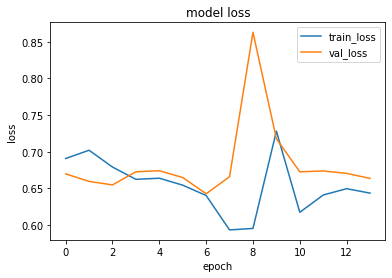

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
1it [00:00, 5949.37it/s]


prediction for video armflapping_1.mov is [[0.47446534]]


1it [00:00, 23831.27it/s]


prediction for video armflapping_3.mov is [[0.47215095]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_2.mov is [[0.48351312]]


1it [00:00, 19239.93it/s]


prediction for video control_1.mov is [[0.4652481]]


1it [00:00, 18893.26it/s]


prediction for video control_2.mov is [[0.46185046]]


1it [00:00, 20763.88it/s]


prediction for video control_3.mov is [[0.46232355]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6807 - accuracy: 0.6750 - precision: 0.6522 - recall: 0.7500 - val_loss: 0.6354 - val_accuracy: 0.6500 - val_precision: 0.7143 - val_recall: 0.5000
Epoch 2/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6847 - accuracy: 0.6875 - precision: 0.6471 - recall: 0.8250 - val_loss: 0.6429 - val_accuracy: 0.5500 - val_precision: 0.6000 - val_recall: 0.3000
Epoch 3/75
3/3 [==============================] - 1s 207ms/step - loss: 0.6537 - accuracy: 0.7000 - precision: 0.7222 - recall: 0.6500 - val_loss: 0.7327 - val_accuracy: 0.4000 - val_precision: 0.3750 - val_recall: 0.3000
Epoch 4/75
3/3 [==============================] - 0s 161ms/step - loss: 0.6410 - accuracy: 0.7000 - precision: 0.7222 - recall: 0.6500 - val_loss: 0.7505 - val_accuracy: 0.4500 - val_precision: 0.4444 - val_recall: 0.4000
Epoch 5/75


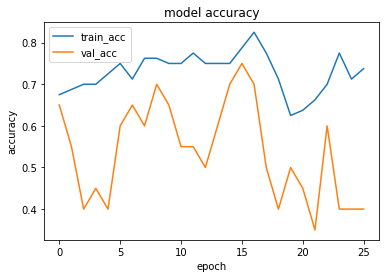

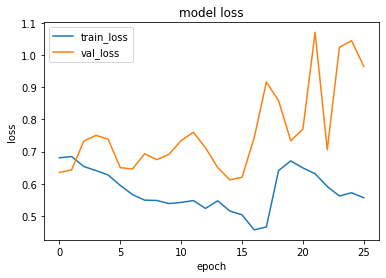

1it [00:00, 18157.16it/s]


prediction for video armflapping_1.mov is [[0.32653236]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_3.mov is [[0.6749356]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.65856266]]


1it [00:00, 17476.27it/s]


prediction for video control_1.mov is [[0.24304643]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.23140702]]


1it [00:00, 17848.10it/s]


prediction for video control_3.mov is [[0.22813666]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6954 - accuracy: 0.4625 - precision: 0.4634 - recall: 0.4750 - val_loss: 0.6609 - val_accuracy: 0.6000 - val_precision: 0.5556 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 197ms/step - loss: 0.6909 - accuracy: 0.5750 - precision: 0.5429 - recall: 0.9500 - val_loss: 0.6571 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6833 - accuracy: 0.5500 - precision: 0.6429 - recall: 0.2250 - val_loss: 0.6462 - val_accuracy: 0.8000 - val_precision: 1.0000 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6660 - accuracy: 0.6625 - precision: 0.6857 - recall: 0.6000 - val_loss: 0.6466 - val_accuracy: 0.8000 - val_precision: 1.0000 - val_recall: 0.6000
Epo

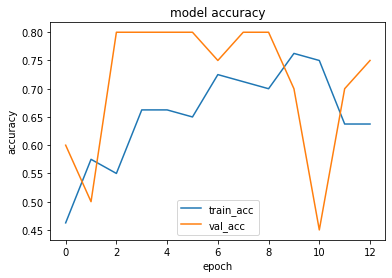

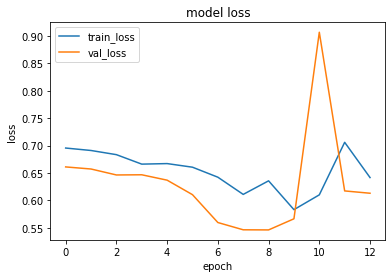

1it [00:00, 17189.77it/s]


prediction for video armflapping_1.mov is [[0.48904607]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.5032046]]


1it [00:00, 16644.06it/s]


prediction for video armflapping_2.mov is [[0.49367407]]


1it [00:00, 17549.39it/s]


prediction for video control_1.mov is [[0.48254392]]


1it [00:00, 17189.77it/s]


prediction for video control_2.mov is [[0.47935423]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.47972628]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6999 - accuracy: 0.4750 - precision: 0.4773 - recall: 0.5250 - val_loss: 0.6843 - val_accuracy: 0.5500 - val_precision: 0.5385 - val_recall: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6843 - accuracy: 0.5500 - precision: 0.5769 - recall: 0.3750 - val_loss: 0.6797 - val_accuracy: 0.4500 - val_precision: 0.4737 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6081 - accuracy: 0.6875 - precision: 0.6271 - recall: 0.9250 - val_loss: 0.7228 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6796 - accuracy: 0.5875 - precision: 0.5493 - recall: 0.9750 - val_loss: 0.8021 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 5/75


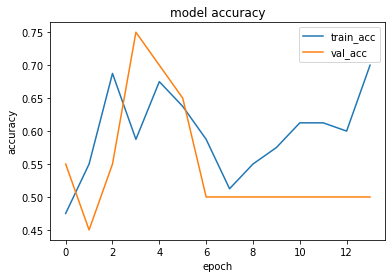

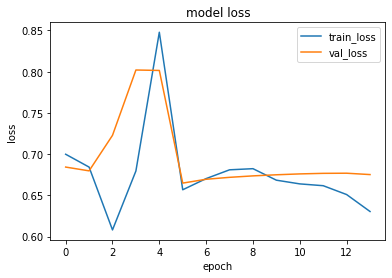

1it [00:00, 14315.03it/s]


prediction for video armflapping_1.mov is [[0.51196826]]


1it [00:00, 19239.93it/s]


prediction for video armflapping_3.mov is [[0.53465134]]


1it [00:00, 16448.25it/s]


prediction for video armflapping_2.mov is [[0.5360652]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.50615036]]


1it [00:00, 19239.93it/s]


prediction for video control_2.mov is [[0.50411004]]


1it [00:00, 14463.12it/s]


prediction for video control_3.mov is [[0.50348675]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 135ms/step - loss: 0.7062 - accuracy: 0.4500 - precision: 0.4677 - recall: 0.7250 - val_loss: 0.7088 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 121ms/step - loss: 0.8293 - accuracy: 0.5000 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.6953 - val_accuracy: 0.6000 - val_precision: 0.7500 - val_recall: 0.3000
Epoch 3/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6728 - accuracy: 0.5875 - precision: 0.5714 - recall: 0.7000 - val_loss: 0.6832 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6778 - accuracy: 0.5625 - precision: 0.5342 - recall: 0.9750 - val_loss: 0.6778 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.

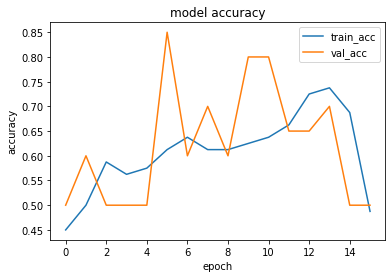

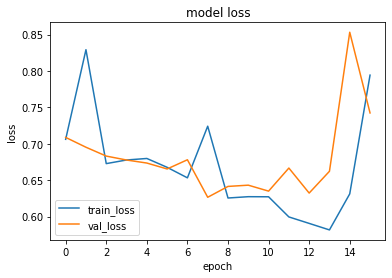

1it [00:00, 14513.16it/s]


prediction for video armflapping_1.mov is [[0.48808026]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.5093107]]


1it [00:00, 16194.22it/s]


prediction for video armflapping_2.mov is [[0.5158514]]


1it [00:00, 3236.35it/s]


prediction for video control_1.mov is [[0.47920448]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.4766081]]


1it [00:00, 15650.39it/s]


prediction for video control_3.mov is [[0.47610256]]


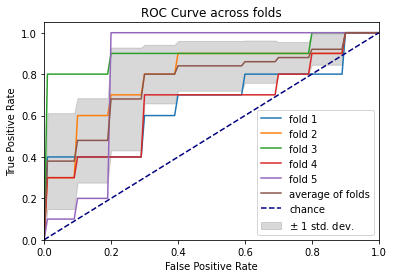

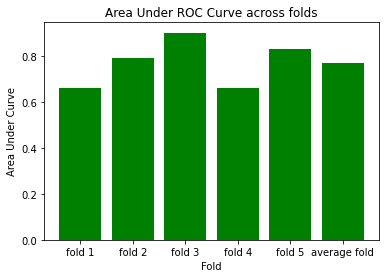

(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.7135 - accuracy: 0.4875 - precision: 0.4933 - recall: 0.9250 - val_loss: 0.7034 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6900 - accuracy: 0.5250 - precision: 1.0000 - recall: 0.0500 - val_loss: 0.6956 - val_accuracy: 0.6000 - val_precision: 0.7500 - val_recall: 0.3000
Epoch 3/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6557 - accuracy: 0.6375 - precision: 0.5932 - recall: 0.8750 - val_loss: 0.7024 - val_accuracy: 0.4500 - val_precision: 0.4706 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6128 - accuracy: 0.6250 - precision: 0.5735 - recall: 0.9750 - val_loss: 0.9260 - val_accuracy: 0.5500 - val_precision: 0.5455 - val_recall: 0.6000
Epoch 5/75
3/3 [==============================] - 0s 136

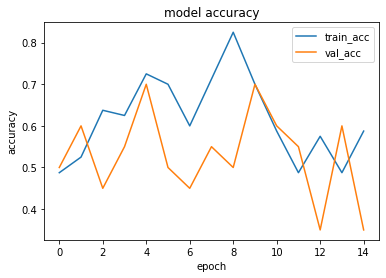

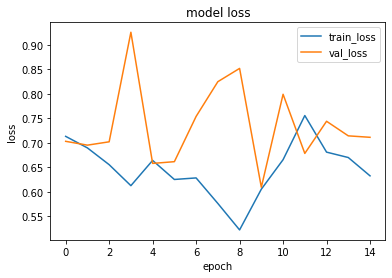

1it [00:00, 17772.47it/s]


prediction for video armflapping_1.mov is [[0.50211567]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.52185744]]


1it [00:00, 13530.01it/s]


prediction for video armflapping_2.mov is [[0.5382874]]


1it [00:00, 18893.26it/s]


prediction for video control_1.mov is [[0.48299462]]


1it [00:00, 14979.66it/s]


prediction for video control_2.mov is [[0.47401798]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.47175434]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 169ms/step - loss: 0.7039 - accuracy: 0.4750 - precision: 0.4828 - recall: 0.7000 - val_loss: 0.6683 - val_accuracy: 0.6500 - val_precision: 0.6000 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6869 - accuracy: 0.5250 - precision: 0.5139 - recall: 0.9250 - val_loss: 0.6309 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6683 - accuracy: 0.6625 - precision: 0.8421 - recall: 0.4000 - val_loss: 0.5934 - val_accuracy: 0.7500 - val_precision: 0.8571 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 1s 219ms/step - loss: 0.6540 - accuracy: 0.6500 - precision: 0.6875 - recall: 0.5500 - val_loss: 0.5205 - val_accuracy: 0.7500 - val_precision: 0.6923 - val_recall: 0.9000
Epoch 5/75


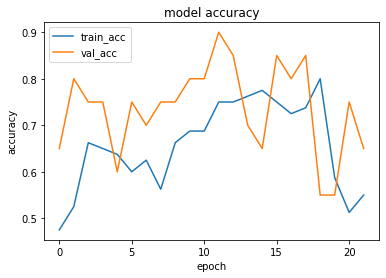

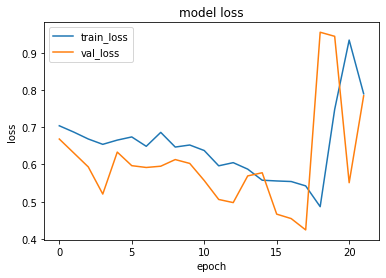

1it [00:00, 12520.31it/s]


prediction for video armflapping_1.mov is [[0.2283949]]


1it [00:00, 18477.11it/s]


prediction for video armflapping_3.mov is [[0.547032]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.5336484]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.21221411]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.20952609]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.21007472]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6824 - accuracy: 0.5625 - precision: 0.5806 - recall: 0.4500 - val_loss: 0.6455 - val_accuracy: 0.6000 - val_precision: 0.5556 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 157ms/step - loss: 0.7247 - accuracy: 0.5625 - precision: 0.5758 - recall: 0.4750 - val_loss: 0.6249 - val_accuracy: 0.8500 - val_precision: 0.8889 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6456 - accuracy: 0.7000 - precision: 0.7500 - recall: 0.6000 - val_loss: 0.6720 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6620 - accuracy: 0.6875 - precision: 0.6744 - recall: 0.7250 - val_loss: 0.6594 - val_accuracy: 0.6000 - val_precision: 0.5714 - val_recall: 0.8000
Epoch 5/75


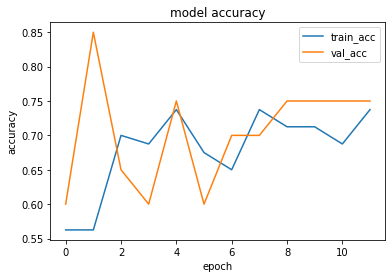

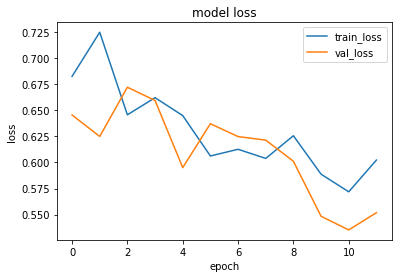

1it [00:00, 17260.51it/s]


prediction for video armflapping_1.mov is [[0.47213954]]


1it [00:00, 17476.27it/s]


prediction for video armflapping_3.mov is [[0.5369145]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_2.mov is [[0.6107663]]


1it [00:00, 11781.75it/s]


prediction for video control_1.mov is [[0.37775275]]


1it [00:00, 15592.21it/s]


prediction for video control_2.mov is [[0.34801906]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.3294742]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6991 - accuracy: 0.5250 - precision: 0.5139 - recall: 0.9250 - val_loss: 0.6722 - val_accuracy: 0.7500 - val_precision: 0.8571 - val_recall: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6697 - accuracy: 0.6000 - precision: 0.6818 - recall: 0.3750 - val_loss: 0.6848 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6497 - accuracy: 0.5750 - precision: 0.5441 - recall: 0.9250 - val_loss: 0.6623 - val_accuracy: 0.6000 - val_precision: 0.5833 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6779 - accuracy: 0.6000 - precision: 0.5667 - recall: 0.8500 - val_loss: 0.6378 - val_accuracy: 0.6500 - val_precision: 0.7143 - val_recall: 0.5000
Epoch 5/75
3

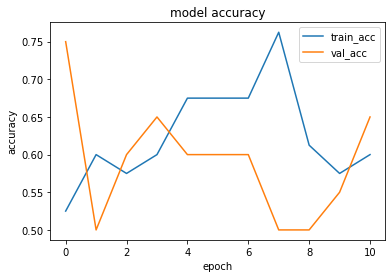

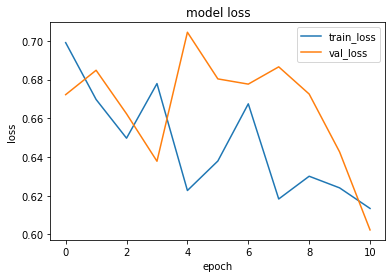

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.5305972]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.5846809]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_2.mov is [[0.56510496]]


1it [00:00, 15420.24it/s]


prediction for video control_1.mov is [[0.51959217]]


1it [00:00, 16131.94it/s]


prediction for video control_2.mov is [[0.5171395]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.51628864]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6954 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.3500 - val_loss: 0.6775 - val_accuracy: 0.6500 - val_precision: 0.8000 - val_recall: 0.4000
Epoch 2/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6528 - accuracy: 0.6250 - precision: 0.9167 - recall: 0.2750 - val_loss: 0.6410 - val_accuracy: 0.6000 - val_precision: 0.5625 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6345 - accuracy: 0.5625 - precision: 0.5342 - recall: 0.9750 - val_loss: 0.6685 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 180ms/step - loss: 0.6673 - accuracy: 0.5750 - precision: 0.5517 - recall: 0.8000 - val_loss: 0.6487 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.6000
Epoch 5/75


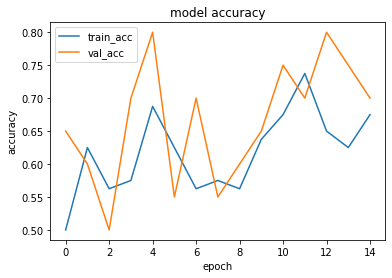

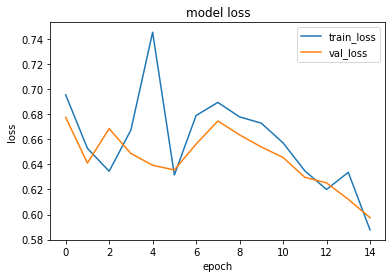

1it [00:00, 14463.12it/s]


prediction for video armflapping_1.mov is [[0.45223123]]


1it [00:00, 16194.22it/s]


prediction for video armflapping_3.mov is [[0.5282612]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_2.mov is [[0.58400476]]


1it [00:00, 12826.62it/s]


prediction for video control_1.mov is [[0.39810646]]


1it [00:00, 16644.06it/s]


prediction for video control_2.mov is [[0.3780053]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.3692475]]


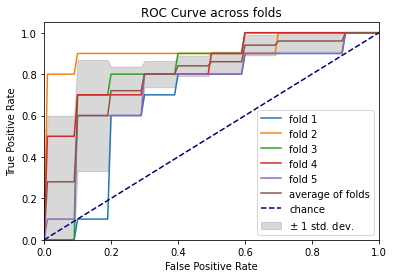

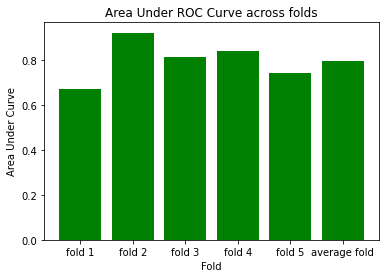

(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6857 - accuracy: 0.5250 - precision: 0.5278 - recall: 0.4750 - val_loss: 0.6904 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6792 - accuracy: 0.5875 - precision: 0.5507 - recall: 0.9500 - val_loss: 0.6204 - val_accuracy: 0.5500 - val_precision: 0.6667 - val_recall: 0.2000
Epoch 3/75
3/3 [==============================] - 0s 143ms/step - loss: 0.6427 - accuracy: 0.6750 - precision: 0.8889 - recall: 0.4000 - val_loss: 0.6547 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.2000
Epoch 4/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6508 - accuracy: 0.7000 - precision: 0.8077 - recall: 0.5250 - val_loss: 0.6835 - val_accuracy: 0.6000 - val_precision: 0.6250 - val_recall: 0.5000
Epoch 5/75
3/3 [==============================] - 0s 136ms/step 

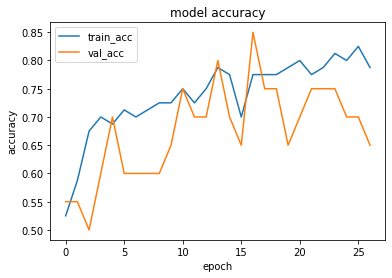

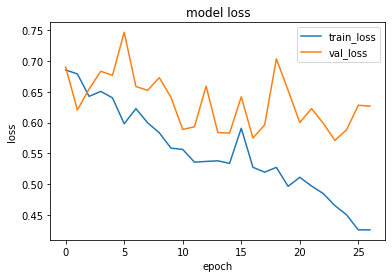

1it [00:00, 16980.99it/s]


prediction for video armflapping_1.mov is [[0.48942962]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.6731054]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.6355892]]


1it [00:00, 16912.52it/s]


prediction for video control_1.mov is [[0.3656267]]


1it [00:00, 19239.93it/s]


prediction for video control_2.mov is [[0.32490516]]


1it [00:00, 14716.86it/s]


prediction for video control_3.mov is [[0.31582892]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 172ms/step - loss: 0.7094 - accuracy: 0.4875 - precision: 0.4933 - recall: 0.9250 - val_loss: 0.6866 - val_accuracy: 0.5500 - val_precision: 1.0000 - val_recall: 0.1000
Epoch 2/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6930 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.0250 - val_loss: 0.6861 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6727 - accuracy: 0.6500 - precision: 0.8333 - recall: 0.3750 - val_loss: 0.6616 - val_accuracy: 0.5500 - val_precision: 0.5294 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6222 - accuracy: 0.6125 - precision: 0.5692 - recall: 0.9250 - val_loss: 0.6324 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epo

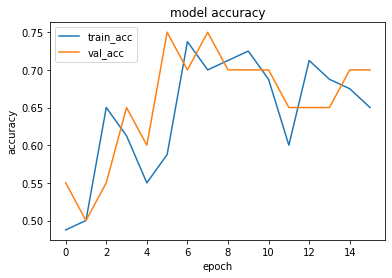

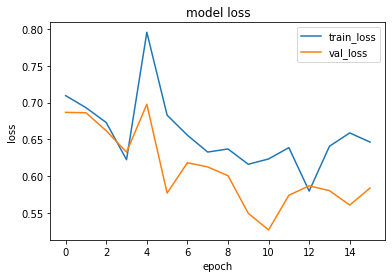

1it [00:00, 16070.13it/s]


prediction for video armflapping_1.mov is [[0.41197744]]


1it [00:00, 9532.51it/s]


prediction for video armflapping_3.mov is [[0.48436818]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.48502594]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.3577144]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.3422122]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.332363]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6923 - accuracy: 0.4750 - precision: 0.4792 - recall: 0.5750 - val_loss: 0.6985 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6755 - accuracy: 0.4875 - precision: 0.4828 - recall: 0.3500 - val_loss: 0.6858 - val_accuracy: 0.5500 - val_precision: 0.5333 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6884 - accuracy: 0.6750 - precision: 0.6750 - recall: 0.6750 - val_loss: 0.8306 - val_accuracy: 0.6000 - val_precision: 0.7500 - val_recall: 0.3000
Epoch 4/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6415 - accuracy: 0.6750 - precision: 0.7500 - recall: 0.5250 - val_loss: 0.6603 - val_accuracy: 0.7500 - val_precision: 0.8571 - val_recall: 0.6000
Epoch

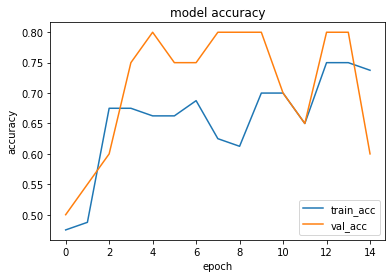

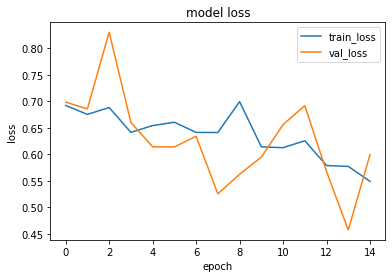

1it [00:00, 12372.58it/s]


prediction for video armflapping_1.mov is [[0.5921609]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.5662973]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.6269594]]


1it [00:00, 17848.10it/s]


prediction for video control_1.mov is [[0.5582388]]


1it [00:00, 16912.52it/s]


prediction for video control_2.mov is [[0.5298838]]


1it [00:00, 17549.39it/s]


prediction for video control_3.mov is [[0.5285484]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 139ms/step - loss: 0.7082 - accuracy: 0.4375 - precision: 0.3913 - recall: 0.2250 - val_loss: 0.6858 - val_accuracy: 0.7500 - val_precision: 0.6923 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6724 - accuracy: 0.5500 - precision: 0.5303 - recall: 0.8750 - val_loss: 0.6655 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6413 - accuracy: 0.7000 - precision: 0.6600 - recall: 0.8250 - val_loss: 0.6705 - val_accuracy: 0.7500 - val_precision: 0.6923 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6400 - accuracy: 0.6750 - precision: 0.6458 - recall: 0.7750 - val_loss: 0.6647 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 5/75
3

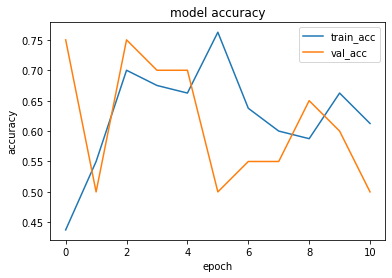

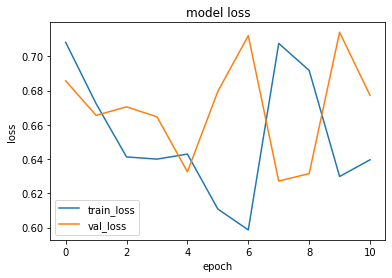

1it [00:00, 11618.57it/s]


prediction for video armflapping_1.mov is [[0.56185985]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_3.mov is [[0.43777925]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_2.mov is [[0.6035653]]


1it [00:00, 17772.47it/s]


prediction for video control_1.mov is [[0.53729516]]


1it [00:00, 16194.22it/s]


prediction for video control_2.mov is [[0.5289122]]


1it [00:00, 19239.93it/s]


prediction for video control_3.mov is [[0.5264506]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 142ms/step - loss: 0.7089 - accuracy: 0.5125 - precision: 0.5217 - recall: 0.3000 - val_loss: 0.6815 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6904 - accuracy: 0.5500 - precision: 0.5294 - recall: 0.9000 - val_loss: 0.6644 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6647 - accuracy: 0.7000 - precision: 0.7500 - recall: 0.6000 - val_loss: 0.6560 - val_accuracy: 0.5500 - val_precision: 0.6667 - val_recall: 0.2000
Epoch 4/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6784 - accuracy: 0.5375 - precision: 0.8000 - recall: 0.1000 - val_loss: 0.6472 - val_accuracy: 0.6500 - val_precision: 0.7143 - val_recall: 0.5000
Epoch 5/75
3

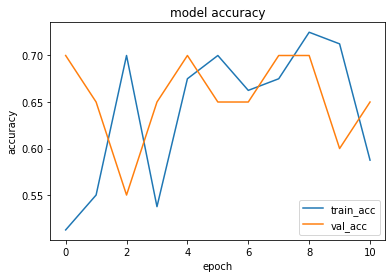

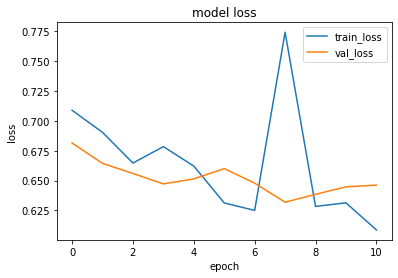

1it [00:00, 15420.24it/s]


prediction for video armflapping_1.mov is [[0.5718907]]


1it [00:00, 18558.87it/s]


prediction for video armflapping_3.mov is [[0.62523186]]


1it [00:00, 13486.51it/s]


prediction for video armflapping_2.mov is [[0.6913828]]


1it [00:00, 14979.66it/s]


prediction for video control_1.mov is [[0.5316777]]


1it [00:00, 12787.51it/s]


prediction for video control_2.mov is [[0.51659316]]


1it [00:00, 15592.21it/s]


prediction for video control_3.mov is [[0.5050677]]


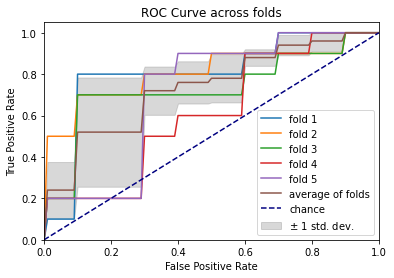

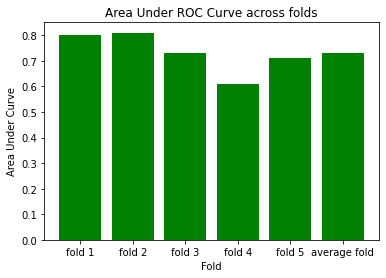

(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6989 - accuracy: 0.4875 - precision: 0.4706 - recall: 0.2000 - val_loss: 0.7108 - val_accuracy: 0.3500 - val_precision: 0.4000 - val_recall: 0.6000
Epoch 2/75
3/3 [==============================] - 1s 172ms/step - loss: 0.6602 - accuracy: 0.5125 - precision: 0.5098 - recall: 0.6500 - val_loss: 0.7055 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6208 - accuracy: 0.6000 - precision: 0.5588 - recall: 0.9500 - val_loss: 0.7085 - val_accuracy: 0.4500 - val_precision: 0.4737 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6215 - accuracy: 0.5875 - precision: 0.5493 - recall: 0.9750 - val_loss: 0.7097 - val_accuracy: 0.4500 - val_precision: 0.4737 - val_recall: 0.9000
Epoch 5/75
3/3 [==============================] - 0s 140ms/step 

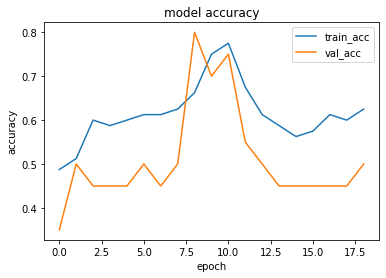

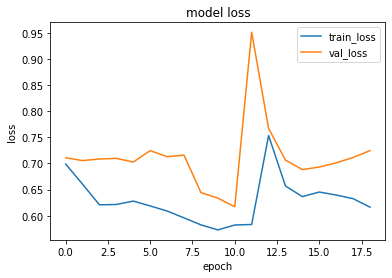

1it [00:00, 12372.58it/s]


prediction for video armflapping_1.mov is [[0.35983968]]


1it [00:00, 10894.30it/s]


prediction for video armflapping_3.mov is [[0.4144296]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_2.mov is [[0.4826409]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.3110487]]


1it [00:00, 18893.26it/s]


prediction for video control_2.mov is [[0.2989844]]


1it [00:00, 15363.75it/s]


prediction for video control_3.mov is [[0.29561973]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6945 - accuracy: 0.4250 - precision: 0.4464 - recall: 0.6250 - val_loss: 0.6722 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000
Epoch 2/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6699 - accuracy: 0.6000 - precision: 0.5667 - recall: 0.8500 - val_loss: 0.6134 - val_accuracy: 0.6000 - val_precision: 0.5556 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6614 - accuracy: 0.6125 - precision: 0.5763 - recall: 0.8500 - val_loss: 0.6085 - val_accuracy: 0.6000 - val_precision: 0.6667 - val_recall: 0.4000
Epoch 4/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6453 - accuracy: 0.6750 - precision: 0.6667 - recall: 0.7000 - val_loss: 0.6538 - val_accuracy: 0.6500 - val_precision: 1.0000 - val_recall: 0.3000
Epoch 5/75


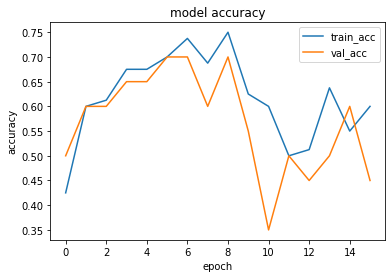

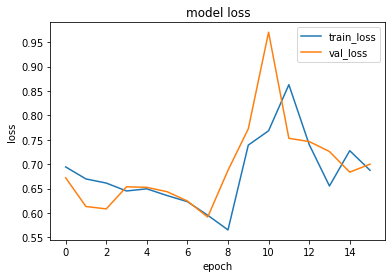

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.4220677]]


1it [00:00, 16710.37it/s]


prediction for video armflapping_3.mov is [[0.56703943]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_2.mov is [[0.44399577]]


1it [00:00, 15196.75it/s]


prediction for video control_1.mov is [[0.56498283]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.56470096]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.4166022]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 134ms/step - loss: 0.7086 - accuracy: 0.4125 - precision: 0.3478 - recall: 0.2000 - val_loss: 0.6793 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6784 - accuracy: 0.6875 - precision: 0.6596 - recall: 0.7750 - val_loss: 0.6553 - val_accuracy: 0.7500 - val_precision: 0.6923 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6624 - accuracy: 0.6750 - precision: 0.6842 - recall: 0.6500 - val_loss: 0.5918 - val_accuracy: 0.7500 - val_precision: 0.6923 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6743 - accuracy: 0.6750 - precision: 0.6346 - recall: 0.8250 - val_loss: 0.6323 - val_accuracy: 0.6000 - val_precision: 0.6250 - val_recall: 0.5000
Epoch 5/75
3

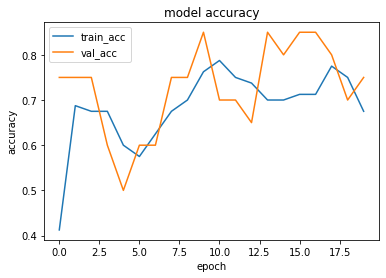

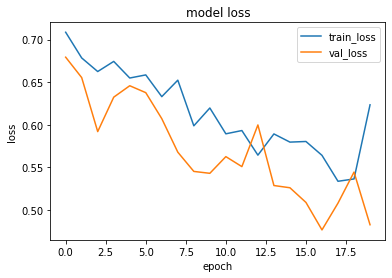

1it [00:00, 15827.56it/s]


prediction for video armflapping_1.mov is [[0.5287922]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_3.mov is [[0.5809149]]


1it [00:00, 13148.29it/s]


prediction for video armflapping_2.mov is [[0.5775109]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.49262556]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.48408267]]


1it [00:00, 14315.03it/s]


prediction for video control_3.mov is [[0.45921728]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6962 - accuracy: 0.4875 - precision: 0.4848 - recall: 0.4000 - val_loss: 0.6614 - val_accuracy: 0.6000 - val_precision: 0.5556 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6742 - accuracy: 0.6500 - precision: 0.6364 - recall: 0.7000 - val_loss: 0.6586 - val_accuracy: 0.4500 - val_precision: 0.3333 - val_recall: 0.1000
Epoch 3/75
3/3 [==============================] - 1s 191ms/step - loss: 0.6559 - accuracy: 0.6125 - precision: 0.8000 - recall: 0.3000 - val_loss: 0.6409 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6707 - accuracy: 0.7375 - precision: 0.6863 - recall: 0.8750 - val_loss: 0.5545 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 5/75


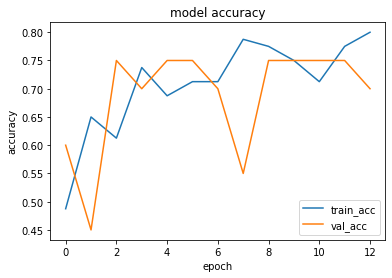

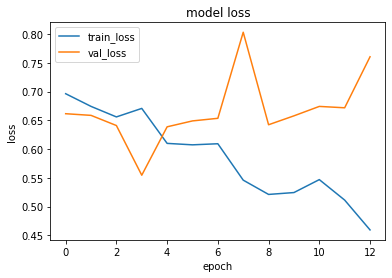

1it [00:00, 16578.28it/s]


prediction for video armflapping_1.mov is [[0.4981318]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.7613747]]


1it [00:00, 16070.13it/s]


prediction for video armflapping_2.mov is [[0.7683846]]


1it [00:00, 7503.23it/s]


prediction for video control_1.mov is [[0.14822814]]


1it [00:00, 13148.29it/s]


prediction for video control_2.mov is [[0.13557002]]


1it [00:00, 15420.24it/s]


prediction for video control_3.mov is [[0.17644832]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6735 - accuracy: 0.5875 - precision: 0.5778 - recall: 0.6500 - val_loss: 0.9018 - val_accuracy: 0.4000 - val_precision: 0.4444 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 129ms/step - loss: 0.7154 - accuracy: 0.6500 - precision: 0.6200 - recall: 0.7750 - val_loss: 0.6749 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6725 - accuracy: 0.5125 - precision: 0.5063 - recall: 1.0000 - val_loss: 0.6712 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6766 - accuracy: 0.7125 - precision: 0.6809 - recall: 0.8000 - val_loss: 0.6679 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 5/75


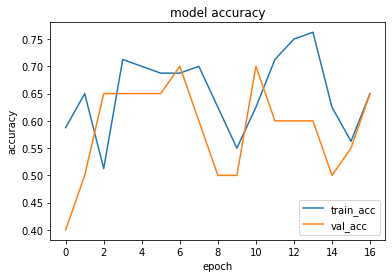

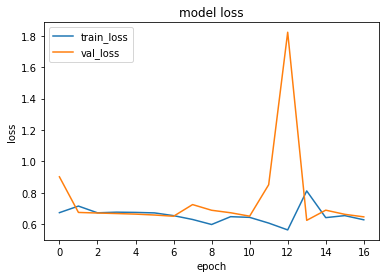

1it [00:00, 16448.25it/s]


prediction for video armflapping_1.mov is [[0.51128644]]


1it [00:00, 18236.10it/s]


prediction for video armflapping_3.mov is [[0.53831226]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_2.mov is [[0.5438803]]


1it [00:00, 18157.16it/s]


prediction for video control_1.mov is [[0.4908162]]


1it [00:00, 5915.80it/s]


prediction for video control_2.mov is [[0.47936714]]


1it [00:00, 14716.86it/s]


prediction for video control_3.mov is [[0.47889104]]


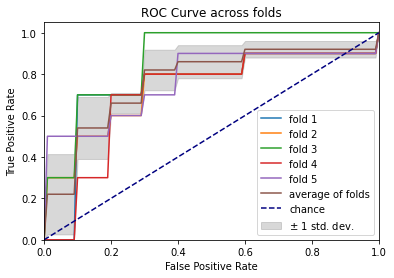

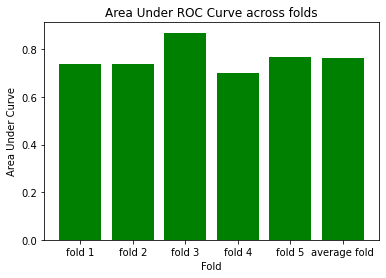

(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 1s 178ms/step - loss: 0.6916 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.7750 - val_loss: 0.6467 - val_accuracy: 0.8500 - val_precision: 1.0000 - val_recall: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6304 - accuracy: 0.7000 - precision: 0.7500 - recall: 0.6000 - val_loss: 0.9380 - val_accuracy: 0.6500 - val_precision: 0.8000 - val_recall: 0.4000
Epoch 3/75
3/3 [==============================] - 0s 154ms/step - loss: 1.0665 - accuracy: 0.6375 - precision: 0.7037 - recall: 0.4750 - val_loss: 0.6095 - val_accuracy: 0.6500 - val_precision: 0.6000 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6870 - accuracy: 0.5625 - precision: 0.5373 - recall: 0.9000 - val_loss: 0.6429 - val_accuracy: 0.8000 - val_precision: 0.8750 - val_recall: 0.7000
Epoch 5/75
3/3 [==============================] - 0s 144ms/step 

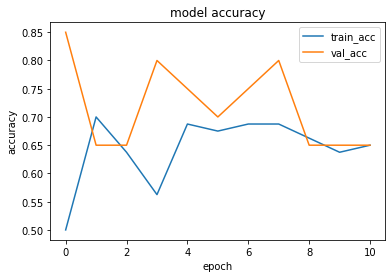

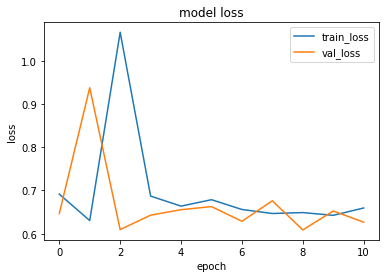

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.5022266]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.5069939]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_2.mov is [[0.5115799]]


1it [00:00, 15592.21it/s]


prediction for video control_1.mov is [[0.49615034]]


1it [00:00, 14979.66it/s]


prediction for video control_2.mov is [[0.49388283]]


1it [00:00, 15363.75it/s]


prediction for video control_3.mov is [[0.49298555]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6981 - accuracy: 0.4375 - precision: 0.4194 - recall: 0.3250 - val_loss: 0.6903 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 145ms/step - loss: 0.7563 - accuracy: 0.5500 - precision: 0.5263 - recall: 1.0000 - val_loss: 0.7056 - val_accuracy: 0.6000 - val_precision: 0.6250 - val_recall: 0.5000
Epoch 3/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6737 - accuracy: 0.7500 - precision: 0.7273 - recall: 0.8000 - val_loss: 0.6991 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.3000
Epoch 4/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6708 - accuracy: 0.6250 - precision: 0.7083 - recall: 0.4250 - val_loss: 0.6949 - val_accuracy: 0.5500 - val_precision: 0.6000 - val_recall: 0.3000
Epoch 5/75


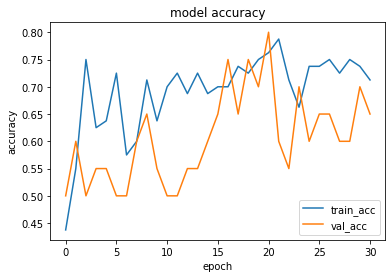

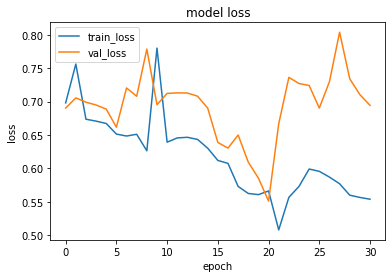

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.4580868]]


1it [00:00, 13315.25it/s]


prediction for video armflapping_3.mov is [[0.65384924]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.66040754]]


1it [00:00, 16710.37it/s]


prediction for video control_1.mov is [[0.3185072]]


1it [00:00, 13706.88it/s]


prediction for video control_2.mov is [[0.31218648]]


1it [00:00, 12633.45it/s]


prediction for video control_3.mov is [[0.3124827]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6953 - accuracy: 0.4875 - precision: 0.4762 - recall: 0.2500 - val_loss: 0.7005 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6544 - accuracy: 0.5750 - precision: 0.5455 - recall: 0.9000 - val_loss: 0.7293 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6261 - accuracy: 0.5875 - precision: 0.5507 - recall: 0.9500 - val_loss: 0.7498 - val_accuracy: 0.4000 - val_precision: 0.4444 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6143 - accuracy: 0.6375 - precision: 0.5873 - recall: 0.9250 - val_loss: 0.7632 - val_accuracy: 0.5500 - val_precision: 0.5333 - val_recall: 0.8000
Epoch 5/75
3

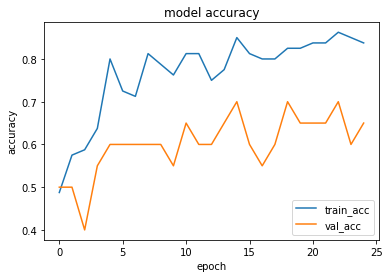

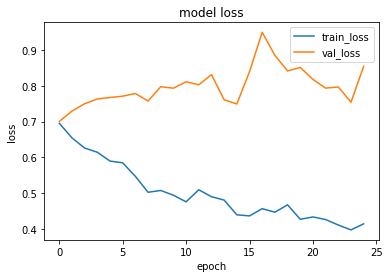

1it [00:00, 6482.70it/s]


prediction for video armflapping_1.mov is [[0.29953164]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_3.mov is [[0.33797526]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.71748513]]


1it [00:00, 14926.35it/s]


prediction for video control_1.mov is [[0.24141786]]


1it [00:00, 9731.56it/s]


prediction for video control_2.mov is [[0.21102071]]


1it [00:00, 14716.86it/s]


prediction for video control_3.mov is [[0.24868482]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6921 - accuracy: 0.5250 - precision: 0.5147 - recall: 0.8750 - val_loss: 0.6719 - val_accuracy: 0.6500 - val_precision: 0.8000 - val_recall: 0.4000
Epoch 2/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6736 - accuracy: 0.6000 - precision: 0.6538 - recall: 0.4250 - val_loss: 0.6210 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6627 - accuracy: 0.6875 - precision: 0.7273 - recall: 0.6000 - val_loss: 0.6206 - val_accuracy: 0.6500 - val_precision: 0.5882 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6428 - accuracy: 0.6250 - precision: 0.5758 - recall: 0.9500 - val_loss: 0.5894 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 5/75


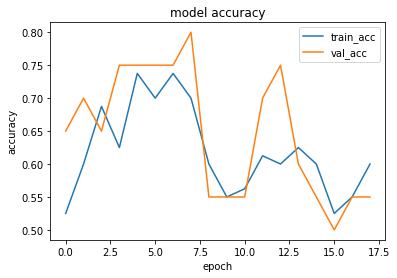

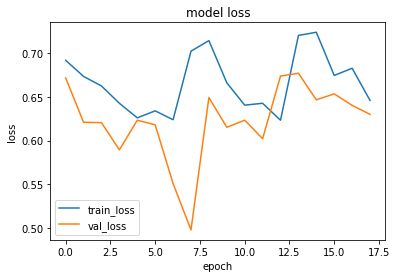

1it [00:00, 15420.24it/s]


prediction for video armflapping_1.mov is [[0.5286675]]


1it [00:00, 17189.77it/s]


prediction for video armflapping_3.mov is [[0.57588094]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_2.mov is [[0.55477804]]


1it [00:00, 16131.94it/s]


prediction for video control_1.mov is [[0.51468]]


1it [00:00, 13934.56it/s]


prediction for video control_2.mov is [[0.50687265]]


1it [00:00, 15420.24it/s]


prediction for video control_3.mov is [[0.5033769]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.7026 - accuracy: 0.6000 - precision: 0.5714 - recall: 0.8000 - val_loss: 0.6822 - val_accuracy: 0.6000 - val_precision: 0.6667 - val_recall: 0.4000
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6721 - accuracy: 0.6375 - precision: 0.6410 - recall: 0.6250 - val_loss: 0.6322 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 121ms/step - loss: 0.7365 - accuracy: 0.6250 - precision: 0.5926 - recall: 0.8000 - val_loss: 0.5657 - val_accuracy: 0.6500 - val_precision: 0.5882 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6419 - accuracy: 0.6250 - precision: 0.5893 - recall: 0.8250 - val_loss: 0.6474 - val_accuracy: 0.6000 - val_precision: 1.0000 - val_recall: 0.2000
Epoch 5/75
3

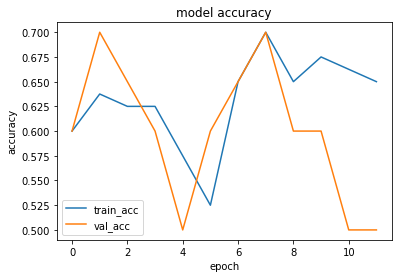

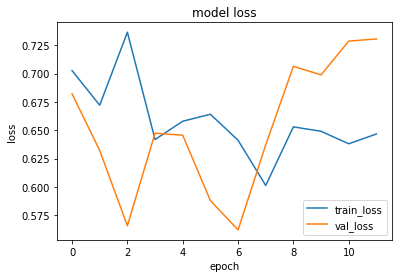

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.42992535]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_3.mov is [[0.44435367]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.4456858]]


1it [00:00, 14266.34it/s]


prediction for video control_1.mov is [[0.40899086]]


1it [00:00, 18157.16it/s]


prediction for video control_2.mov is [[0.39065188]]


1it [00:00, 16384.00it/s]


prediction for video control_3.mov is [[0.39912844]]


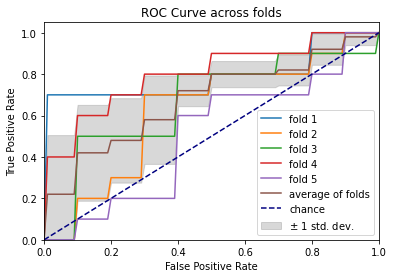

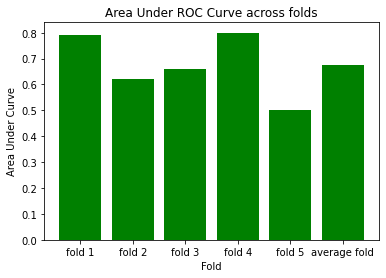

(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 1s 192ms/step - loss: 0.7175 - accuracy: 0.4250 - precision: 0.4400 - recall: 0.5500 - val_loss: 0.6733 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 191ms/step - loss: 0.6632 - accuracy: 0.6875 - precision: 0.6667 - recall: 0.7500 - val_loss: 0.7519 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/75
3/3 [==============================] - 0s 181ms/step - loss: 0.6911 - accuracy: 0.5750 - precision: 0.6667 - recall: 0.3000 - val_loss: 0.6671 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 1s 192ms/step - loss: 0.6645 - accuracy: 0.6125 - precision: 0.5652 - recall: 0.9750 - val_loss: 0.6734 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 5/75
3/3 [==============================] - 1s 192

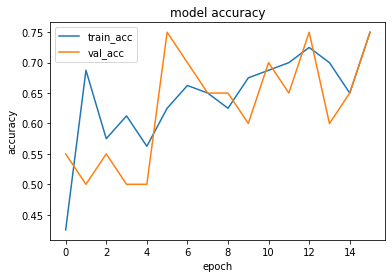

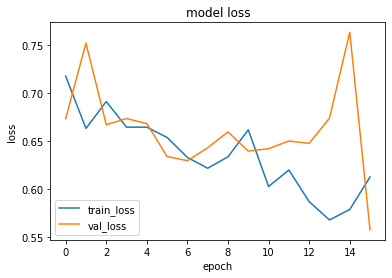

1it [00:00, 15420.24it/s]


prediction for video armflapping_1.mov is [[0.51349264]]


1it [00:00, 16980.99it/s]


prediction for video armflapping_3.mov is [[0.5763629]]


1it [00:00, 16384.00it/s]


prediction for video armflapping_2.mov is [[0.60516006]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.46816275]]


1it [00:00, 13530.01it/s]


prediction for video control_2.mov is [[0.45245433]]


1it [00:00, 14266.34it/s]


prediction for video control_3.mov is [[0.4656445]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 1s 167ms/step - loss: 0.7021 - accuracy: 0.4500 - precision: 0.4565 - recall: 0.5250 - val_loss: 0.6595 - val_accuracy: 0.6000 - val_precision: 0.5714 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 186ms/step - loss: 0.6727 - accuracy: 0.6125 - precision: 0.5763 - recall: 0.8500 - val_loss: 0.6084 - val_accuracy: 0.6500 - val_precision: 0.5882 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6721 - accuracy: 0.5750 - precision: 0.5484 - recall: 0.8500 - val_loss: 0.8503 - val_accuracy: 0.5500 - val_precision: 0.6667 - val_recall: 0.2000
Epoch 4/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6969 - accuracy: 0.6375 - precision: 0.8667 - recall: 0.3250 - val_loss: 0.6997 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 5/75
3

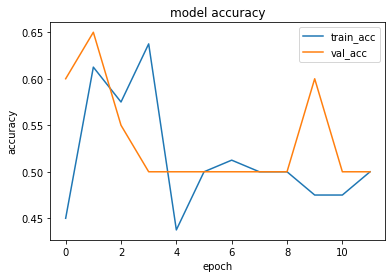

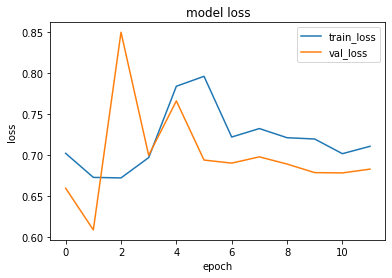

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.55754894]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.56376696]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.5604365]]


1it [00:00, 16131.94it/s]


prediction for video control_1.mov is [[0.55716014]]


1it [00:00, 17189.77it/s]


prediction for video control_2.mov is [[0.5570568]]


1it [00:00, 17260.51it/s]


prediction for video control_3.mov is [[0.55704653]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.7481 - accuracy: 0.5875 - precision: 0.5814 - recall: 0.6250 - val_loss: 0.6861 - val_accuracy: 0.5500 - val_precision: 0.5294 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6673 - accuracy: 0.6875 - precision: 0.7586 - recall: 0.5500 - val_loss: 0.6741 - val_accuracy: 0.5500 - val_precision: 1.0000 - val_recall: 0.1000
Epoch 3/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6769 - accuracy: 0.5250 - precision: 0.7500 - recall: 0.0750 - val_loss: 0.6624 - val_accuracy: 0.5500 - val_precision: 0.6667 - val_recall: 0.2000
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6622 - accuracy: 0.6250 - precision: 0.9167 - recall: 0.2750 - val_loss: 0.6454 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 5/75


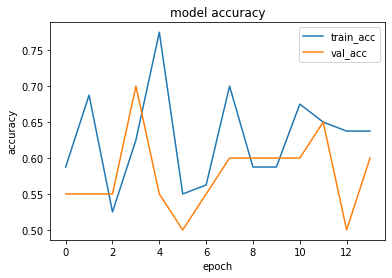

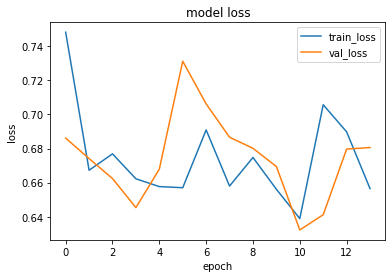

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.4965089]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_3.mov is [[0.5023549]]


1it [00:00, 16644.06it/s]


prediction for video armflapping_2.mov is [[0.5068064]]


1it [00:00, 14463.12it/s]


prediction for video control_1.mov is [[0.49111012]]


1it [00:00, 13530.01it/s]


prediction for video control_2.mov is [[0.4891003]]


1it [00:00, 16980.99it/s]


prediction for video control_3.mov is [[0.4900285]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6944 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.7750 - val_loss: 0.6767 - val_accuracy: 0.6500 - val_precision: 1.0000 - val_recall: 0.3000
Epoch 2/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6448 - accuracy: 0.6375 - precision: 0.7619 - recall: 0.4000 - val_loss: 0.7000 - val_accuracy: 0.4500 - val_precision: 0.4737 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6417 - accuracy: 0.6000 - precision: 0.5556 - recall: 1.0000 - val_loss: 0.6908 - val_accuracy: 0.6000 - val_precision: 0.5714 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6129 - accuracy: 0.7125 - precision: 0.6667 - recall: 0.8500 - val_loss: 0.6986 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.2000
Epoch 5/75
3

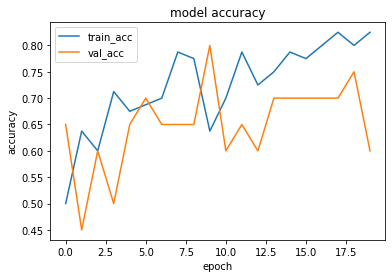

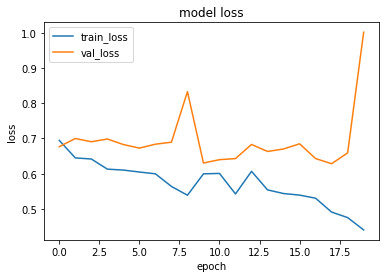

1it [00:00, 15592.21it/s]


prediction for video armflapping_1.mov is [[0.50113344]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_3.mov is [[0.34160155]]


1it [00:00, 16384.00it/s]


prediction for video armflapping_2.mov is [[0.4785951]]


1it [00:00, 15650.39it/s]


prediction for video control_1.mov is [[0.4420867]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.40268916]]


1it [00:00, 14266.34it/s]


prediction for video control_3.mov is [[0.39305782]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 1s 138ms/step - loss: 0.6833 - accuracy: 0.5625 - precision: 0.5556 - recall: 0.6250 - val_loss: 0.8068 - val_accuracy: 0.6000 - val_precision: 0.5556 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6846 - accuracy: 0.5875 - precision: 0.5574 - recall: 0.8500 - val_loss: 0.6548 - val_accuracy: 0.6000 - val_precision: 0.7500 - val_recall: 0.3000
Epoch 3/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6472 - accuracy: 0.5875 - precision: 0.7692 - recall: 0.2500 - val_loss: 0.8584 - val_accuracy: 0.6000 - val_precision: 1.0000 - val_recall: 0.2000
Epoch 4/75
3/3 [==============================] - 0s 140ms/step - loss: 0.7375 - accuracy: 0.5125 - precision: 0.5556 - recall: 0.1250 - val_loss: 0.6600 - val_accuracy: 0.7000 - val_precision: 1.0000 - val_recall: 0.4000
Epoch 5/75


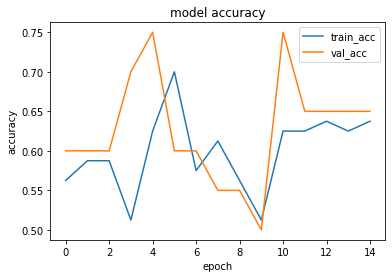

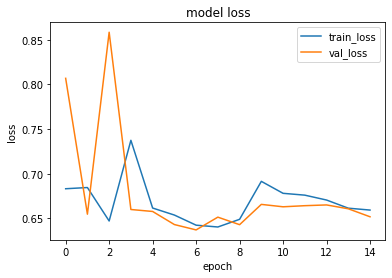

1it [00:00, 14513.16it/s]


prediction for video armflapping_1.mov is [[0.46710587]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_3.mov is [[0.4942111]]


1it [00:00, 13706.88it/s]


prediction for video armflapping_2.mov is [[0.48165822]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.46096852]]


1it [00:00, 11915.64it/s]


prediction for video control_2.mov is [[0.46016562]]


1it [00:00, 14665.40it/s]


prediction for video control_3.mov is [[0.45932126]]


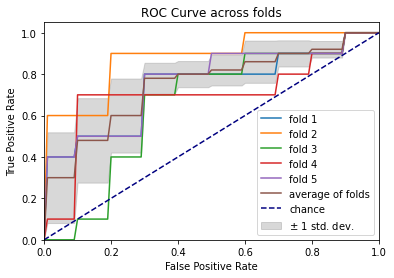

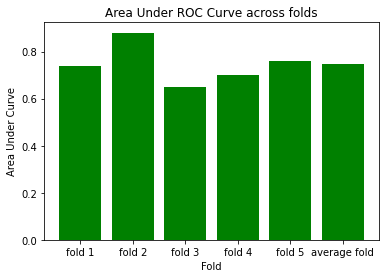

(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.7182 - accuracy: 0.4500 - precision: 0.4697 - recall: 0.7750 - val_loss: 0.6968 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6787 - accuracy: 0.6625 - precision: 0.6585 - recall: 0.6750 - val_loss: 0.6846 - val_accuracy: 0.5500 - val_precision: 0.6667 - val_recall: 0.2000
Epoch 3/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6690 - accuracy: 0.5500 - precision: 0.7500 - recall: 0.1500 - val_loss: 0.6054 - val_accuracy: 0.7500 - val_precision: 0.8571 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6480 - accuracy: 0.6500 - precision: 0.6200 - recall: 0.7750 - val_loss: 0.7127 - val_accuracy: 0.6000 - val_precision: 0.5625 - val_recall: 0.9000
Epoch 5/75
3/3 [==============================] - 0s 121ms/step 

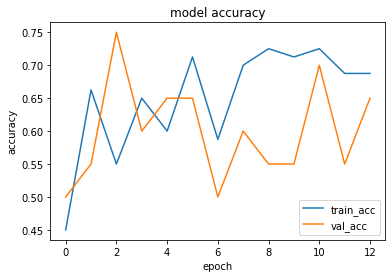

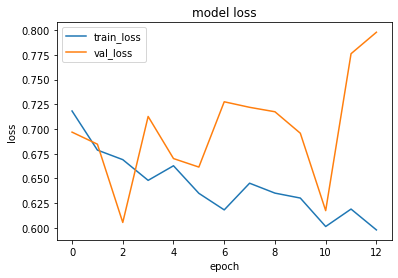

1it [00:00, 16194.22it/s]


prediction for video armflapping_1.mov is [[0.48160708]]


1it [00:00, 20460.02it/s]


prediction for video armflapping_3.mov is [[0.50509083]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_2.mov is [[0.5107858]]


1it [00:00, 16448.25it/s]


prediction for video control_1.mov is [[0.46756047]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.4656281]]


1it [00:00, 17476.27it/s]


prediction for video control_3.mov is [[0.46361506]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6890 - accuracy: 0.5750 - precision: 0.5484 - recall: 0.8500 - val_loss: 0.6593 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6866 - accuracy: 0.5125 - precision: 0.5200 - recall: 0.3250 - val_loss: 0.6575 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6616 - accuracy: 0.6625 - precision: 0.6140 - recall: 0.8750 - val_loss: 0.6795 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6466 - accuracy: 0.7250 - precision: 0.7045 - recall: 0.7750 - val_loss: 0.6612 - val_accuracy: 0.6000 - val_precision: 0.6250 - val_recall: 0.5000
Epoch 5/75


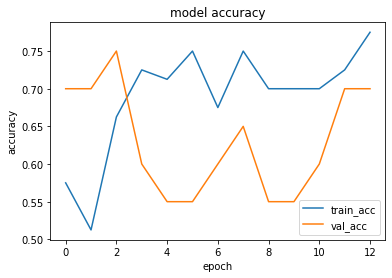

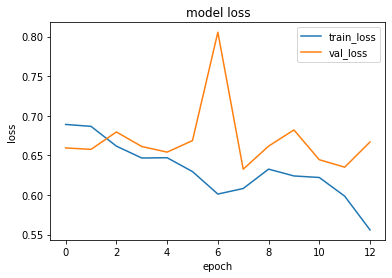

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.25328735]]


1it [00:00, 14768.68it/s]


prediction for video armflapping_3.mov is [[0.6547502]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_2.mov is [[0.6254076]]


1it [00:00, 16710.37it/s]


prediction for video control_1.mov is [[0.17842516]]


1it [00:00, 13617.87it/s]


prediction for video control_2.mov is [[0.17048949]]


1it [00:00, 14463.12it/s]


prediction for video control_3.mov is [[0.18500695]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6816 - accuracy: 0.6500 - precision: 0.6875 - recall: 0.5500 - val_loss: 0.6442 - val_accuracy: 0.8000 - val_precision: 0.7500 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6946 - accuracy: 0.6375 - precision: 0.5965 - recall: 0.8500 - val_loss: 0.6403 - val_accuracy: 0.7000 - val_precision: 0.6429 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6636 - accuracy: 0.6625 - precision: 0.6512 - recall: 0.7000 - val_loss: 0.6516 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6553 - accuracy: 0.6625 - precision: 0.7600 - recall: 0.4750 - val_loss: 0.6406 - val_accuracy: 0.6500 - val_precision: 0.7143 - val_recall: 0.5000
Epoch 5/75


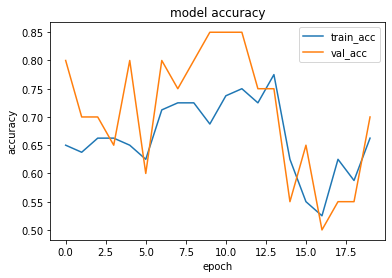

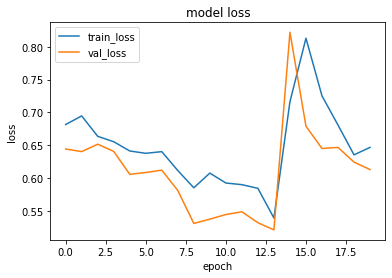

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.40269008]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_3.mov is [[0.45677537]]


1it [00:00, 12826.62it/s]


prediction for video armflapping_2.mov is [[0.50498366]]


1it [00:00, 13315.25it/s]


prediction for video control_1.mov is [[0.34662575]]


1it [00:00, 14716.86it/s]


prediction for video control_2.mov is [[0.33087382]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.319286]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6740 - accuracy: 0.5875 - precision: 0.5614 - recall: 0.8000 - val_loss: 0.7447 - val_accuracy: 0.6000 - val_precision: 0.5625 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.7525 - accuracy: 0.5250 - precision: 0.5147 - recall: 0.8750 - val_loss: 0.6512 - val_accuracy: 0.8000 - val_precision: 0.8750 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6768 - accuracy: 0.6500 - precision: 0.6500 - recall: 0.6500 - val_loss: 0.6714 - val_accuracy: 0.6500 - val_precision: 1.0000 - val_recall: 0.3000
Epoch 4/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6764 - accuracy: 0.5500 - precision: 0.7000 - recall: 0.1750 - val_loss: 0.6760 - val_accuracy: 0.6000 - val_precision: 1.0000 - val_recall: 0.2000
Epoch 5/75
3/

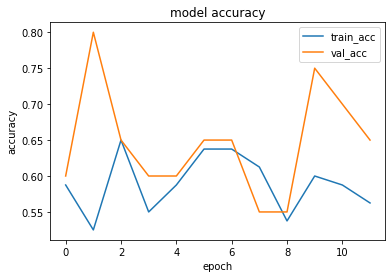

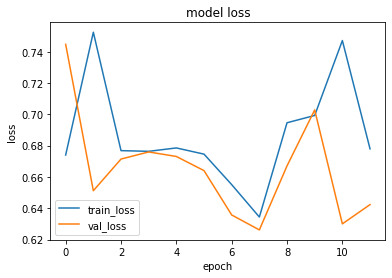

1it [00:00, 21620.12it/s]


prediction for video armflapping_1.mov is [[0.46155456]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.5089482]]


1it [00:00, 13315.25it/s]


prediction for video armflapping_2.mov is [[0.49403784]]


1it [00:00, 15650.39it/s]


prediction for video control_1.mov is [[0.44857085]]


1it [00:00, 17924.38it/s]


prediction for video control_2.mov is [[0.4442619]]


1it [00:00, 14768.68it/s]


prediction for video control_3.mov is [[0.44358233]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6815 - accuracy: 0.5875 - precision: 0.6129 - recall: 0.4750 - val_loss: 0.6698 - val_accuracy: 0.6000 - val_precision: 0.5714 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6538 - accuracy: 0.6125 - precision: 0.5714 - recall: 0.9000 - val_loss: 0.6660 - val_accuracy: 0.7000 - val_precision: 0.6429 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 133ms/step - loss: 0.7919 - accuracy: 0.7000 - precision: 0.7500 - recall: 0.6000 - val_loss: 0.6736 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6624 - accuracy: 0.6625 - precision: 0.6066 - recall: 0.9250 - val_loss: 0.6645 - val_accuracy: 0.6000 - val_precision: 0.5714 - val_recall: 0.8000
Epoch 5/75


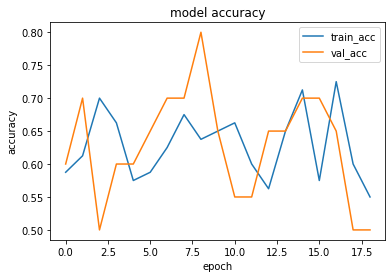

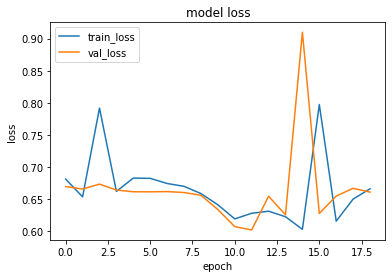

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.57153827]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.59700537]]


1it [00:00, 12671.61it/s]


prediction for video armflapping_2.mov is [[0.6101852]]


1it [00:00, 14563.56it/s]


prediction for video control_1.mov is [[0.55025434]]


1it [00:00, 14665.40it/s]


prediction for video control_2.mov is [[0.53846234]]


1it [00:00, 12157.40it/s]


prediction for video control_3.mov is [[0.53436977]]


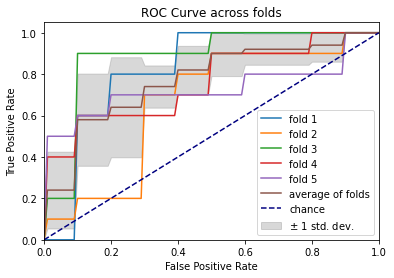

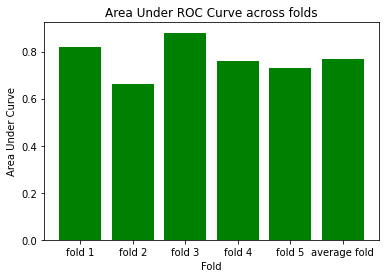

(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 135ms/step - loss: 0.7101 - accuracy: 0.4250 - precision: 0.4444 - recall: 0.6000 - val_loss: 0.6868 - val_accuracy: 0.4000 - val_precision: 0.4375 - val_recall: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6672 - accuracy: 0.5750 - precision: 0.5469 - recall: 0.8750 - val_loss: 0.8174 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6763 - accuracy: 0.5500 - precision: 0.5345 - recall: 0.7750 - val_loss: 0.6674 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6428 - accuracy: 0.5500 - precision: 0.5270 - recall: 0.9750 - val_loss: 0.6602 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 5/75
3/3 [==============================] - 0s 134ms/step 

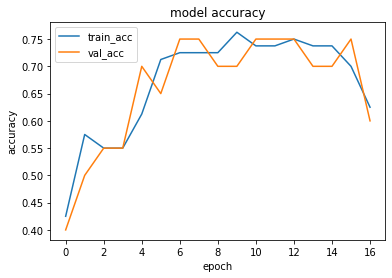

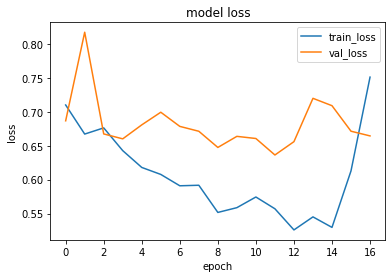

1it [00:00, 14873.42it/s]


prediction for video armflapping_1.mov is [[0.52133644]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_3.mov is [[0.5819849]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_2.mov is [[0.588122]]


1it [00:00, 15420.24it/s]


prediction for video control_1.mov is [[0.48526764]]


1it [00:00, 15196.75it/s]


prediction for video control_2.mov is [[0.4728956]]


1it [00:00, 15087.42it/s]


prediction for video control_3.mov is [[0.46828485]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6958 - accuracy: 0.4875 - precision: 0.4828 - recall: 0.3500 - val_loss: 0.6960 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6619 - accuracy: 0.5375 - precision: 0.5200 - recall: 0.9750 - val_loss: 0.7117 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 118ms/step - loss: 0.6449 - accuracy: 0.6000 - precision: 0.5571 - recall: 0.9750 - val_loss: 0.6462 - val_accuracy: 0.7000 - val_precision: 1.0000 - val_recall: 0.4000
Epoch 4/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6661 - accuracy: 0.7500 - precision: 0.8125 - recall: 0.6500 - val_loss: 0.7698 - val_accuracy: 0.6000 - val_precision: 1.0000 - val_recall: 0.2000
Epoch 5/75


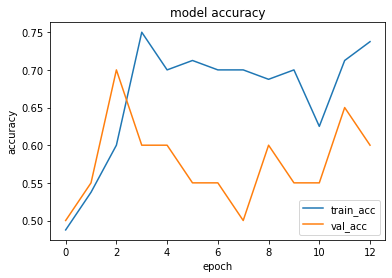

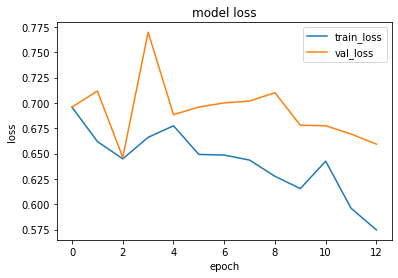

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.40030628]]


1it [00:00, 15477.14it/s]


prediction for video armflapping_3.mov is [[0.4952777]]


1it [00:00, 13189.64it/s]


prediction for video armflapping_2.mov is [[0.51733893]]


1it [00:00, 15252.01it/s]


prediction for video control_1.mov is [[0.17573419]]


1it [00:00, 16131.94it/s]


prediction for video control_2.mov is [[0.15165108]]


1it [00:00, 16448.25it/s]


prediction for video control_3.mov is [[0.22828478]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6950 - accuracy: 0.5125 - precision: 0.5102 - recall: 0.6250 - val_loss: 0.6718 - val_accuracy: 0.5500 - val_precision: 0.5333 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6828 - accuracy: 0.5625 - precision: 0.6087 - recall: 0.3500 - val_loss: 0.6518 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6243 - accuracy: 0.7000 - precision: 0.6667 - recall: 0.8000 - val_loss: 0.6429 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6321 - accuracy: 0.6375 - precision: 0.7391 - recall: 0.4250 - val_loss: 0.6294 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 5/75


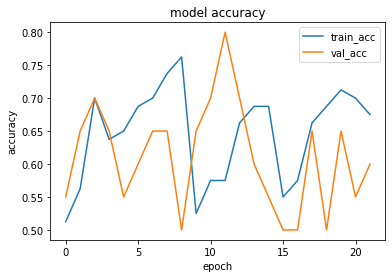

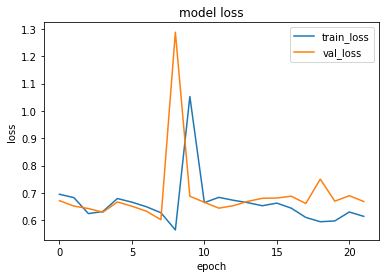

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.455315]]


1it [00:00, 16070.13it/s]


prediction for video armflapping_3.mov is [[0.54533434]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_2.mov is [[0.50082594]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.44305158]]


1it [00:00, 14563.56it/s]


prediction for video control_2.mov is [[0.48969445]]


1it [00:00, 14665.40it/s]


prediction for video control_3.mov is [[0.46890548]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6879 - accuracy: 0.5500 - precision: 0.5370 - recall: 0.7250 - val_loss: 0.6505 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6508 - accuracy: 0.6875 - precision: 0.6531 - recall: 0.8000 - val_loss: 0.5726 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 147ms/step - loss: 0.6273 - accuracy: 0.6750 - precision: 0.6346 - recall: 0.8250 - val_loss: 0.6050 - val_accuracy: 0.7500 - val_precision: 0.8571 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6096 - accuracy: 0.6875 - precision: 0.8261 - recall: 0.4750 - val_loss: 0.5820 - val_accuracy: 0.7500 - val_precision: 0.8571 - val_recall: 0.6000
Epoch 5/75


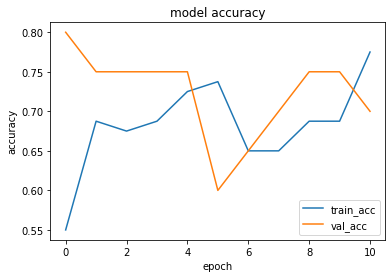

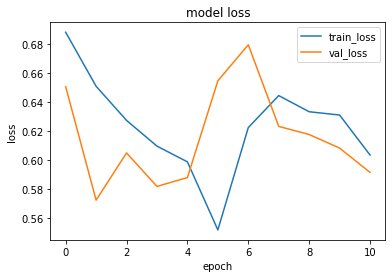

1it [00:00, 15196.75it/s]


prediction for video armflapping_1.mov is [[0.4860978]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_3.mov is [[0.5732686]]


1it [00:00, 11915.64it/s]


prediction for video armflapping_2.mov is [[0.5268276]]


1it [00:00, 13530.01it/s]


prediction for video control_1.mov is [[0.46157357]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.45978984]]


1it [00:00, 17549.39it/s]


prediction for video control_3.mov is [[0.45569262]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 145ms/step - loss: 0.7222 - accuracy: 0.4125 - precision: 0.3704 - recall: 0.2500 - val_loss: 0.6812 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6873 - accuracy: 0.5125 - precision: 0.5088 - recall: 0.7250 - val_loss: 0.6646 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6740 - accuracy: 0.5375 - precision: 0.5205 - recall: 0.9500 - val_loss: 0.6309 - val_accuracy: 0.8000 - val_precision: 0.7143 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6851 - accuracy: 0.5750 - precision: 0.5469 - recall: 0.8750 - val_loss: 0.6030 - val_accuracy: 0.9500 - val_precision: 1.0000 - val_recall: 0.9000
Epoch 5/75


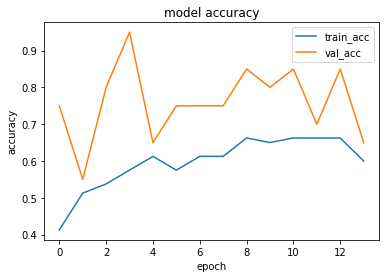

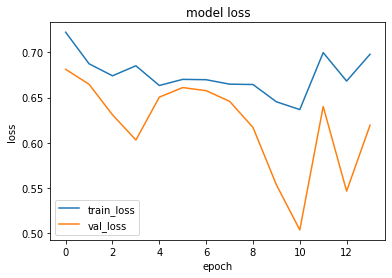

1it [00:00, 15196.75it/s]


prediction for video armflapping_1.mov is [[0.48715043]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.48397994]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.5039381]]


1it [00:00, 15592.21it/s]


prediction for video control_1.mov is [[0.47500688]]


1it [00:00, 17848.10it/s]


prediction for video control_2.mov is [[0.47100288]]


1it [00:00, 15592.21it/s]


prediction for video control_3.mov is [[0.46880728]]


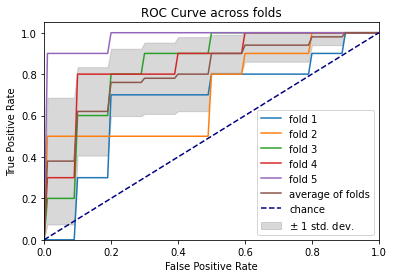

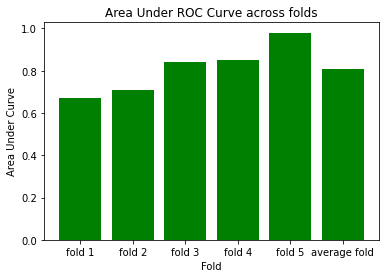

(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6956 - accuracy: 0.5375 - precision: 0.5405 - recall: 0.5000 - val_loss: 0.6413 - val_accuracy: 0.9000 - val_precision: 0.8333 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6592 - accuracy: 0.6250 - precision: 0.5926 - recall: 0.8000 - val_loss: 0.7116 - val_accuracy: 0.6000 - val_precision: 0.5556 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 1s 147ms/step - loss: 0.7213 - accuracy: 0.5875 - precision: 0.5556 - recall: 0.8750 - val_loss: 0.6032 - val_accuracy: 0.8500 - val_precision: 0.8889 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6639 - accuracy: 0.6250 - precision: 0.8125 - recall: 0.3250 - val_loss: 0.6107 - val_accuracy: 0.8500 - val_precision: 0.8889 - val_recall: 0.8000
Epoch 5/75
3/3 [==============================] - 0s 143ms/step 

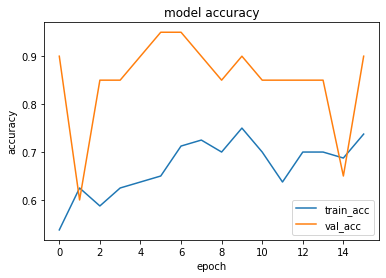

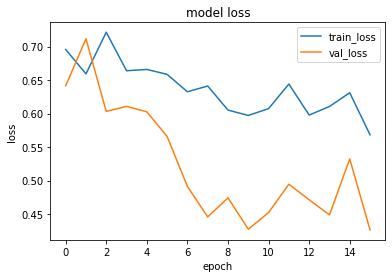

1it [00:00, 16131.94it/s]


prediction for video armflapping_1.mov is [[0.51275474]]


1it [00:00, 16448.25it/s]


prediction for video armflapping_3.mov is [[0.5336411]]


1it [00:00, 13025.79it/s]


prediction for video armflapping_2.mov is [[0.531387]]


1it [00:00, 15650.39it/s]


prediction for video control_1.mov is [[0.49964848]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.4948369]]


1it [00:00, 15363.75it/s]


prediction for video control_3.mov is [[0.4943342]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 156ms/step - loss: 0.6845 - accuracy: 0.6125 - precision: 0.6216 - recall: 0.5750 - val_loss: 0.7043 - val_accuracy: 0.5500 - val_precision: 0.6667 - val_recall: 0.2000
Epoch 2/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6650 - accuracy: 0.6625 - precision: 0.8095 - recall: 0.4250 - val_loss: 0.7021 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6227 - accuracy: 0.6125 - precision: 0.5672 - recall: 0.9500 - val_loss: 0.7187 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 134ms/step - loss: 0.5836 - accuracy: 0.7125 - precision: 0.6604 - recall: 0.8750 - val_loss: 0.8600 - val_accuracy: 0.6500 - val_precision: 0.6000 - val_recall: 0.9000
Epoch 5/75
3

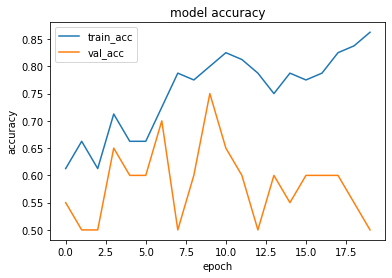

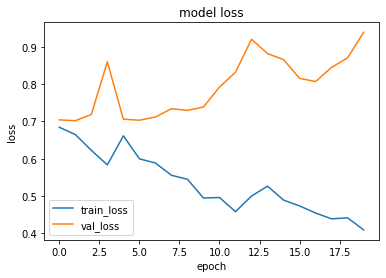

1it [00:00, 14513.16it/s]


prediction for video armflapping_1.mov is [[0.548197]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.7743449]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_2.mov is [[0.7733433]]


1it [00:00, 14926.35it/s]


prediction for video control_1.mov is [[0.24228114]]


1it [00:00, 12826.62it/s]


prediction for video control_2.mov is [[0.22086266]]


1it [00:00, 14926.35it/s]


prediction for video control_3.mov is [[0.20427448]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 142ms/step - loss: 0.7031 - accuracy: 0.4125 - precision: 0.2941 - recall: 0.1250 - val_loss: 0.6909 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6797 - accuracy: 0.5875 - precision: 0.5522 - recall: 0.9250 - val_loss: 0.6864 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 128ms/step - loss: 0.6714 - accuracy: 0.5375 - precision: 0.5205 - recall: 0.9500 - val_loss: 0.6951 - val_accuracy: 0.6000 - val_precision: 0.5714 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6446 - accuracy: 0.6750 - precision: 0.6250 - recall: 0.8750 - val_loss: 0.7101 - val_accuracy: 0.6500 - val_precision: 0.8000 - val_recall: 0.4000
Epoch 5/75


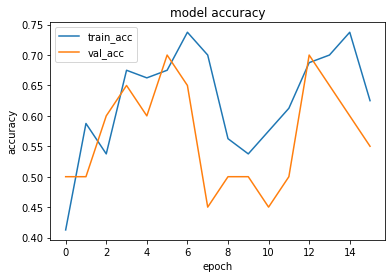

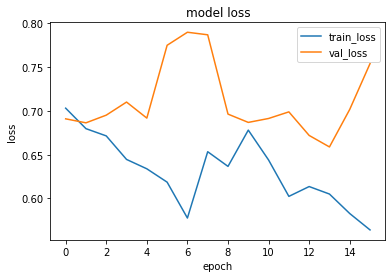

1it [00:00, 11008.67it/s]


prediction for video armflapping_1.mov is [[0.6248821]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_3.mov is [[0.67328095]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.68599725]]


1it [00:00, 16194.22it/s]


prediction for video control_1.mov is [[0.58426416]]


1it [00:00, 14074.85it/s]


prediction for video control_2.mov is [[0.5708481]]


1it [00:00, 15827.56it/s]


prediction for video control_3.mov is [[0.5618345]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 154ms/step - loss: 0.7101 - accuracy: 0.4375 - precision: 0.4561 - recall: 0.6500 - val_loss: 0.7075 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6843 - accuracy: 0.6000 - precision: 0.5714 - recall: 0.8000 - val_loss: 0.6929 - val_accuracy: 0.6000 - val_precision: 0.5714 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6578 - accuracy: 0.6875 - precision: 0.6471 - recall: 0.8250 - val_loss: 0.6975 - val_accuracy: 0.5500 - val_precision: 0.5455 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 119ms/step - loss: 0.7072 - accuracy: 0.6125 - precision: 0.6452 - recall: 0.5000 - val_loss: 0.6550 - val_accuracy: 0.6000 - val_precision: 0.5833 - val_recall: 0.7000
Epoch 5/75
3

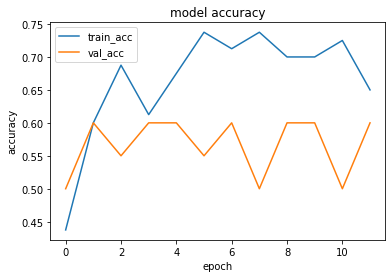

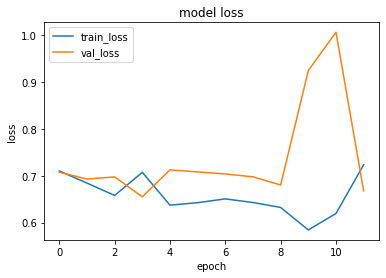

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.47061625]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_3.mov is [[0.5050027]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.5160972]]


1it [00:00, 14266.34it/s]


prediction for video control_1.mov is [[0.44662413]]


1it [00:00, 16131.94it/s]


prediction for video control_2.mov is [[0.43794298]]


1it [00:00, 15592.21it/s]


prediction for video control_3.mov is [[0.43470418]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 161ms/step - loss: 0.6965 - accuracy: 0.5500 - precision: 0.5323 - recall: 0.8250 - val_loss: 0.6502 - val_accuracy: 0.7500 - val_precision: 0.8571 - val_recall: 0.6000
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6673 - accuracy: 0.6750 - precision: 0.7692 - recall: 0.5000 - val_loss: 0.5378 - val_accuracy: 0.7000 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6645 - accuracy: 0.5625 - precision: 0.5362 - recall: 0.9250 - val_loss: 0.5151 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 130ms/step - loss: 0.7188 - accuracy: 0.6500 - precision: 0.7000 - recall: 0.5250 - val_loss: 0.6765 - val_accuracy: 0.6500 - val_precision: 1.0000 - val_recall: 0.3000
Epoch 5/75


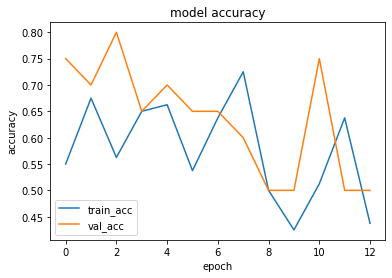

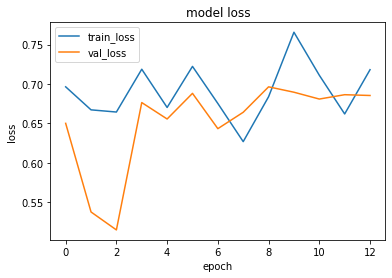

1it [00:00, 11748.75it/s]


prediction for video armflapping_1.mov is [[0.5468915]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_3.mov is [[0.54199064]]


1it [00:00, 13189.64it/s]


prediction for video armflapping_2.mov is [[0.5507109]]


1it [00:00, 14513.16it/s]


prediction for video control_1.mov is [[0.54619306]]


1it [00:00, 13486.51it/s]


prediction for video control_2.mov is [[0.54592526]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.5458826]]


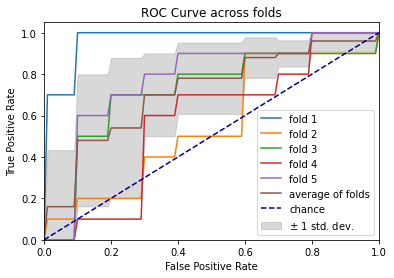

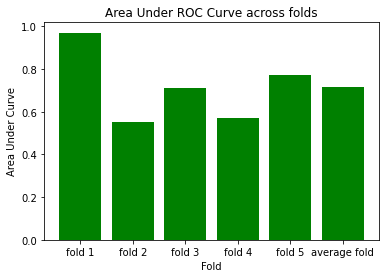

(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 152ms/step - loss: 0.7210 - accuracy: 0.5500 - precision: 0.5278 - recall: 0.9500 - val_loss: 0.6728 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6724 - accuracy: 0.5750 - precision: 0.5455 - recall: 0.9000 - val_loss: 0.6435 - val_accuracy: 0.6000 - val_precision: 0.5556 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6491 - accuracy: 0.5750 - precision: 0.5455 - recall: 0.9000 - val_loss: 0.6276 - val_accuracy: 0.6000 - val_precision: 0.5556 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6362 - accuracy: 0.6375 - precision: 0.6222 - recall: 0.7000 - val_loss: 0.5825 - val_accuracy: 0.9000 - val_precision: 0.9000 - val_recall: 0.9000
Epoch 5/75
3/3 [==============================] - 0s 122ms/step 

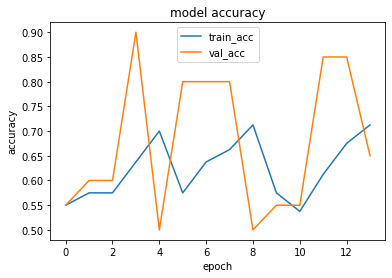

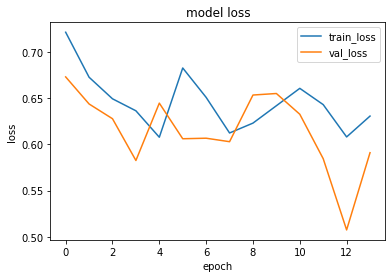

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.5058533]]


1it [00:00, 13357.66it/s]


prediction for video armflapping_3.mov is [[0.51855963]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_2.mov is [[0.5222546]]


1it [00:00, 17189.77it/s]


prediction for video control_1.mov is [[0.4946808]]


1it [00:00, 14513.16it/s]


prediction for video control_2.mov is [[0.48999676]]


1it [00:00, 14665.40it/s]


prediction for video control_3.mov is [[0.4890188]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6852 - accuracy: 0.5500 - precision: 0.5526 - recall: 0.5250 - val_loss: 0.7200 - val_accuracy: 0.5500 - val_precision: 0.5294 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 193ms/step - loss: 0.8233 - accuracy: 0.6375 - precision: 0.5902 - recall: 0.9000 - val_loss: 0.6957 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6722 - accuracy: 0.5750 - precision: 0.5405 - recall: 1.0000 - val_loss: 0.6648 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6856 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.6250 - val_loss: 0.6783 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoc

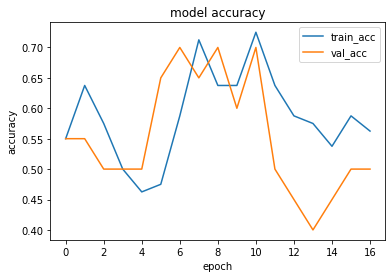

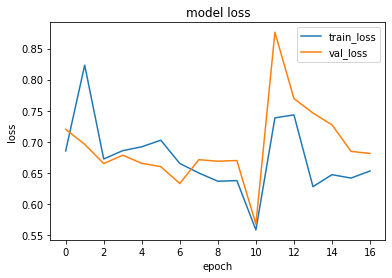

1it [00:00, 14315.03it/s]


prediction for video armflapping_1.mov is [[0.55463606]]


1it [00:00, 16448.25it/s]


prediction for video armflapping_3.mov is [[0.57852054]]


1it [00:00, 13357.66it/s]


prediction for video armflapping_2.mov is [[0.56218284]]


1it [00:00, 14463.12it/s]


prediction for video control_1.mov is [[0.5533543]]


1it [00:00, 17260.51it/s]


prediction for video control_2.mov is [[0.5536796]]


1it [00:00, 11915.64it/s]


prediction for video control_3.mov is [[0.5534219]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 163ms/step - loss: 0.6792 - accuracy: 0.5750 - precision: 0.5455 - recall: 0.9000 - val_loss: 0.6583 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6983 - accuracy: 0.6000 - precision: 0.7500 - recall: 0.3000 - val_loss: 0.7295 - val_accuracy: 0.5500 - val_precision: 0.5455 - val_recall: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6363 - accuracy: 0.7500 - precision: 0.7273 - recall: 0.8000 - val_loss: 0.7982 - val_accuracy: 0.4500 - val_precision: 0.4444 - val_recall: 0.4000
Epoch 4/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6103 - accuracy: 0.7125 - precision: 0.7297 - recall: 0.6750 - val_loss: 0.7105 - val_accuracy: 0.5500 - val_precision: 0.5385 - val_recall: 0.7000
Epoc

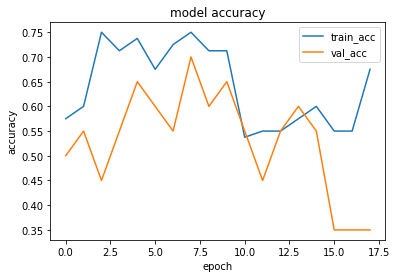

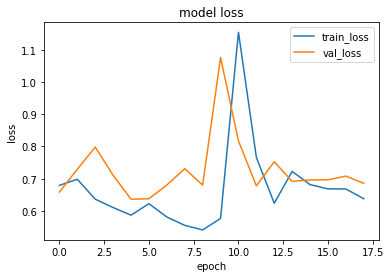

1it [00:00, 12300.01it/s]


prediction for video armflapping_1.mov is [[0.4293462]]


1it [00:00, 16912.52it/s]


prediction for video armflapping_3.mov is [[0.4915434]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.44776425]]


1it [00:00, 15420.24it/s]


prediction for video control_1.mov is [[0.4263443]]


1it [00:00, 15827.56it/s]


prediction for video control_2.mov is [[0.42571867]]


1it [00:00, 11781.75it/s]


prediction for video control_3.mov is [[0.4256832]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6850 - accuracy: 0.5125 - precision: 0.5122 - recall: 0.5250 - val_loss: 0.6832 - val_accuracy: 0.6500 - val_precision: 0.5882 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 159ms/step - loss: 0.7056 - accuracy: 0.5375 - precision: 0.5254 - recall: 0.7750 - val_loss: 0.6465 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.1000
Epoch 3/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6658 - accuracy: 0.6000 - precision: 0.8333 - recall: 0.2500 - val_loss: 0.6373 - val_accuracy: 0.5500 - val_precision: 0.6667 - val_recall: 0.2000
Epoch 4/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6469 - accuracy: 0.7125 - precision: 0.8400 - recall: 0.5250 - val_loss: 0.6184 - val_accuracy: 0.7000 - val_precision: 0.8333 - val_recall: 0.5000
Epoch 5/75
3

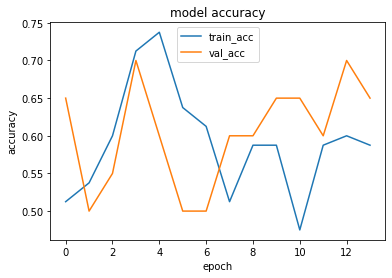

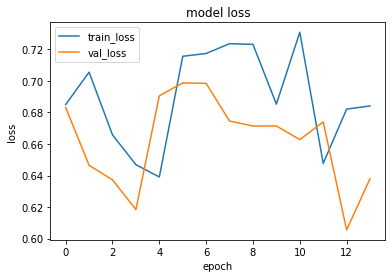

1it [00:00, 13888.42it/s]


prediction for video armflapping_1.mov is [[0.3789609]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_3.mov is [[0.44362965]]


1it [00:00, 13148.29it/s]


prediction for video armflapping_2.mov is [[0.4234623]]


1it [00:00, 14315.03it/s]


prediction for video control_1.mov is [[0.36308694]]


1it [00:00, 14463.12it/s]


prediction for video control_2.mov is [[0.35817796]]


1it [00:00, 15196.75it/s]


prediction for video control_3.mov is [[0.3552834]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6877 - accuracy: 0.5250 - precision: 0.5152 - recall: 0.8500 - val_loss: 0.7003 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.1000
Epoch 2/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6634 - accuracy: 0.5500 - precision: 0.5556 - recall: 0.5000 - val_loss: 0.7936 - val_accuracy: 0.4500 - val_precision: 0.4706 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6527 - accuracy: 0.6250 - precision: 0.5833 - recall: 0.8750 - val_loss: 0.6974 - val_accuracy: 0.4500 - val_precision: 0.4737 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 118ms/step - loss: 0.6501 - accuracy: 0.5375 - precision: 0.5211 - recall: 0.9250 - val_loss: 0.6428 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 5/75
3

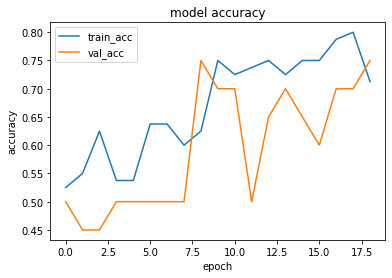

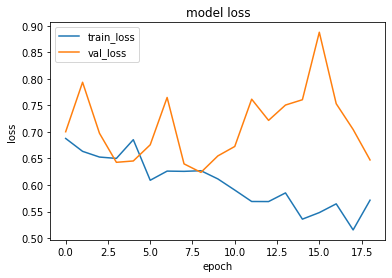

1it [00:00, 14074.85it/s]


prediction for video armflapping_1.mov is [[0.403471]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_3.mov is [[0.58337784]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_2.mov is [[0.6405662]]


1it [00:00, 14513.16it/s]


prediction for video control_1.mov is [[0.31901848]]


1it [00:00, 14513.16it/s]


prediction for video control_2.mov is [[0.3033467]]


1it [00:00, 15363.75it/s]


prediction for video control_3.mov is [[0.29585066]]


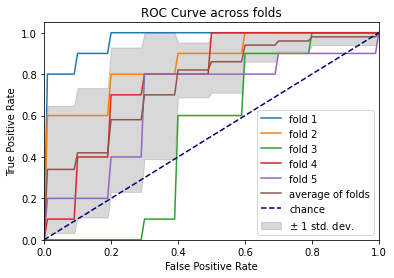

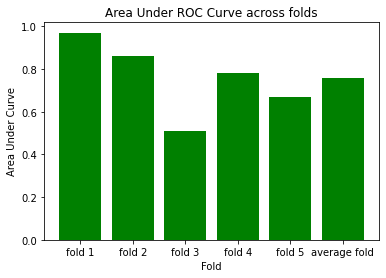

(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 150ms/step - loss: 0.7304 - accuracy: 0.4875 - precision: 0.4921 - recall: 0.7750 - val_loss: 0.6858 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6784 - accuracy: 0.7250 - precision: 0.6667 - recall: 0.9000 - val_loss: 0.6726 - val_accuracy: 0.6500 - val_precision: 0.7143 - val_recall: 0.5000
Epoch 3/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6687 - accuracy: 0.6750 - precision: 0.6944 - recall: 0.6250 - val_loss: 0.6340 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6432 - accuracy: 0.6125 - precision: 0.5763 - recall: 0.8500 - val_loss: 0.5963 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 5/75
3/3 [==============================] - 0s 144ms/step 

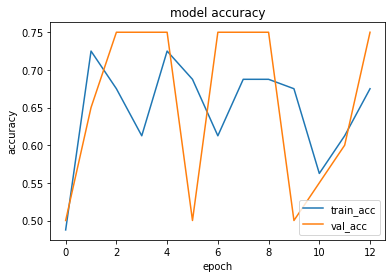

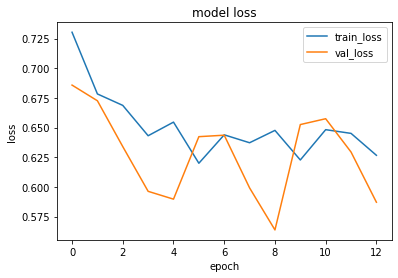

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.52088255]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_3.mov is [[0.53343403]]


1it [00:00, 12483.05it/s]


prediction for video armflapping_2.mov is [[0.5450443]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.5059665]]


1it [00:00, 14266.34it/s]


prediction for video control_2.mov is [[0.50114554]]


1it [00:00, 13530.01it/s]


prediction for video control_3.mov is [[0.4985522]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 162ms/step - loss: 0.6948 - accuracy: 0.5875 - precision: 0.5493 - recall: 0.9750 - val_loss: 0.6606 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 154ms/step - loss: 0.7707 - accuracy: 0.5250 - precision: 1.0000 - recall: 0.0500 - val_loss: 0.6585 - val_accuracy: 0.6500 - val_precision: 1.0000 - val_recall: 0.3000
Epoch 3/75
3/3 [==============================] - 0s 164ms/step - loss: 0.6778 - accuracy: 0.7000 - precision: 0.7667 - recall: 0.5750 - val_loss: 0.6615 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6796 - accuracy: 0.5375 - precision: 0.5205 - recall: 0.9500 - val_loss: 0.6575 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoc

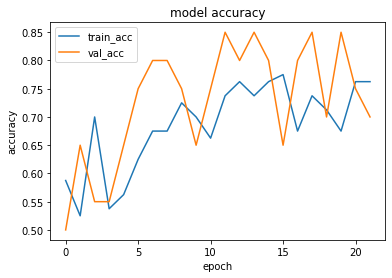

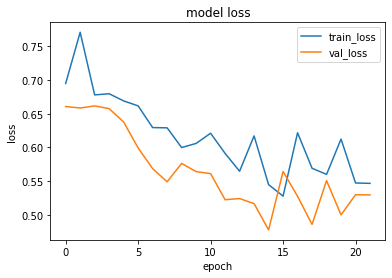

1it [00:00, 13706.88it/s]


prediction for video armflapping_1.mov is [[0.46233645]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_3.mov is [[0.5792231]]


1it [00:00, 14027.77it/s]


prediction for video armflapping_2.mov is [[0.57877487]]


1it [00:00, 15196.75it/s]


prediction for video control_1.mov is [[0.23533082]]


1it [00:00, 14716.86it/s]


prediction for video control_2.mov is [[0.2059376]]


1it [00:00, 18157.16it/s]


prediction for video control_3.mov is [[0.2532699]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 158ms/step - loss: 0.6944 - accuracy: 0.5375 - precision: 0.5484 - recall: 0.4250 - val_loss: 0.6526 - val_accuracy: 0.8500 - val_precision: 0.8182 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 151ms/step - loss: 0.6725 - accuracy: 0.5750 - precision: 0.6071 - recall: 0.4250 - val_loss: 0.6288 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 154ms/step - loss: 0.7071 - accuracy: 0.5625 - precision: 0.5373 - recall: 0.9000 - val_loss: 0.6454 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6764 - accuracy: 0.5500 - precision: 0.5323 - recall: 0.8250 - val_loss: 0.6446 - val_accuracy: 0.7000 - val_precision: 0.8333 - val_recall: 0.5000
Epoch 5/75
3

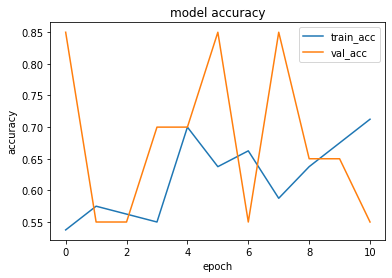

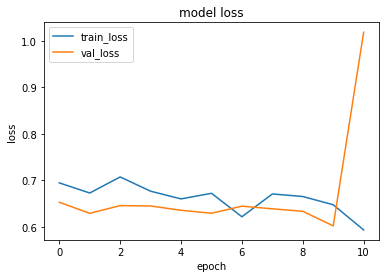

1it [00:00, 13357.66it/s]


prediction for video armflapping_1.mov is [[0.88259804]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_3.mov is [[0.88546336]]


1it [00:00, 16320.25it/s]


prediction for video armflapping_2.mov is [[0.8871669]]


1it [00:00, 16131.94it/s]


prediction for video control_1.mov is [[0.87743753]]


1it [00:00, 16320.25it/s]


prediction for video control_2.mov is [[0.08779344]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.85298944]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6859 - accuracy: 0.5375 - precision: 0.5238 - recall: 0.8250 - val_loss: 1.0306 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 150ms/step - loss: 0.7614 - accuracy: 0.5250 - precision: 0.5833 - recall: 0.1750 - val_loss: 0.6862 - val_accuracy: 0.4500 - val_precision: 0.4706 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6754 - accuracy: 0.5625 - precision: 0.5342 - recall: 0.9750 - val_loss: 0.6794 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6768 - accuracy: 0.5625 - precision: 0.5333 - recall: 1.0000 - val_loss: 0.6752 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.9000
Epo

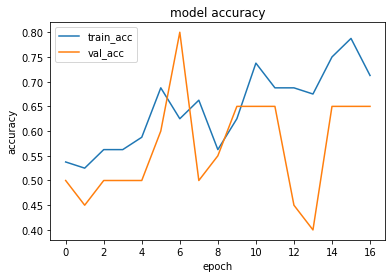

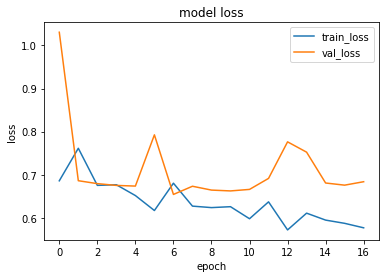

1it [00:00, 15196.75it/s]


prediction for video armflapping_1.mov is [[0.5162234]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.55074906]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_2.mov is [[0.59056556]]


1it [00:00, 16070.13it/s]


prediction for video control_1.mov is [[0.47527808]]


1it [00:00, 14266.34it/s]


prediction for video control_2.mov is [[0.46088794]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.45590013]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 167ms/step - loss: 0.7196 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.1500 - val_loss: 0.6879 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.4000
Epoch 2/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6614 - accuracy: 0.7125 - precision: 0.7297 - recall: 0.6750 - val_loss: 0.8120 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6259 - accuracy: 0.6000 - precision: 0.5606 - recall: 0.9250 - val_loss: 0.6744 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6328 - accuracy: 0.7125 - precision: 0.8696 - recall: 0.5000 - val_loss: 0.6866 - val_accuracy: 0.6500 - val_precision: 0.7143 - val_recall: 0.5000
Epoch 5/75


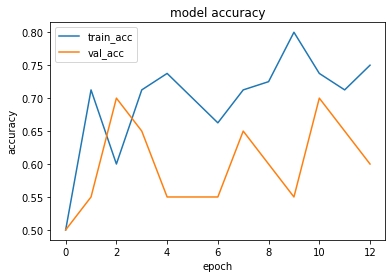

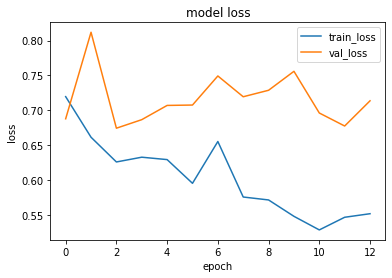

1it [00:00, 14716.86it/s]


prediction for video armflapping_1.mov is [[0.3626147]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.5686438]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_2.mov is [[0.61437106]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.26254162]]


1it [00:00, 10407.70it/s]


prediction for video control_2.mov is [[0.24494722]]


1it [00:00, 16320.25it/s]


prediction for video control_3.mov is [[0.24073368]]


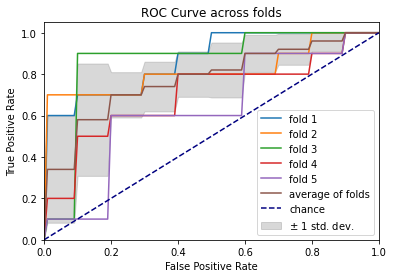

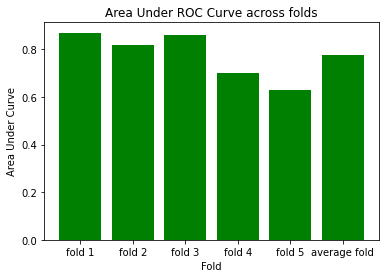

(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6813 - accuracy: 0.5375 - precision: 0.5254 - recall: 0.7750 - val_loss: 0.8589 - val_accuracy: 0.2500 - val_precision: 0.1429 - val_recall: 0.1000
Epoch 2/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6849 - accuracy: 0.6375 - precision: 0.6000 - recall: 0.8250 - val_loss: 0.6477 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6592 - accuracy: 0.5625 - precision: 0.5342 - recall: 0.9750 - val_loss: 0.6677 - val_accuracy: 0.5500 - val_precision: 0.5294 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6559 - accuracy: 0.6625 - precision: 0.6757 - recall: 0.6250 - val_loss: 0.7298 - val_accuracy: 0.8000 - val_precision: 1.0000 - val_recall: 0.6000
Epoch 5/75
3/3 [==============================] - 0s 131ms/step 

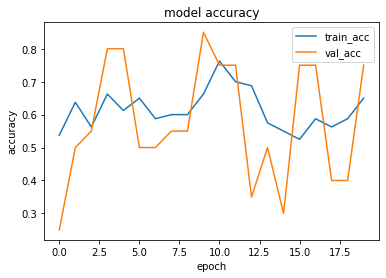

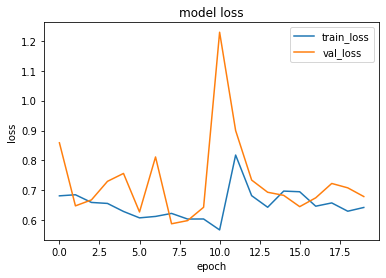

1it [00:00, 14266.34it/s]


prediction for video armflapping_1.mov is [[0.4993868]]


1it [00:00, 12192.74it/s]


prediction for video armflapping_3.mov is [[0.53866804]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.51875407]]


1it [00:00, 15592.21it/s]


prediction for video control_1.mov is [[0.48566827]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.47846833]]


1it [00:00, 15420.24it/s]


prediction for video control_3.mov is [[0.47801876]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 1s 187ms/step - loss: 0.7044 - accuracy: 0.4750 - precision: 0.4545 - recall: 0.2500 - val_loss: 0.6859 - val_accuracy: 0.7000 - val_precision: 0.8333 - val_recall: 0.5000
Epoch 2/75
3/3 [==============================] - 1s 182ms/step - loss: 0.6882 - accuracy: 0.4750 - precision: 0.4833 - recall: 0.7250 - val_loss: 0.6513 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 1s 181ms/step - loss: 0.6705 - accuracy: 0.6125 - precision: 0.6667 - recall: 0.4500 - val_loss: 0.6174 - val_accuracy: 0.8000 - val_precision: 0.7143 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 169ms/step - loss: 0.6379 - accuracy: 0.6750 - precision: 0.6346 - recall: 0.8250 - val_loss: 0.5149 - val_accuracy: 0.8000 - val_precision: 0.7500 - val_recall: 0.9000
Epoch 5/75


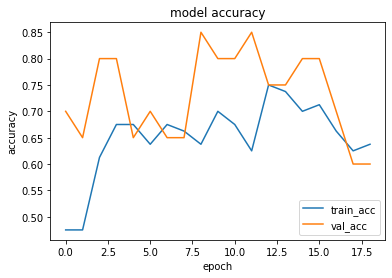

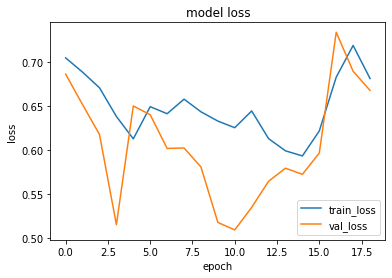

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.43194747]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_3.mov is [[0.5755304]]


1it [00:00, 11397.57it/s]


prediction for video armflapping_2.mov is [[0.48140854]]


1it [00:00, 14315.03it/s]


prediction for video control_1.mov is [[0.42814115]]


1it [00:00, 17924.38it/s]


prediction for video control_2.mov is [[0.44288412]]


1it [00:00, 15650.39it/s]


prediction for video control_3.mov is [[0.44215047]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6909 - accuracy: 0.5750 - precision: 0.5652 - recall: 0.6500 - val_loss: 0.6643 - val_accuracy: 0.6000 - val_precision: 0.5833 - val_recall: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6065 - accuracy: 0.7250 - precision: 0.6800 - recall: 0.8500 - val_loss: 0.9075 - val_accuracy: 0.5500 - val_precision: 0.6667 - val_recall: 0.2000
Epoch 3/75
3/3 [==============================] - 0s 120ms/step - loss: 0.6825 - accuracy: 0.6000 - precision: 0.6538 - recall: 0.4250 - val_loss: 0.6672 - val_accuracy: 0.5500 - val_precision: 0.5385 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6007 - accuracy: 0.7250 - precision: 0.6731 - recall: 0.8750 - val_loss: 0.6305 - val_accuracy: 0.6000 - val_precision: 0.5714 - val_recall: 0.8000
Epoch 5/75


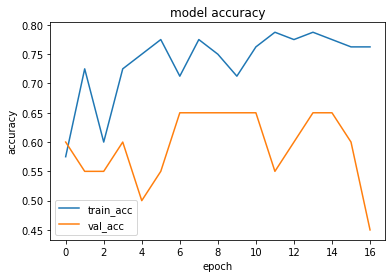

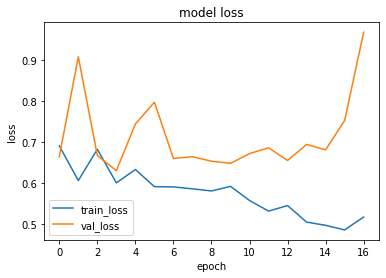

1it [00:00, 15196.75it/s]


prediction for video armflapping_1.mov is [[0.2348727]]


1it [00:00, 14873.42it/s]


prediction for video armflapping_3.mov is [[0.7572863]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_2.mov is [[0.47367328]]


1it [00:00, 15141.89it/s]


prediction for video control_1.mov is [[0.21664938]]


1it [00:00, 13842.59it/s]


prediction for video control_2.mov is [[0.22132638]]


1it [00:00, 14122.24it/s]


prediction for video control_3.mov is [[0.21676871]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 129ms/step - loss: 0.7036 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.9000 - val_loss: 0.6944 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.4000
Epoch 2/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6801 - accuracy: 0.6250 - precision: 0.7500 - recall: 0.3750 - val_loss: 0.6922 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.3000
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6606 - accuracy: 0.7125 - precision: 0.7429 - recall: 0.6500 - val_loss: 0.7041 - val_accuracy: 0.6000 - val_precision: 0.5714 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6396 - accuracy: 0.7125 - precision: 0.6545 - recall: 0.9000 - val_loss: 0.7216 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 5/75


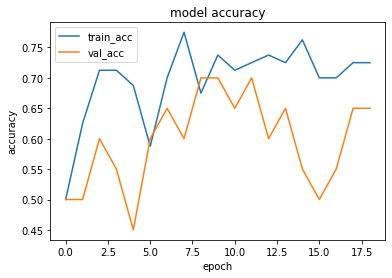

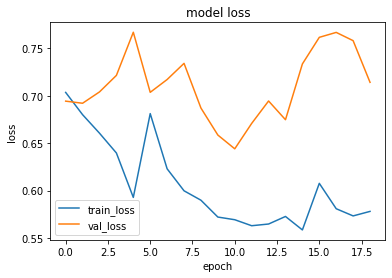

1it [00:00, 12300.01it/s]


prediction for video armflapping_1.mov is [[0.4616004]]


1it [00:00, 15887.52it/s]


prediction for video armflapping_3.mov is [[0.54610157]]


1it [00:00, 22192.08it/s]


prediction for video armflapping_2.mov is [[0.5848749]]


1it [00:00, 17549.39it/s]


prediction for video control_1.mov is [[0.35448587]]


1it [00:00, 14768.68it/s]


prediction for video control_2.mov is [[0.3260553]]


1it [00:00, 14873.42it/s]


prediction for video control_3.mov is [[0.3140915]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 152ms/step - loss: 0.7199 - accuracy: 0.5500 - precision: 0.5286 - recall: 0.9250 - val_loss: 0.6522 - val_accuracy: 0.6000 - val_precision: 0.5556 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6584 - accuracy: 0.6125 - precision: 0.6098 - recall: 0.6250 - val_loss: 0.6471 - val_accuracy: 0.6000 - val_precision: 1.0000 - val_recall: 0.2000
Epoch 3/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6665 - accuracy: 0.6375 - precision: 0.7619 - recall: 0.4000 - val_loss: 0.6436 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6441 - accuracy: 0.7125 - precision: 0.7429 - recall: 0.6500 - val_loss: 0.6207 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 5/75
3

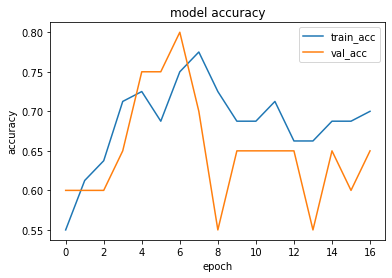

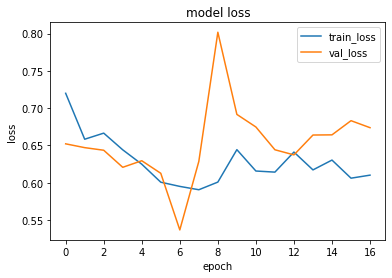

1it [00:00, 14513.16it/s]


prediction for video armflapping_1.mov is [[0.36595967]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_3.mov is [[0.5576639]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.59566945]]


1it [00:00, 14315.03it/s]


prediction for video control_1.mov is [[0.31414902]]


1it [00:00, 14665.40it/s]


prediction for video control_2.mov is [[0.3024304]]


1it [00:00, 14217.98it/s]


prediction for video control_3.mov is [[0.30368054]]


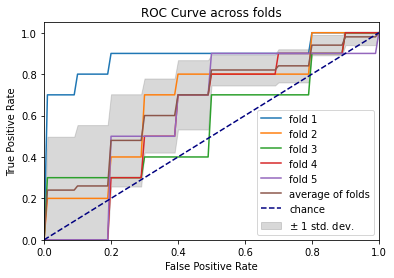

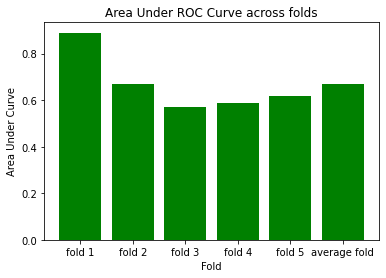

(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6738 - accuracy: 0.5500 - precision: 0.5333 - recall: 0.8000 - val_loss: 0.7322 - val_accuracy: 0.5500 - val_precision: 0.5294 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6475 - accuracy: 0.6000 - precision: 0.5645 - recall: 0.8750 - val_loss: 0.6522 - val_accuracy: 0.7000 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6586 - accuracy: 0.6875 - precision: 0.6829 - recall: 0.7000 - val_loss: 0.6497 - val_accuracy: 0.8000 - val_precision: 0.8000 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6221 - accuracy: 0.6875 - precision: 0.7273 - recall: 0.6000 - val_loss: 0.7765 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.9000
Epoch 5/75
3/3 [==============================] - 0s 132ms/step 

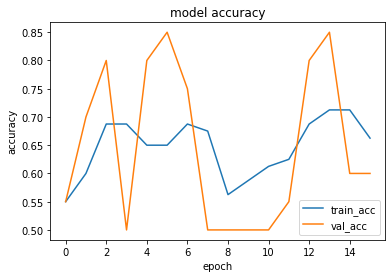

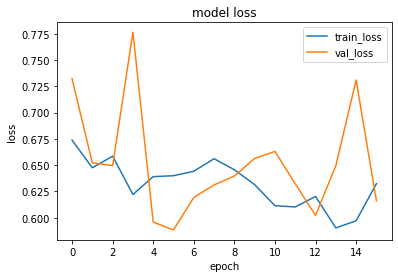

1it [00:00, 14716.86it/s]


prediction for video armflapping_1.mov is [[0.43879893]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_3.mov is [[0.46930555]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_2.mov is [[0.5214497]]


1it [00:00, 14513.16it/s]


prediction for video control_1.mov is [[0.39308447]]


1it [00:00, 14665.40it/s]


prediction for video control_2.mov is [[0.37926564]]


1it [00:00, 15592.21it/s]


prediction for video control_3.mov is [[0.36426368]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6855 - accuracy: 0.5625 - precision: 0.5352 - recall: 0.9500 - val_loss: 0.6510 - val_accuracy: 0.5500 - val_precision: 1.0000 - val_recall: 0.1000
Epoch 2/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6743 - accuracy: 0.5125 - precision: 0.5385 - recall: 0.1750 - val_loss: 0.6390 - val_accuracy: 0.6500 - val_precision: 0.5882 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6684 - accuracy: 0.5875 - precision: 0.5507 - recall: 0.9500 - val_loss: 0.6416 - val_accuracy: 0.6500 - val_precision: 0.6667 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6385 - accuracy: 0.7375 - precision: 0.7317 - recall: 0.7500 - val_loss: 0.5598 - val_accuracy: 0.8000 - val_precision: 0.8750 - val_recall: 0.7000
Epoch 5/75


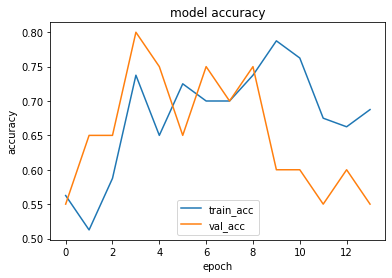

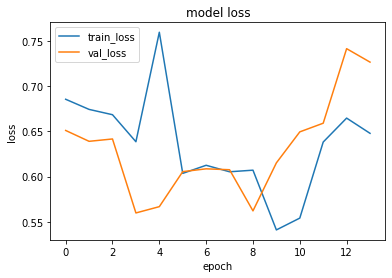

1it [00:00, 14716.86it/s]


prediction for video armflapping_1.mov is [[0.32016855]]


1it [00:00, 18236.10it/s]


prediction for video armflapping_3.mov is [[0.3995695]]


1it [00:00, 13148.29it/s]


prediction for video armflapping_2.mov is [[0.39028746]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.25686115]]


1it [00:00, 13189.64it/s]


prediction for video control_2.mov is [[0.2479603]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.23117429]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 1s 157ms/step - loss: 0.6893 - accuracy: 0.5500 - precision: 0.5526 - recall: 0.5250 - val_loss: 0.6410 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6609 - accuracy: 0.5750 - precision: 0.5455 - recall: 0.9000 - val_loss: 0.5790 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 127ms/step - loss: 0.7727 - accuracy: 0.7000 - precision: 0.7500 - recall: 0.6000 - val_loss: 0.6419 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6709 - accuracy: 0.5250 - precision: 0.5132 - recall: 0.9750 - val_loss: 0.6543 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 5/75


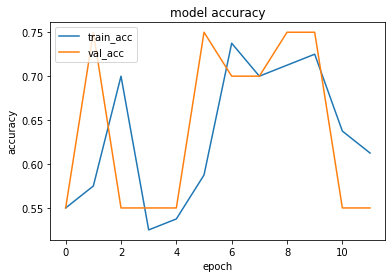

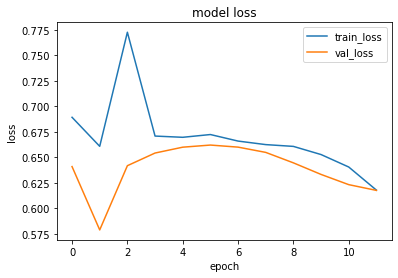

1it [00:00, 13315.25it/s]


prediction for video armflapping_1.mov is [[0.5374936]]


1it [00:00, 18893.26it/s]


prediction for video armflapping_3.mov is [[0.5714198]]


1it [00:00, 14074.85it/s]


prediction for video armflapping_2.mov is [[0.5788416]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.5152638]]


1it [00:00, 16710.37it/s]


prediction for video control_2.mov is [[0.5082261]]


1it [00:00, 13530.01it/s]


prediction for video control_3.mov is [[0.5043188]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6894 - accuracy: 0.5750 - precision: 0.5625 - recall: 0.6750 - val_loss: 0.6173 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 143ms/step - loss: 0.6731 - accuracy: 0.6375 - precision: 0.6410 - recall: 0.6250 - val_loss: 0.5940 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 146ms/step - loss: 0.6442 - accuracy: 0.6500 - precision: 0.6154 - recall: 0.8000 - val_loss: 0.7068 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 4/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6590 - accuracy: 0.7250 - precision: 0.6957 - recall: 0.8000 - val_loss: 0.6982 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 5/75
3

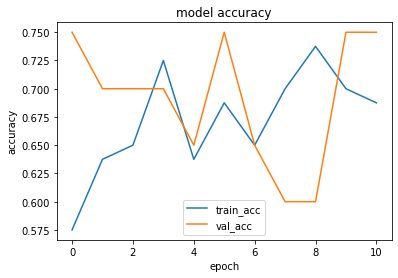

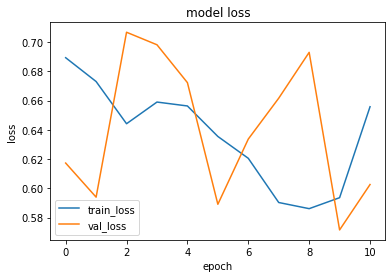

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.46382475]]


1it [00:00, 14873.42it/s]


prediction for video armflapping_3.mov is [[0.5405719]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.5278864]]


1it [00:00, 14873.42it/s]


prediction for video control_1.mov is [[0.43351585]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.42253596]]


1it [00:00, 15141.89it/s]


prediction for video control_3.mov is [[0.41964328]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6894 - accuracy: 0.4625 - precision: 0.4615 - recall: 0.4500 - val_loss: 0.7058 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6542 - accuracy: 0.5625 - precision: 0.5333 - recall: 1.0000 - val_loss: 0.7145 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6355 - accuracy: 0.5500 - precision: 0.5278 - recall: 0.9500 - val_loss: 0.7769 - val_accuracy: 0.7000 - val_precision: 0.6429 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 148ms/step - loss: 0.6274 - accuracy: 0.6750 - precision: 0.6750 - recall: 0.6750 - val_loss: 0.7149 - val_accuracy: 0.5500 - val_precision: 0.5714 - val_recall: 0.4000
Epoch 5/75


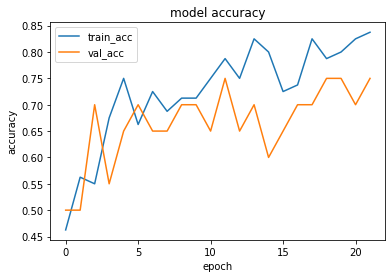

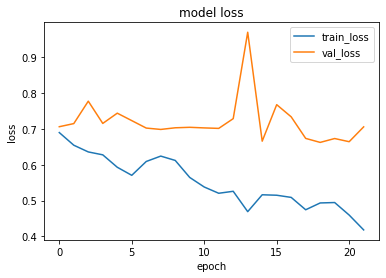

1it [00:00, 14716.86it/s]


prediction for video armflapping_1.mov is [[0.6026355]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.84018016]]


1it [00:00, 14873.42it/s]


prediction for video armflapping_2.mov is [[0.8326678]]


1it [00:00, 15827.56it/s]


prediction for video control_1.mov is [[0.30346107]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.272495]]


1it [00:00, 18893.26it/s]


prediction for video control_3.mov is [[0.27637666]]


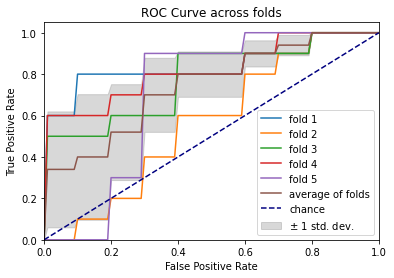

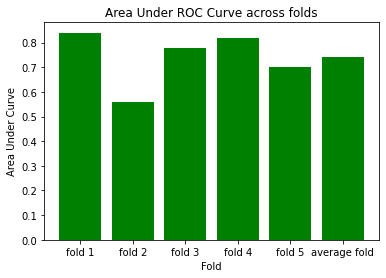

(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 154ms/step - loss: 0.6803 - accuracy: 0.6875 - precision: 0.6667 - recall: 0.7500 - val_loss: 0.6874 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 121ms/step - loss: 0.6742 - accuracy: 0.6000 - precision: 0.5556 - recall: 1.0000 - val_loss: 0.6412 - val_accuracy: 0.5500 - val_precision: 1.0000 - val_recall: 0.1000
Epoch 3/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6929 - accuracy: 0.5250 - precision: 0.7500 - recall: 0.0750 - val_loss: 0.6817 - val_accuracy: 0.5500 - val_precision: 1.0000 - val_recall: 0.1000
Epoch 4/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6749 - accuracy: 0.5375 - precision: 0.6667 - recall: 0.1500 - val_loss: 0.6795 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.2000
Epoch 5/75
3/3 [==============================] - 0s 144ms/step 

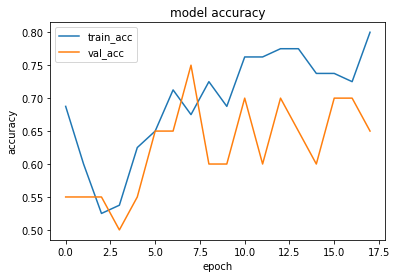

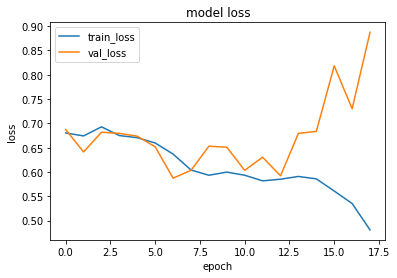

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.32823628]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_3.mov is [[0.5172503]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_2.mov is [[0.5376182]]


1it [00:00, 17549.39it/s]


prediction for video control_1.mov is [[0.20290524]]


1it [00:00, 14873.42it/s]


prediction for video control_2.mov is [[0.17102844]]


1it [00:00, 14563.56it/s]


prediction for video control_3.mov is [[0.25458616]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 163ms/step - loss: 0.6908 - accuracy: 0.5375 - precision: 0.6667 - recall: 0.1500 - val_loss: 0.7311 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6768 - accuracy: 0.5750 - precision: 0.5417 - recall: 0.9750 - val_loss: 0.6530 - val_accuracy: 0.7500 - val_precision: 0.8571 - val_recall: 0.6000
Epoch 3/75
3/3 [==============================] - 0s 150ms/step - loss: 0.7481 - accuracy: 0.5750 - precision: 0.6875 - recall: 0.2750 - val_loss: 0.6566 - val_accuracy: 0.7000 - val_precision: 0.8333 - val_recall: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 186ms/step - loss: 0.6475 - accuracy: 0.7375 - precision: 0.7714 - recall: 0.6750 - val_loss: 0.6628 - val_accuracy: 0.7000 - val_precision: 0.7500 - val_recall: 0.6000
Epoch 5/75


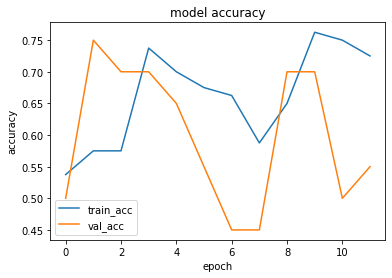

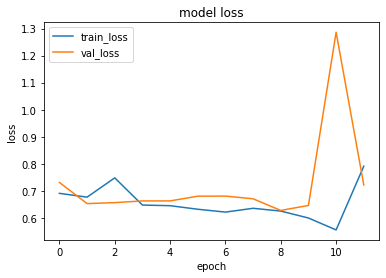

1it [00:00, 13706.88it/s]


prediction for video armflapping_1.mov is [[0.6621848]]


1it [00:00, 17772.47it/s]


prediction for video armflapping_3.mov is [[0.7521062]]


1it [00:00, 12826.62it/s]


prediction for video armflapping_2.mov is [[0.7535454]]


1it [00:00, 12052.60it/s]


prediction for video control_1.mov is [[0.6557437]]


1it [00:00, 16131.94it/s]


prediction for video control_2.mov is [[0.6639528]]


1it [00:00, 14873.42it/s]


prediction for video control_3.mov is [[0.6166198]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6932 - accuracy: 0.5250 - precision: 0.5833 - recall: 0.1750 - val_loss: 0.6702 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 135ms/step - loss: 0.6525 - accuracy: 0.5625 - precision: 0.5342 - recall: 0.9750 - val_loss: 0.8085 - val_accuracy: 0.6000 - val_precision: 1.0000 - val_recall: 0.2000
Epoch 3/75
3/3 [==============================] - 0s 140ms/step - loss: 0.7593 - accuracy: 0.5250 - precision: 0.5714 - recall: 0.2000 - val_loss: 0.6546 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6663 - accuracy: 0.5500 - precision: 0.5270 - recall: 0.9750 - val_loss: 0.6578 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 5/75
3

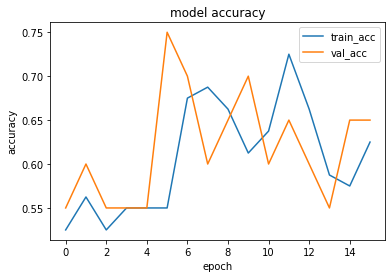

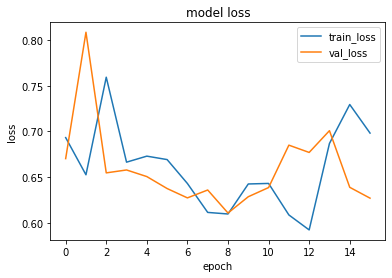

1it [00:00, 12192.74it/s]


prediction for video armflapping_1.mov is [[0.45224333]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.48054448]]


1it [00:00, 15196.75it/s]


prediction for video armflapping_2.mov is [[0.4584862]]


1it [00:00, 14266.34it/s]


prediction for video control_1.mov is [[0.4340558]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.43406945]]


1it [00:00, 15420.24it/s]


prediction for video control_3.mov is [[0.41492146]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 145ms/step - loss: 0.7017 - accuracy: 0.4625 - precision: 0.4444 - recall: 0.3000 - val_loss: 0.6722 - val_accuracy: 0.8000 - val_precision: 0.7143 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6797 - accuracy: 0.6625 - precision: 0.6857 - recall: 0.6000 - val_loss: 0.6442 - val_accuracy: 0.7500 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6939 - accuracy: 0.6250 - precision: 0.5758 - recall: 0.9500 - val_loss: 0.6382 - val_accuracy: 0.8000 - val_precision: 0.7143 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6594 - accuracy: 0.6375 - precision: 0.6897 - recall: 0.5000 - val_loss: 0.6361 - val_accuracy: 0.8000 - val_precision: 0.8750 - val_recall: 0.7000
Epoch 5/75


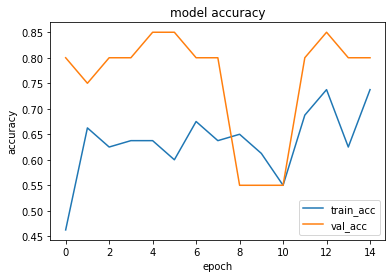

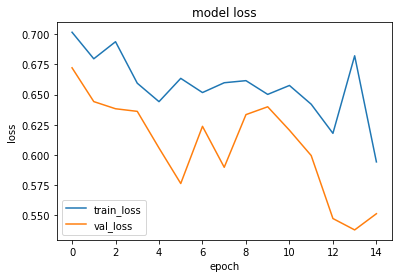

1it [00:00, 14716.86it/s]


prediction for video armflapping_1.mov is [[0.49992752]]


1it [00:00, 17848.10it/s]


prediction for video armflapping_3.mov is [[0.51299244]]


1it [00:00, 14266.34it/s]


prediction for video armflapping_2.mov is [[0.50934535]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.4894725]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.48516646]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.48558426]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 165ms/step - loss: 0.6952 - accuracy: 0.5250 - precision: 0.5217 - recall: 0.6000 - val_loss: 0.6685 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6803 - accuracy: 0.6000 - precision: 0.5588 - recall: 0.9500 - val_loss: 0.6576 - val_accuracy: 0.6000 - val_precision: 0.7500 - val_recall: 0.3000
Epoch 3/75
3/3 [==============================] - 0s 157ms/step - loss: 0.6942 - accuracy: 0.5125 - precision: 0.6667 - recall: 0.0500 - val_loss: 0.6430 - val_accuracy: 0.6500 - val_precision: 0.8000 - val_recall: 0.4000
Epoch 4/75
3/3 [==============================] - 0s 164ms/step - loss: 0.6448 - accuracy: 0.6375 - precision: 0.6774 - recall: 0.5250 - val_loss: 0.6579 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 5/75


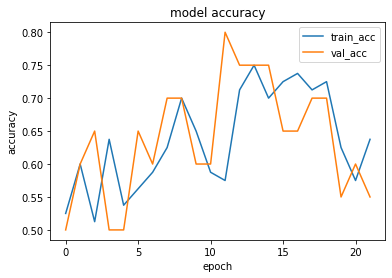

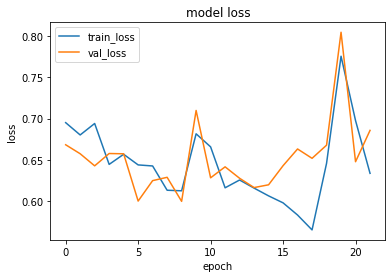

1it [00:00, 14873.42it/s]


prediction for video armflapping_1.mov is [[0.52417535]]


1it [00:00, 14873.42it/s]


prediction for video armflapping_3.mov is [[0.50025094]]


1it [00:00, 16131.94it/s]


prediction for video armflapping_2.mov is [[0.5256273]]


1it [00:00, 19239.93it/s]


prediction for video control_1.mov is [[0.46056008]]


1it [00:00, 16710.37it/s]


prediction for video control_2.mov is [[0.4592794]]


1it [00:00, 13706.88it/s]


prediction for video control_3.mov is [[0.524006]]


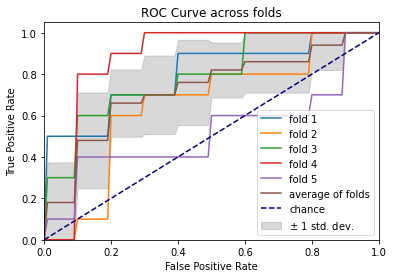

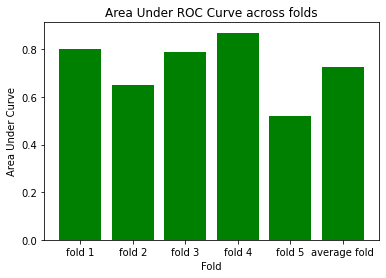

(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 170ms/step - loss: 0.6880 - accuracy: 0.5375 - precision: 0.5263 - recall: 0.7500 - val_loss: 0.6987 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6732 - accuracy: 0.6250 - precision: 0.6923 - recall: 0.4500 - val_loss: 0.6771 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6206 - accuracy: 0.7625 - precision: 0.7838 - recall: 0.7250 - val_loss: 0.6482 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 134ms/step - loss: 0.6098 - accuracy: 0.7125 - precision: 0.6667 - recall: 0.8500 - val_loss: 0.6461 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 5/75
3/3 [==============================] - 1s 153

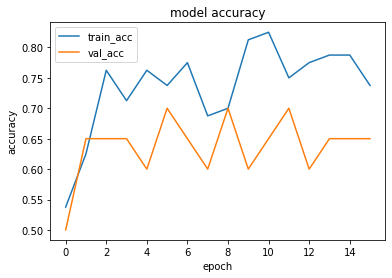

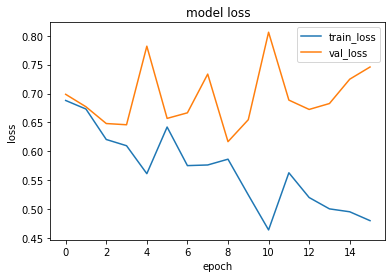

1it [00:00, 11618.57it/s]


prediction for video armflapping_1.mov is [[0.5102732]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_3.mov is [[0.51185465]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_2.mov is [[0.5133962]]


1it [00:00, 15363.75it/s]


prediction for video control_1.mov is [[0.47999096]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.46226773]]


1it [00:00, 16070.13it/s]


prediction for video control_3.mov is [[0.46366322]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6991 - accuracy: 0.4625 - precision: 0.3333 - recall: 0.0750 - val_loss: 0.6812 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 133ms/step - loss: 0.6842 - accuracy: 0.5250 - precision: 0.5139 - recall: 0.9250 - val_loss: 0.6624 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6372 - accuracy: 0.6500 - precision: 0.6250 - recall: 0.7500 - val_loss: 0.6906 - val_accuracy: 0.6500 - val_precision: 0.7143 - val_recall: 0.5000
Epoch 4/75
3/3 [==============================] - 0s 126ms/step - loss: 0.6310 - accuracy: 0.7250 - precision: 0.8000 - recall: 0.6000 - val_loss: 0.6632 - val_accuracy: 0.6500 - val_precision: 0.6667 - val_recall: 0.6000
Epoch 5/75


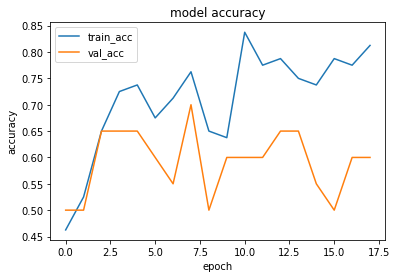

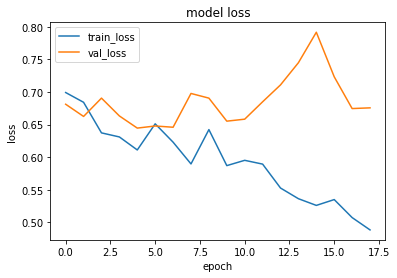

1it [00:00, 9118.05it/s]


prediction for video armflapping_1.mov is [[0.47523654]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_3.mov is [[0.6287607]]


1it [00:00, 13025.79it/s]


prediction for video armflapping_2.mov is [[0.68736506]]


1it [00:00, 3104.59it/s]


prediction for video control_1.mov is [[0.3823095]]


1it [00:00, 15887.52it/s]


prediction for video control_2.mov is [[0.35464215]]


1it [00:00, 14873.42it/s]


prediction for video control_3.mov is [[0.34298807]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 154ms/step - loss: 0.7089 - accuracy: 0.3500 - precision: 0.3800 - recall: 0.4750 - val_loss: 0.6829 - val_accuracy: 0.4000 - val_precision: 0.4000 - val_recall: 0.4000
Epoch 2/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6736 - accuracy: 0.5875 - precision: 0.5507 - recall: 0.9500 - val_loss: 0.6552 - val_accuracy: 0.6000 - val_precision: 0.5714 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6596 - accuracy: 0.5875 - precision: 0.5614 - recall: 0.8000 - val_loss: 0.6468 - val_accuracy: 0.6000 - val_precision: 0.5625 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6456 - accuracy: 0.6125 - precision: 0.5692 - recall: 0.9250 - val_loss: 0.6423 - val_accuracy: 0.6000 - val_precision: 0.5833 - val_recall: 0.7000
Epoch 5/75


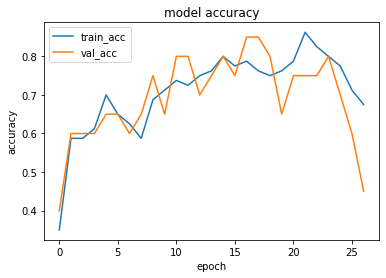

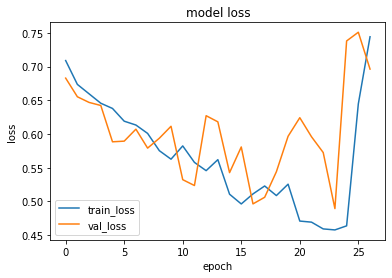

1it [00:00, 16710.37it/s]


prediction for video armflapping_1.mov is [[0.4060232]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_3.mov is [[0.54272884]]


1it [00:00, 13888.42it/s]


prediction for video armflapping_2.mov is [[0.60516346]]


1it [00:00, 14074.85it/s]


prediction for video control_1.mov is [[0.33304846]]


1it [00:00, 12865.96it/s]


prediction for video control_2.mov is [[0.30182672]]


1it [00:00, 15363.75it/s]


prediction for video control_3.mov is [[0.2994192]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 160ms/step - loss: 0.6910 - accuracy: 0.4750 - precision: 0.4167 - recall: 0.1250 - val_loss: 0.6723 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 162ms/step - loss: 0.6948 - accuracy: 0.5500 - precision: 0.5263 - recall: 1.0000 - val_loss: 0.6705 - val_accuracy: 0.8500 - val_precision: 0.8182 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 1s 207ms/step - loss: 0.6628 - accuracy: 0.6875 - precision: 0.6531 - recall: 0.8000 - val_loss: 0.6379 - val_accuracy: 0.8500 - val_precision: 1.0000 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 160ms/step - loss: 0.6372 - accuracy: 0.7000 - precision: 0.6739 - recall: 0.7750 - val_loss: 0.6086 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 5/75
3

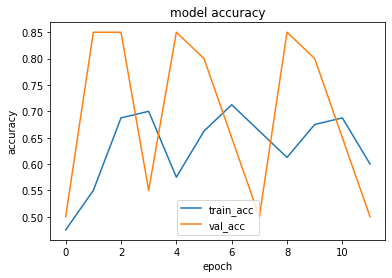

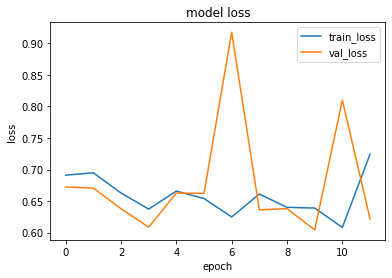

1it [00:00, 14665.40it/s]


prediction for video armflapping_1.mov is [[0.59447193]]


1it [00:00, 15592.21it/s]


prediction for video armflapping_3.mov is [[0.6134113]]


1it [00:00, 12826.62it/s]


prediction for video armflapping_2.mov is [[0.63970405]]


1it [00:00, 15650.39it/s]


prediction for video control_1.mov is [[0.56431043]]


1it [00:00, 18558.87it/s]


prediction for video control_2.mov is [[0.5520129]]


1it [00:00, 16980.99it/s]


prediction for video control_3.mov is [[0.5464132]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 1s 208ms/step - loss: 0.7341 - accuracy: 0.4500 - precision: 0.4667 - recall: 0.7000 - val_loss: 0.6687 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6871 - accuracy: 0.5375 - precision: 0.5246 - recall: 0.8000 - val_loss: 0.6555 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6833 - accuracy: 0.6125 - precision: 0.6667 - recall: 0.4500 - val_loss: 0.6490 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 118ms/step - loss: 0.6714 - accuracy: 0.6750 - precision: 0.7917 - recall: 0.4750 - val_loss: 0.5984 - val_accuracy: 0.7500 - val_precision: 0.8571 - val_recall: 0.6000
Epoch 5/75
3

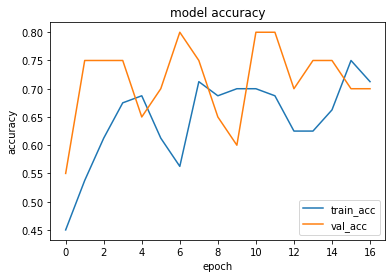

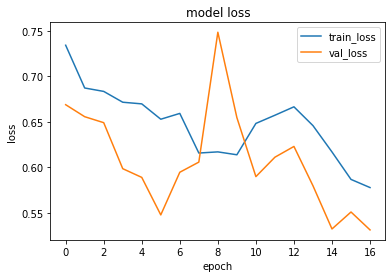

1it [00:00, 13486.51it/s]


prediction for video armflapping_1.mov is [[0.49065173]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_3.mov is [[0.63175577]]


1it [00:00, 13315.25it/s]


prediction for video armflapping_2.mov is [[0.62909967]]


1it [00:00, 15592.21it/s]


prediction for video control_1.mov is [[0.34142992]]


1it [00:00, 11244.78it/s]


prediction for video control_2.mov is [[0.28424272]]


1it [00:00, 15827.56it/s]


prediction for video control_3.mov is [[0.31335223]]


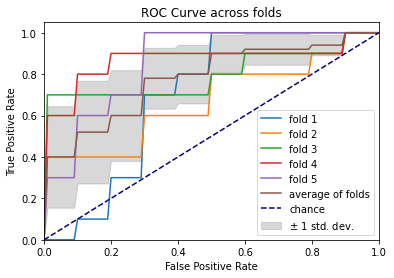

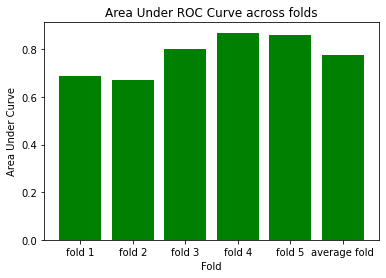

(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 171ms/step - loss: 0.6952 - accuracy: 0.4625 - precision: 0.4737 - recall: 0.6750 - val_loss: 0.7201 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 152ms/step - loss: 0.6793 - accuracy: 0.5625 - precision: 0.7273 - recall: 0.2000 - val_loss: 0.6998 - val_accuracy: 0.7500 - val_precision: 0.6923 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 1s 149ms/step - loss: 0.6237 - accuracy: 0.6875 - precision: 0.6596 - recall: 0.7750 - val_loss: 0.7591 - val_accuracy: 0.5500 - val_precision: 0.5294 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 143ms/step - loss: 0.5915 - accuracy: 0.6625 - precision: 0.6275 - recall: 0.8000 - val_loss: 0.6952 - val_accuracy: 0.5500 - val_precision: 0.6000 - val_recall: 0.3000
Epoch 5/75
3/3 [==============================] - 0s 147

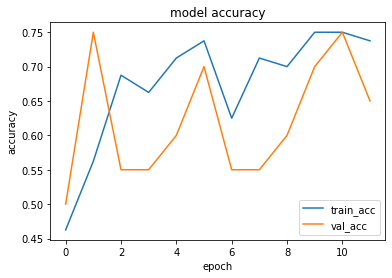

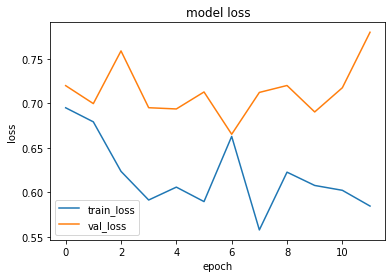

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.5001838]]


1it [00:00, 14122.24it/s]


prediction for video armflapping_3.mov is [[0.5049841]]


1it [00:00, 19878.22it/s]


prediction for video armflapping_2.mov is [[0.5237648]]


1it [00:00, 14979.66it/s]


prediction for video control_1.mov is [[0.48797953]]


1it [00:00, 14513.16it/s]


prediction for video control_2.mov is [[0.48420992]]


1it [00:00, 14074.85it/s]


prediction for video control_3.mov is [[0.4815692]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 1s 172ms/step - loss: 0.7062 - accuracy: 0.4750 - precision: 0.4839 - recall: 0.7500 - val_loss: 0.6788 - val_accuracy: 0.8000 - val_precision: 0.8750 - val_recall: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6963 - accuracy: 0.5375 - precision: 0.6154 - recall: 0.2000 - val_loss: 0.6672 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6761 - accuracy: 0.5625 - precision: 0.5397 - recall: 0.8500 - val_loss: 0.6796 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 129ms/step - loss: 0.6790 - accuracy: 0.5125 - precision: 0.5065 - recall: 0.9750 - val_loss: 0.6753 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 5/75
3

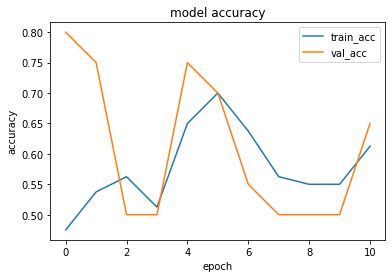

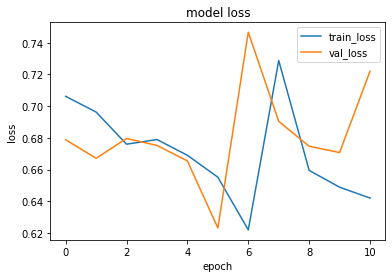

1it [00:00, 14716.86it/s]


prediction for video armflapping_1.mov is [[0.4944771]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.50397897]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.49943712]]


1it [00:00, 9157.87it/s]


prediction for video control_1.mov is [[0.4917624]]


1it [00:00, 16194.22it/s]


prediction for video control_2.mov is [[0.49057195]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.49067202]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 1s 163ms/step - loss: 0.6930 - accuracy: 0.4500 - precision: 0.4412 - recall: 0.3750 - val_loss: 0.6477 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6700 - accuracy: 0.5750 - precision: 0.5517 - recall: 0.8000 - val_loss: 0.6205 - val_accuracy: 0.5500 - val_precision: 0.5714 - val_recall: 0.4000
Epoch 3/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6418 - accuracy: 0.7875 - precision: 0.7949 - recall: 0.7750 - val_loss: 0.6100 - val_accuracy: 0.6000 - val_precision: 0.6667 - val_recall: 0.4000
Epoch 4/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6936 - accuracy: 0.7750 - precision: 0.8056 - recall: 0.7250 - val_loss: 1.1484 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000
Epoch 5/75


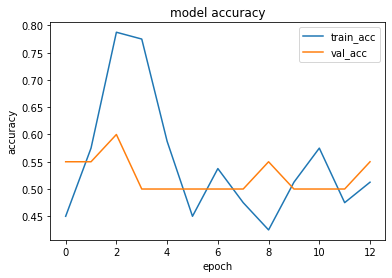

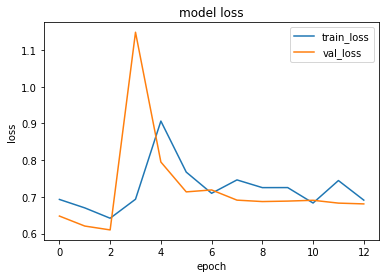

1it [00:00, 14513.16it/s]


prediction for video armflapping_1.mov is [[0.52229357]]


1it [00:00, 14873.42it/s]


prediction for video armflapping_3.mov is [[0.5158624]]


1it [00:00, 14979.66it/s]


prediction for video armflapping_2.mov is [[0.5263912]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.5213033]]


1it [00:00, 15827.56it/s]


prediction for video control_2.mov is [[0.52098835]]


1it [00:00, 16710.37it/s]


prediction for video control_3.mov is [[0.52097934]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 131ms/step - loss: 0.7026 - accuracy: 0.4250 - precision: 0.4211 - recall: 0.4000 - val_loss: 0.6799 - val_accuracy: 0.5500 - val_precision: 0.5294 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6862 - accuracy: 0.5250 - precision: 0.5132 - recall: 0.9750 - val_loss: 0.6914 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6720 - accuracy: 0.6375 - precision: 0.5902 - recall: 0.9000 - val_loss: 0.6811 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6624 - accuracy: 0.7125 - precision: 0.7429 - recall: 0.6500 - val_loss: 0.6750 - val_accuracy: 0.6500 - val_precision: 0.6667 - val_recall: 0.6000
Epoch 5/75


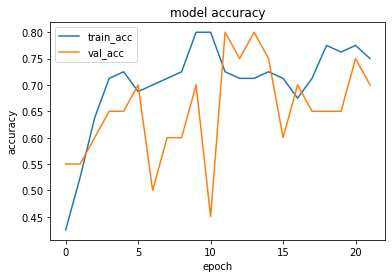

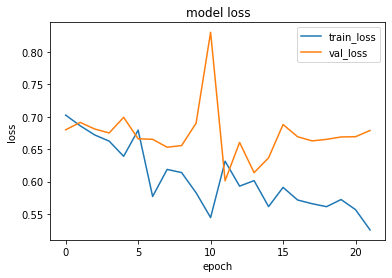

1it [00:00, 14768.68it/s]


prediction for video armflapping_1.mov is [[0.3512387]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.5422098]]


1it [00:00, 18157.16it/s]


prediction for video armflapping_2.mov is [[0.6389823]]


1it [00:00, 11781.75it/s]


prediction for video control_1.mov is [[0.28023624]]


1it [00:00, 19239.93it/s]


prediction for video control_2.mov is [[0.2638393]]


1it [00:00, 15650.39it/s]


prediction for video control_3.mov is [[0.26024985]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6960 - accuracy: 0.4500 - precision: 0.4286 - recall: 0.3000 - val_loss: 0.6299 - val_accuracy: 0.8500 - val_precision: 1.0000 - val_recall: 0.7000
Epoch 2/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6649 - accuracy: 0.6000 - precision: 0.5714 - recall: 0.8000 - val_loss: 0.5737 - val_accuracy: 0.6500 - val_precision: 0.5882 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6629 - accuracy: 0.6125 - precision: 0.5763 - recall: 0.8500 - val_loss: 0.5642 - val_accuracy: 0.8500 - val_precision: 1.0000 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6526 - accuracy: 0.6125 - precision: 0.6552 - recall: 0.4750 - val_loss: 0.6140 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 5/75


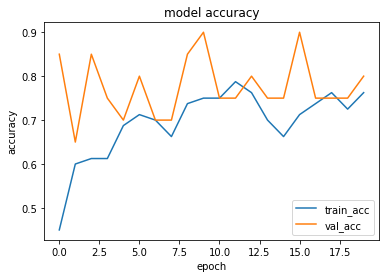

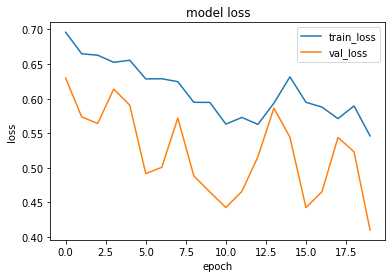

1it [00:00, 13934.56it/s]


prediction for video armflapping_1.mov is [[0.4547106]]


1it [00:00, 14315.03it/s]


prediction for video armflapping_3.mov is [[0.58121127]]


1it [00:00, 14463.12it/s]


prediction for video armflapping_2.mov is [[0.56184715]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.35285622]]


1it [00:00, 12985.46it/s]


prediction for video control_2.mov is [[0.33144498]]


1it [00:00, 12372.58it/s]


prediction for video control_3.mov is [[0.31249207]]


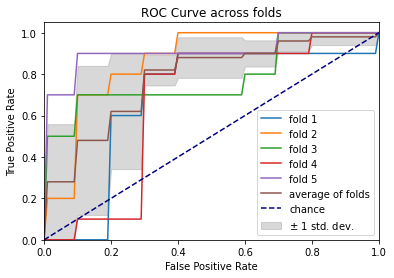

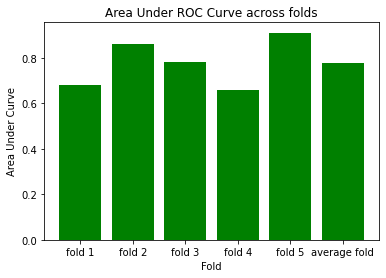

(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 172ms/step - loss: 0.6790 - accuracy: 0.5500 - precision: 0.5455 - recall: 0.6000 - val_loss: 0.9968 - val_accuracy: 0.4500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 169ms/step - loss: 0.7135 - accuracy: 0.5875 - precision: 0.5814 - recall: 0.6250 - val_loss: 0.6893 - val_accuracy: 0.4500 - val_precision: 0.4737 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 1s 169ms/step - loss: 0.6568 - accuracy: 0.5750 - precision: 0.5417 - recall: 0.9750 - val_loss: 0.6866 - val_accuracy: 0.4500 - val_precision: 0.4737 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 161ms/step - loss: 0.6676 - accuracy: 0.5750 - precision: 0.5417 - recall: 0.9750 - val_loss: 0.6739 - val_accuracy: 0.4500 - val_precision: 0.4737 - val_recall: 0.9000
Epoch 5/75
3/3 [==============================] - 0s 161

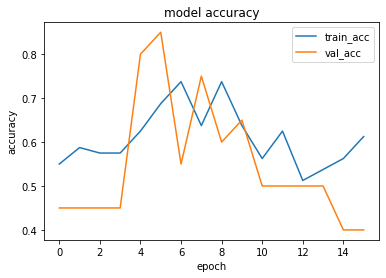

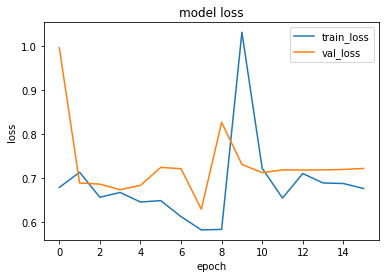

1it [00:00, 15196.75it/s]


prediction for video armflapping_1.mov is [[0.49276423]]


1it [00:00, 14665.40it/s]


prediction for video armflapping_3.mov is [[0.48971874]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_2.mov is [[0.51665354]]


1it [00:00, 3509.88it/s]


prediction for video control_1.mov is [[0.47930261]]


1it [00:00, 15650.39it/s]


prediction for video control_2.mov is [[0.47292686]]


1it [00:00, 14513.16it/s]


prediction for video control_3.mov is [[0.47042155]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 131ms/step - loss: 0.7009 - accuracy: 0.5250 - precision: 0.5455 - recall: 0.3000 - val_loss: 0.6685 - val_accuracy: 0.6000 - val_precision: 0.5556 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 123ms/step - loss: 0.6861 - accuracy: 0.5625 - precision: 0.5424 - recall: 0.8000 - val_loss: 0.6429 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6546 - accuracy: 0.7125 - precision: 0.7179 - recall: 0.7000 - val_loss: 0.5954 - val_accuracy: 0.7500 - val_precision: 0.7778 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6167 - accuracy: 0.7250 - precision: 0.7368 - recall: 0.7000 - val_loss: 0.5886 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 5/75


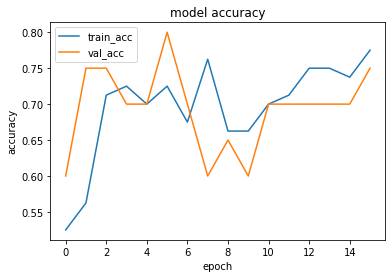

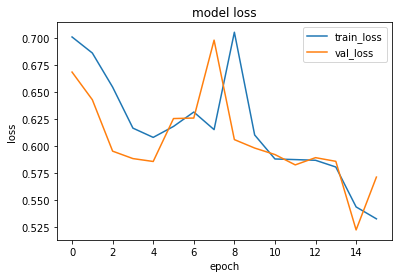

1it [00:00, 14926.35it/s]


prediction for video armflapping_1.mov is [[0.44189987]]


1it [00:00, 17549.39it/s]


prediction for video armflapping_3.mov is [[0.72783446]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_2.mov is [[0.7586571]]


1it [00:00, 14513.16it/s]


prediction for video control_1.mov is [[0.12758216]]


1it [00:00, 15363.75it/s]


prediction for video control_2.mov is [[0.11896443]]


1it [00:00, 16448.25it/s]


prediction for video control_3.mov is [[0.15106156]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 149ms/step - loss: 0.7032 - accuracy: 0.5250 - precision: 0.5143 - recall: 0.9000 - val_loss: 0.6830 - val_accuracy: 0.5500 - val_precision: 0.6000 - val_recall: 0.3000
Epoch 2/75
3/3 [==============================] - 0s 137ms/step - loss: 0.6879 - accuracy: 0.5500 - precision: 0.6250 - recall: 0.2500 - val_loss: 0.6797 - val_accuracy: 0.6000 - val_precision: 0.7500 - val_recall: 0.3000
Epoch 3/75
3/3 [==============================] - 1s 207ms/step - loss: 0.6696 - accuracy: 0.5500 - precision: 0.5417 - recall: 0.6500 - val_loss: 0.6799 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 130ms/step - loss: 0.6673 - accuracy: 0.5750 - precision: 0.5536 - recall: 0.7750 - val_loss: 0.6718 - val_accuracy: 0.7500 - val_precision: 0.7273 - val_recall: 0.8000
Epoch 5/75


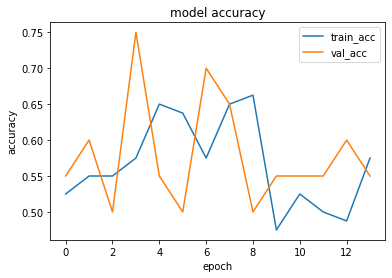

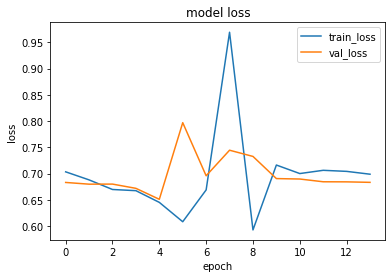

1it [00:00, 15650.39it/s]


prediction for video armflapping_1.mov is [[0.4599046]]


1it [00:00, 15363.75it/s]


prediction for video armflapping_3.mov is [[0.50572085]]


1it [00:00, 14716.86it/s]


prediction for video armflapping_2.mov is [[0.47207215]]


1it [00:00, 13486.51it/s]


prediction for video control_1.mov is [[0.45552725]]


1it [00:00, 14979.66it/s]


prediction for video control_2.mov is [[0.45470318]]


1it [00:00, 16070.13it/s]


prediction for video control_3.mov is [[0.45475775]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6761 - accuracy: 0.6500 - precision: 0.6429 - recall: 0.6750 - val_loss: 0.6785 - val_accuracy: 0.5500 - val_precision: 0.6667 - val_recall: 0.2000
Epoch 2/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6805 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.4750 - val_loss: 0.6552 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6381 - accuracy: 0.6750 - precision: 0.6458 - recall: 0.7750 - val_loss: 0.6319 - val_accuracy: 0.6500 - val_precision: 0.8000 - val_recall: 0.4000
Epoch 4/75
3/3 [==============================] - 0s 131ms/step - loss: 0.6211 - accuracy: 0.6250 - precision: 0.8125 - recall: 0.3250 - val_loss: 0.6431 - val_accuracy: 0.6000 - val_precision: 0.7500 - val_recall: 0.3000
Epoch 5/75


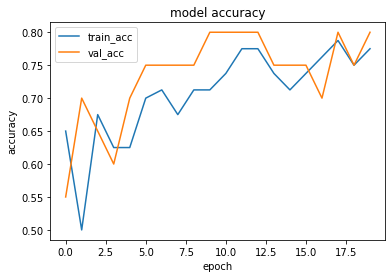

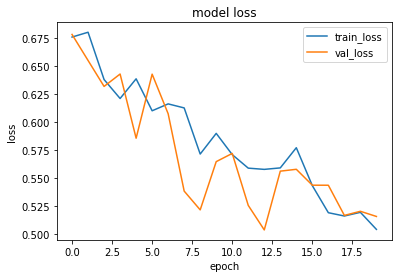

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.38115993]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_3.mov is [[0.6565729]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.61746955]]


1it [00:00, 14074.85it/s]


prediction for video control_1.mov is [[0.27216658]]


1it [00:00, 14665.40it/s]


prediction for video control_2.mov is [[0.24023262]]


1it [00:00, 13888.42it/s]


prediction for video control_3.mov is [[0.2395848]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 163ms/step - loss: 0.6846 - accuracy: 0.4750 - precision: 0.4808 - recall: 0.6250 - val_loss: 0.6970 - val_accuracy: 0.6500 - val_precision: 0.6154 - val_recall: 0.8000
Epoch 2/75
3/3 [==============================] - 1s 188ms/step - loss: 0.6849 - accuracy: 0.6000 - precision: 0.6429 - recall: 0.4500 - val_loss: 0.6494 - val_accuracy: 0.5500 - val_precision: 0.5556 - val_recall: 0.5000
Epoch 3/75
3/3 [==============================] - 1s 180ms/step - loss: 0.6421 - accuracy: 0.7125 - precision: 0.7576 - recall: 0.6250 - val_loss: 0.6584 - val_accuracy: 0.6500 - val_precision: 0.6364 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 149ms/step - loss: 0.6256 - accuracy: 0.7000 - precision: 0.7105 - recall: 0.6750 - val_loss: 0.5337 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 5/75
3

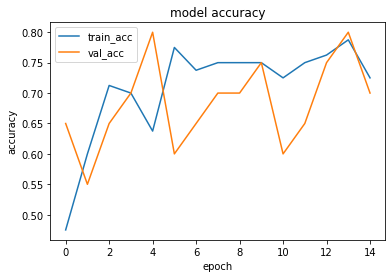

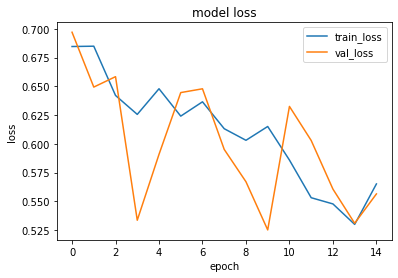

1it [00:00, 12826.62it/s]


prediction for video armflapping_1.mov is [[0.4560021]]


1it [00:00, 20068.44it/s]


prediction for video armflapping_3.mov is [[0.6743248]]


1it [00:00, 11491.24it/s]


prediction for video armflapping_2.mov is [[0.6039022]]


1it [00:00, 14979.66it/s]


prediction for video control_1.mov is [[0.19686264]]


1it [00:00, 14463.12it/s]


prediction for video control_2.mov is [[0.17536956]]


1it [00:00, 13530.01it/s]


prediction for video control_3.mov is [[0.21640229]]


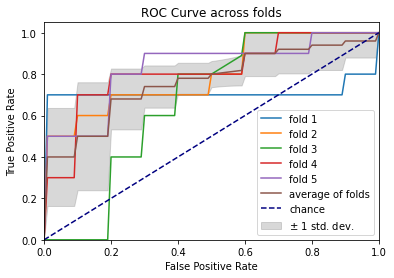

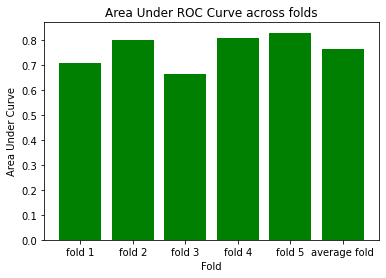

(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 155ms/step - loss: 0.6970 - accuracy: 0.4625 - precision: 0.3333 - recall: 0.0750 - val_loss: 0.6993 - val_accuracy: 0.6000 - val_precision: 0.5556 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6645 - accuracy: 0.5250 - precision: 0.5139 - recall: 0.9250 - val_loss: 0.5940 - val_accuracy: 0.8000 - val_precision: 0.8750 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6805 - accuracy: 0.7125 - precision: 0.7931 - recall: 0.5750 - val_loss: 0.6684 - val_accuracy: 0.6000 - val_precision: 0.5556 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 144ms/step - loss: 0.6626 - accuracy: 0.5750 - precision: 0.5405 - recall: 1.0000 - val_loss: 0.6559 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 5/75
3/3 [==============================] - 0s 144ms/step 

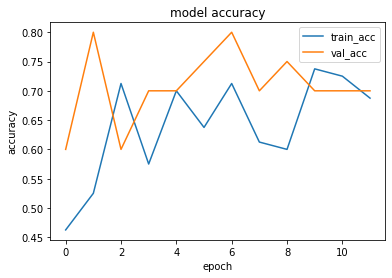

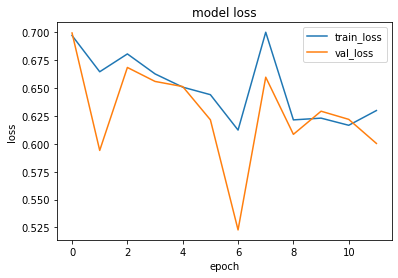

1it [00:00, 13706.88it/s]


prediction for video armflapping_1.mov is [[0.51413614]]


1it [00:00, 12192.74it/s]


prediction for video armflapping_3.mov is [[0.5127958]]


1it [00:00, 14122.24it/s]


prediction for video armflapping_2.mov is [[0.52739954]]


1it [00:00, 15887.52it/s]


prediction for video control_1.mov is [[0.49914503]]


1it [00:00, 16131.94it/s]


prediction for video control_2.mov is [[0.48993093]]


1it [00:00, 15887.52it/s]


prediction for video control_3.mov is [[0.4901328]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 136ms/step - loss: 0.6909 - accuracy: 0.4000 - precision: 0.3182 - recall: 0.1750 - val_loss: 0.6953 - val_accuracy: 0.4500 - val_precision: 0.4737 - val_recall: 0.9000
Epoch 2/75
3/3 [==============================] - 0s 187ms/step - loss: 0.6594 - accuracy: 0.6000 - precision: 0.5588 - recall: 0.9500 - val_loss: 0.7782 - val_accuracy: 0.5500 - val_precision: 0.5385 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 1s 195ms/step - loss: 0.6152 - accuracy: 0.7125 - precision: 0.6491 - recall: 0.9250 - val_loss: 0.6485 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 166ms/step - loss: 0.6879 - accuracy: 0.6750 - precision: 0.6842 - recall: 0.6500 - val_loss: 0.6514 - val_accuracy: 0.6000 - val_precision: 0.6000 - val_recall: 0.6000
Epoch 5/75
3

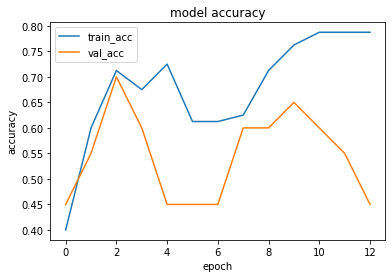

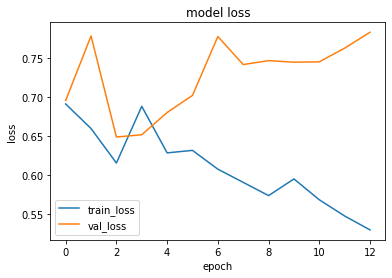

1it [00:00, 15420.24it/s]


prediction for video armflapping_1.mov is [[0.33708036]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_3.mov is [[0.5985143]]


1it [00:00, 15141.89it/s]


prediction for video armflapping_2.mov is [[0.6726937]]


1it [00:00, 14074.85it/s]


prediction for video control_1.mov is [[0.17681593]]


1it [00:00, 13934.56it/s]


prediction for video control_2.mov is [[0.16170675]]


1it [00:00, 13357.66it/s]


prediction for video control_3.mov is [[0.19891298]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 153ms/step - loss: 0.6845 - accuracy: 0.5375 - precision: 0.5349 - recall: 0.5750 - val_loss: 0.7075 - val_accuracy: 0.6000 - val_precision: 0.5556 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 187ms/step - loss: 0.6963 - accuracy: 0.5750 - precision: 0.5536 - recall: 0.7750 - val_loss: 0.6858 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 145ms/step - loss: 0.6921 - accuracy: 0.5125 - precision: 0.5063 - recall: 1.0000 - val_loss: 0.6797 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 150ms/step - loss: 0.6939 - accuracy: 0.5000 - precision: 0.5000 - recall: 0.9750 - val_loss: 0.6715 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 5/75


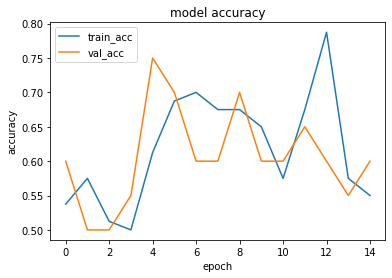

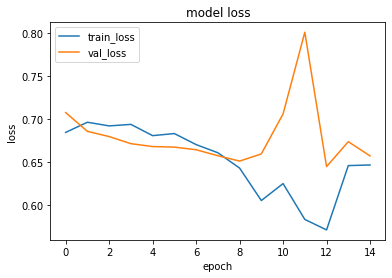

1it [00:00, 15363.75it/s]


prediction for video armflapping_1.mov is [[0.5439251]]


1it [00:00, 15827.56it/s]


prediction for video armflapping_3.mov is [[0.5684416]]


1it [00:00, 14513.16it/s]


prediction for video armflapping_2.mov is [[0.57590896]]


1it [00:00, 15592.21it/s]


prediction for video control_1.mov is [[0.519715]]


1it [00:00, 15141.89it/s]


prediction for video control_2.mov is [[0.50900334]]


1it [00:00, 15827.56it/s]


prediction for video control_3.mov is [[0.5075876]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 158ms/step - loss: 0.7258 - accuracy: 0.4875 - precision: 0.3333 - recall: 0.0250 - val_loss: 0.6907 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 1s 195ms/step - loss: 0.7279 - accuracy: 0.5000 - precision: 0.5000 - recall: 1.0000 - val_loss: 0.6948 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/75
3/3 [==============================] - 0s 132ms/step - loss: 0.6789 - accuracy: 0.6375 - precision: 0.5965 - recall: 0.8500 - val_loss: 0.6800 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 4/75
3/3 [==============================] - 0s 124ms/step - loss: 0.6765 - accuracy: 0.6625 - precision: 0.7241 - recall: 0.5250 - val_loss: 0.6655 - val_accuracy: 0.5500 - val_precision: 0.6667 - val_recall: 0.2000
Epoch 5/75
3

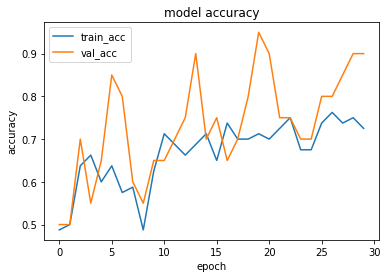

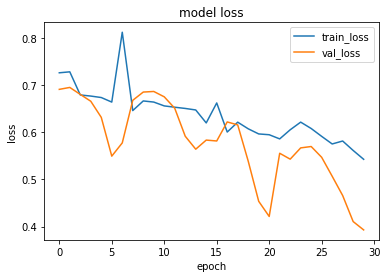

1it [00:00, 13706.88it/s]


prediction for video armflapping_1.mov is [[0.17538923]]


1it [00:00, 12052.60it/s]


prediction for video armflapping_3.mov is [[0.61891437]]


1it [00:00, 15650.39it/s]


prediction for video armflapping_2.mov is [[0.23911148]]


1it [00:00, 14513.16it/s]


prediction for video control_1.mov is [[0.16134357]]


1it [00:00, 14873.42it/s]


prediction for video control_2.mov is [[0.15751958]]


1it [00:00, 14873.42it/s]


prediction for video control_3.mov is [[0.15670735]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 131ms/step - loss: 0.7015 - accuracy: 0.4125 - precision: 0.4146 - recall: 0.4250 - val_loss: 0.6775 - val_accuracy: 0.5500 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 2/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6623 - accuracy: 0.6125 - precision: 0.5789 - recall: 0.8250 - val_loss: 0.6628 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.9000
Epoch 3/75
3/3 [==============================] - 0s 139ms/step - loss: 0.6435 - accuracy: 0.6250 - precision: 0.5833 - recall: 0.8750 - val_loss: 0.6656 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 4/75
3/3 [==============================] - 0s 141ms/step - loss: 0.6477 - accuracy: 0.6250 - precision: 0.5758 - recall: 0.9500 - val_loss: 0.6420 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 5/75


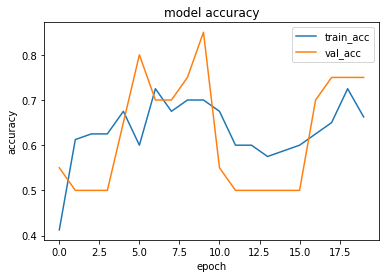

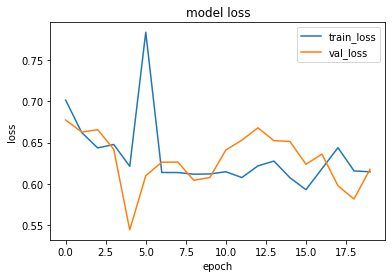

1it [00:00, 14463.12it/s]


prediction for video armflapping_1.mov is [[0.45289934]]


1it [00:00, 18236.10it/s]


prediction for video armflapping_3.mov is [[0.52791923]]


1it [00:00, 17189.77it/s]


prediction for video armflapping_2.mov is [[0.50576967]]


1it [00:00, 14716.86it/s]


prediction for video control_1.mov is [[0.42872798]]


1it [00:00, 14122.24it/s]


prediction for video control_2.mov is [[0.41740385]]


1it [00:00, 15650.39it/s]


prediction for video control_3.mov is [[0.41524386]]


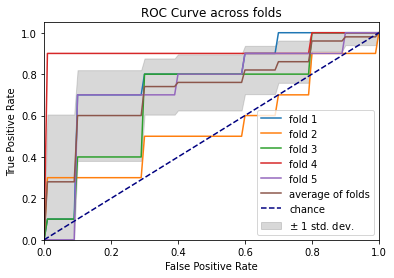

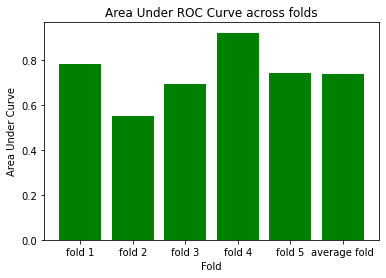

(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 168ms/step - loss: 0.6973 - accuracy: 0.5250 - precision: 0.5161 - recall: 0.8000 - val_loss: 0.6650 - val_accuracy: 0.6500 - val_precision: 0.8000 - val_recall: 0.4000
Epoch 2/75
3/3 [==============================] - 0s 122ms/step - loss: 0.6690 - accuracy: 0.5625 - precision: 0.6923 - recall: 0.2250 - val_loss: 0.6592 - val_accuracy: 0.7000 - val_precision: 0.7000 - val_recall: 0.7000
Epoch 3/75
3/3 [==============================] - 0s 127ms/step - loss: 0.6439 - accuracy: 0.6625 - precision: 0.6140 - recall: 0.8750 - val_loss: 0.6279 - val_accuracy: 0.6000 - val_precision: 0.5625 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 125ms/step - loss: 0.6303 - accuracy: 0.6125 - precision: 0.5714 - recall: 0.9000 - val_loss: 0.6193 - val_accuracy: 0.7000 - val_precision: 0.6667 - val_recall: 0.8000
Epoch 5/75
3/3 [==============================] - 0s 120ms/step 

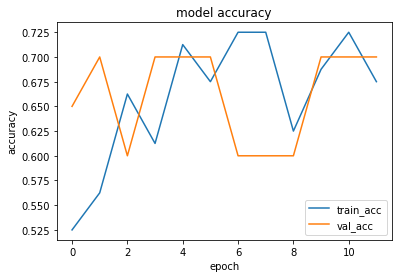

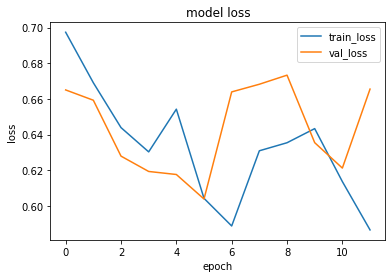

1it [00:00, 15141.89it/s]


prediction for video armflapping_1.mov is [[0.49772453]]


1it [00:00, 15420.24it/s]


prediction for video armflapping_3.mov is [[0.5144124]]


1it [00:00, 14926.35it/s]


prediction for video armflapping_2.mov is [[0.51561683]]


1it [00:00, 11335.96it/s]


prediction for video control_1.mov is [[0.48837113]]


1it [00:00, 14926.35it/s]


prediction for video control_2.mov is [[0.4850468]]


1it [00:00, 17476.27it/s]


prediction for video control_3.mov is [[0.48437378]]
(40, 90, 6) (40, 90, 6)
(10, 90, 6) (10, 90, 6)
Epoch 1/75
3/3 [==============================] - 0s 142ms/step - loss: 0.6911 - accuracy: 0.5750 - precision: 0.5652 - recall: 0.6500 - val_loss: 0.7296 - val_accuracy: 0.4000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/75
3/3 [==============================] - 0s 124ms/step - loss: 0.7488 - accuracy: 0.5250 - precision: 0.5294 - recall: 0.4500 - val_loss: 0.6940 - val_accuracy: 0.4500 - val_precision: 0.4706 - val_recall: 0.8000
Epoch 3/75
3/3 [==============================] - 0s 138ms/step - loss: 0.6733 - accuracy: 0.5750 - precision: 0.5405 - recall: 1.0000 - val_loss: 0.6791 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.9000
Epoch 4/75
3/3 [==============================] - 0s 140ms/step - loss: 0.6773 - accuracy: 0.5625 - precision: 0.5333 - recall: 1.0000 - val_loss: 0.6682 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.9000
Epo

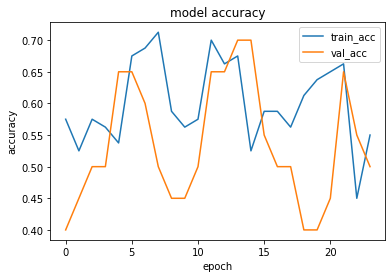

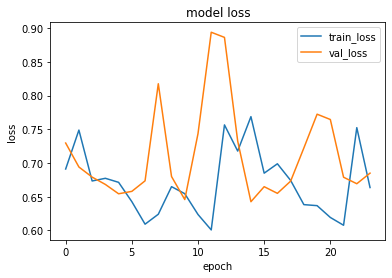

ZeroDivisionError: float division by zero

In [16]:
for seed in SEEDS:
    """ the only problem with this is that it's a basically 100 seed loop, which will take around 500 minutes of running"""
    np.random.seed(seed) # set seed 
    
    # first sort all of the folds 
    N = np.random.permutation(ARMFLAPPING_FRAMES.shape[0])
    ARMFLAPPING_FRAMES = ARMFLAPPING_FRAMES[N]
    CONTROL_FRAMES = CONTROL_FRAMES[N]

    # split them into 5 folds 
    ARMFLAPPING_FRAMES_SPLIT = np.array_split(ARMFLAPPING_FRAMES, 5)
    CONTROL_FRAMES_SPLIT = np.array_split(CONTROL_FRAMES, 5)

    # then run them 5x 
    checkpoint = tf.keras.callbacks.ModelCheckpoint("best.h5", save_best_only=True, monitor = "val_accuracy")
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience=10)
    cross_validate(make_model, epochs = 75, callbacks=[checkpoint, early_stopping]) 

In [45]:
with open("one_landmark_hundred_seeds_results", 'wb') as f: 
    pickle.dump((META_RESULT_MATRIX, AVERAGE_AUROCS, AVERAGE_TPRS), f)

In [47]:
import pickle, numpy as np
with open("one_landmark_hundred_seeds_results", 'rb') as f: 
 (META_RESULT_MATRIX, AVERAGE_AUROCS, AVERAGE_TPRS) = pickle.load(f)

In [48]:
META_RESULT_MATRIX = np.array(META_RESULT_MATRIX)
np.mean(META_RESULT_MATRIX, axis=0) # yoo the results for one hundred landmarks do be completely ass 

array([0.69155405, 0.70664611, 0.69121622, 0.68110828, 0.63513513,
       0.63908198, 0.62972973, 0.61179131])

In [49]:
for i in range(8): 
    print(np.mean(META_RESULT_MATRIX[:, i], axis=0), np.std(META_RESULT_MATRIX[:, i], axis=0))

0.6915540534096796 0.07857761828273378
0.7066461121713793 0.08523621538945772
0.6912162150885608 0.1801103443352474
0.6811082822124161 0.11083689035845078
0.6351351327187306 0.11322356653811351
0.6390819847583771 0.1358555647385105
0.6297297314614863 0.24369327153381146
0.6117913147331504 0.17048888832358136


In [52]:
METRICS = []
for fold_results in np.array_split(META_RESULT_MATRIX, 100):
    METRICS.append(np.mean(fold_results, axis = 0)) 

METRICS = np.around(np.array(METRICS), 10)
print(METRICS)

print(f"training accuracy : {np.mean(METRICS[:, 0])} +/- {np.std(METRICS[:, 0])}")
print(f"training precision : {np.mean(METRICS[:, 1])} +/- {np.std(METRICS[:, 1])}")
print(f"training recall : {np.mean(METRICS[:, 2])} +/- {np.std(METRICS[:, 2])}")
print(f"training f1 : {np.mean(METRICS[:, 3])} +/- {np.std(METRICS[:, 3])}")
print(f"validation accuracy : {np.mean(METRICS[:, 4])} +/- {np.std(METRICS[:, 4])}")
print(f"validation precision : {np.mean(METRICS[:, 5])} +/- {np.std(METRICS[:, 5])}")
print(f"validation recall : {np.mean(METRICS[:, 6])} +/- {np.std(METRICS[:, 6])}")
print(f"validation f1 : {np.mean(METRICS[:, 7])} +/- {np.std(METRICS[:, 7])}")

[[0.61250001 0.5633803  1.         0.72072074 0.69999999 0.625
  1.         0.76923077]
 [0.75       0.72727275 0.80000001 0.76190478 0.5        0.5
  0.30000001 0.37500001]
 [0.77499998 0.75       0.82499999 0.78571428 0.64999998 0.66666669
  0.60000002 0.63157897]
 [0.77499998 0.75       0.82499999 0.78571428 0.55000001 0.5714286
  0.40000001 0.47058825]
 [0.55000001 0.6111111  0.27500001 0.37931035 0.55000001 0.66666669
  0.2        0.30769231]
 [0.75       0.79411763 0.67500001 0.72972973 0.64999998 0.71428573
  0.5        0.5882353 ]
 [0.57499999 0.54285717 0.94999999 0.69090911 0.64999998 0.60000002
  0.89999998 0.72000001]
 [0.57499999 0.5714286  0.60000002 0.58536588 0.60000002 0.55555558
  1.         0.71428574]
 [0.77499998 0.77499998 0.77499998 0.77499998 0.80000001 0.875
  0.69999999 0.77777777]
 [0.77499998 0.78947371 0.75       0.76923078 0.75       0.77777779
  0.69999999 0.7368421 ]
 [0.75       0.79411763 0.67500001 0.72972973 0.64999998 0.63636363
  0.69999999 0.66666

In [14]:
# create plots of evreything 

training_acc = np.mean(META_RESULT_MATRIX[:, 0], axis=0)

labels = ['Accuracy', "Precision", "Recall", "F1"]

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(7, 6)
rects1 = ax.bar(x - width/2, [training_acc, training_precision, training_recall, training_f1], width, label='Training', color = "tab:blue")
rects2 = ax.bar(x + width/2, [validation_acc, validation_precision, validation_recall, validation_f1], width, label='Validation', color="tab:green")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Metric')
if FOLD_NUMBER != 5: 
    ax.set_title(f"Training vs. Testing Metrics: Fold {FOLD_NUMBER + 1} (No Aug)")
else: 
    ax.set_title("Training vs. Testing Metrics All Folds (No Aug)")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="upper right")

array([[0.80000001, 0.80000001, 0.80000001, 0.80000001, 0.60000002,
        0.60000002, 0.60000002, 0.60000002],
       [0.77499998, 0.76190478, 0.80000001, 0.78048782, 0.64999998,
        0.66666669, 0.60000002, 0.63157897],
       [0.75      , 0.72727275, 0.80000001, 0.76190478, 0.69999999,
        0.69999999, 0.69999999, 0.69999999],
       [0.85000002, 0.8888889 , 0.80000001, 0.84210527, 0.69999999,
        0.69999999, 0.69999999, 0.69999999],
       [0.72500002, 0.72500002, 0.72500002, 0.72500002, 0.85000002,
        0.81818181, 0.89999998, 0.85714284]])

0.7636873058008137


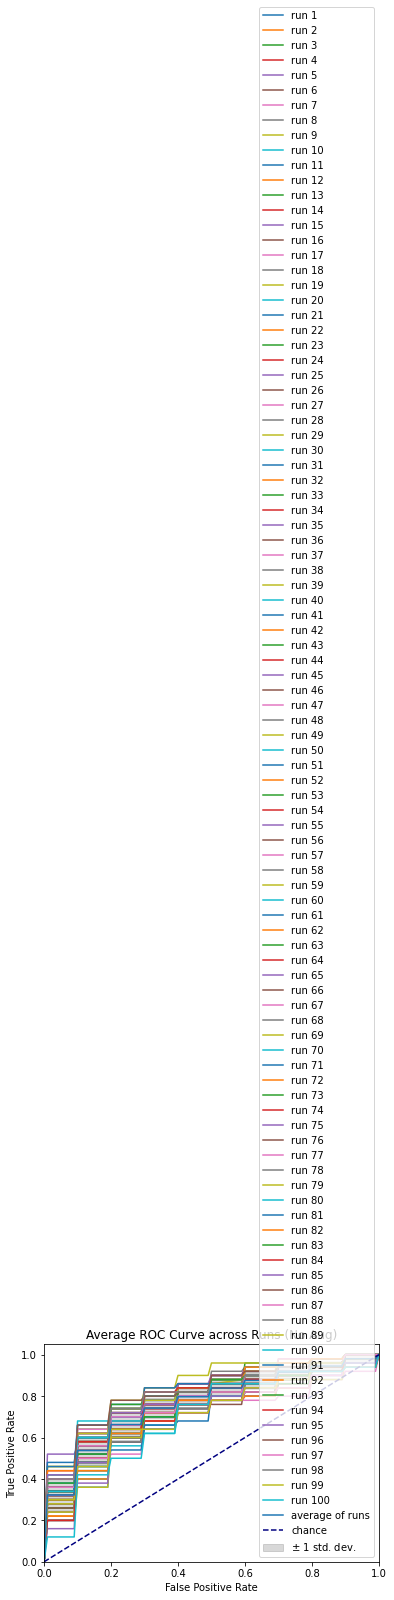

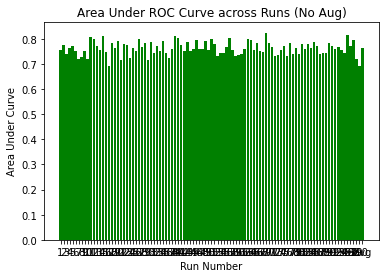

In [39]:
# REEE RUN THIS STUFF 
plot_meta_roc_auroc(AVERAGE_AUROCS, AVERAGE_TPRS, np.linspace(0, 1, 101)) # save the images here 

In [40]:
np.mean(AVERAGE_AUROCS), np.std(AVERAGE_AUROCS)

(0.76189, 0.026550118867552906)

In [41]:
def interpret(metrics_string):
     metrics = []
     for i in range(len(metrics_string)):
         try:
             index = metrics_string.index(":")
             metrics.append(metrics_string[index + 2 : index + 8])
             metrics_string = metrics_string[index + 9:]
         except Exception as e:
             return [float(m) for m in metrics][1:]

In [42]:
METRICS = [] # training acc, training pres, training recall, validation acc, validation pres, validation recall 

# for all of the 50 runs have a (50, 6 + 2) matrix, and then use that to store data and compute scores 
import numpy as np
meta_results = []
meta_results.append("3/3 [==============================] - 0s 143ms/step - loss: 0.5490 - accuracy: 0.7625 - precision_127: 0.7692 - recall_127: 0.7500 - val_loss: 0.6196 - val_accuracy: 0.7000 - val_precision_127: 0.6429 - val_recall_127: 0.9000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.5468 - accuracy: 0.7500 - precision_128: 0.7381 - recall_128: 0.7750 - val_loss: 0.4929 - val_accuracy: 0.7500 - val_precision_128: 0.7778 - val_recall_128: 0.7000")
meta_results.append("3/3 [==============================] - 0s 148ms/step - loss: 0.5195 - accuracy: 0.7875 - precision_129: 0.8485 - recall_129: 0.7000 - val_loss: 0.6768 - val_accuracy: 0.6500 - val_precision_129: 0.7143 - val_recall_129: 0.5000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.5528 - accuracy: 0.7375 - precision_130: 0.8800 - recall_130: 0.5500 - val_loss: 0.6188 - val_accuracy: 0.7000 - val_precision_130: 0.7500 - val_recall_130: 0.6000")
meta_results.append("3/3 [==============================] - 0s 136ms/step - loss: 0.5276 - accuracy: 0.7500 - precision_131: 0.7500 - recall_131: 0.7500 - val_loss: 0.5546 - val_accuracy: 0.7500 - val_precision_131: 0.7778 - val_recall_131: 0.7000")
meta_results.append("3/3 [==============================] - 0s 122ms/step - loss: 0.3641 - accuracy: 0.8250 - precision_133: 0.9333 - recall_133: 0.7000 - val_loss: 0.8364 - val_accuracy: 0.7000 - val_precision_133: 0.6429 - val_recall_133: 0.9000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.5302 - accuracy: 0.7750 - precision_134: 0.7750 - recall_134: 0.7750 - val_loss: 0.5209 - val_accuracy: 0.8000 - val_precision_134: 0.8000 - val_recall_134: 0.8000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.5198 - accuracy: 0.7375 - precision_135: 0.7209 - recall_135: 0.7750 - val_loss: 0.6696 - val_accuracy: 0.5500 - val_precision_135: 0.5714 - val_recall_135: 0.4000")
meta_results.append('3/3 [==============================] - 0s 142ms/step - loss: 0.5037 - accuracy: 0.7875 - precision_136: 0.8108 - recall_136: 0.7500 - val_loss: 0.5018 - val_accuracy: 0.7500 - val_precision_136: 0.7273 - val_recall_136: 0.8000')
meta_results.append("3/3 [==============================] - 0s 128ms/step - loss: 0.6638 - accuracy: 0.6000 - precision_137: 0.6053 - recall_137: 0.5750 - val_loss: 0.6271 - val_accuracy: 0.6000 - val_precision_137: 0.6250 - val_recall_137: 0.5000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.4704 - accuracy: 0.7875 - precision_139: 0.8485 - recall_139: 0.7000 - val_loss: 0.6656 - val_accuracy: 0.7000 - val_precision_139: 0.6667 - val_recall_139: 0.8000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.6160 - accuracy: 0.6500 - precision_140: 0.6875 - recall_140: 0.5500 - val_loss: 0.5326 - val_accuracy: 0.8500 - val_precision_140: 0.8182 - val_recall_140: 0.9000")
meta_results.append("3/3 [==============================] - 0s 134ms/step - loss: 0.4795 - accuracy: 0.7625 - precision_141: 0.7838 - recall_141: 0.7250 - val_loss: 0.7107 - val_accuracy: 0.6500 - val_precision_141: 0.8000 - val_recall_141: 0.4000")
meta_results.append("3/3 [==============================] - 0s 121ms/step - loss: 0.5433 - accuracy: 0.7375 - precision_142: 0.9130 - recall_142: 0.5250 - val_loss: 0.5958 - val_accuracy: 0.7000 - val_precision_142: 0.7000 - val_recall_142: 0.7000")
meta_results.append("3/3 [==============================] - 0s 181ms/step - loss: 0.4387 - accuracy: 0.8375 - precision_143: 0.9091 - recall_143: 0.7500 - val_loss: 0.8756 - val_accuracy: 0.7000 - val_precision_143: 0.6429 - val_recall_143: 0.9000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.5071 - accuracy: 0.7750 - precision_145: 0.8235 - recall_145: 0.7000 - val_loss: 0.6108 - val_accuracy: 0.7000 - val_precision_145: 0.6429 - val_recall_145: 0.9000")
meta_results.append("3/3 [==============================] - 0s 122ms/step - loss: 0.4103 - accuracy: 0.7875 - precision_146: 0.7674 - recall_146: 0.8250 - val_loss: 0.6352 - val_accuracy: 0.7500 - val_precision_146: 0.7273 - val_recall_146: 0.8000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.5201 - accuracy: 0.7375 - precision_147: 0.8065 - recall_147: 0.6250 - val_loss: 0.7552 - val_accuracy: 0.5500 - val_precision_147: 0.6000 - val_recall_147: 0.3000")
meta_results.append("3/3 [==============================] - 0s 127ms/step - loss: 0.4809 - accuracy: 0.7750 - precision_148: 0.7750 - recall_148: 0.7750 - val_loss: 0.5301 - val_accuracy: 0.7500 - val_precision_148: 0.7273 - val_recall_148: 0.8000")
meta_results.append("3/3 [==============================] - 0s 135ms/step - loss: 0.6238 - accuracy: 0.7250 - precision_149: 0.6957 - recall_149: 0.8000 - val_loss: 0.5609 - val_accuracy: 0.7000 - val_precision_149: 0.7500 - val_recall_149: 0.6000")
meta_results.append("3/3 [==============================] - 0s 147ms/step - loss: 0.4444 - accuracy: 0.8125 - precision_151: 0.8571 - recall_151: 0.7500 - val_loss: 0.6537 - val_accuracy: 0.7000 - val_precision_151: 0.6667 - val_recall_151: 0.8000")
meta_results.append("3/3 [==============================] - 0s 122ms/step - loss: 0.4550 - accuracy: 0.8000 - precision_152: 0.7500 - recall_152: 0.9000 - val_loss: 0.6105 - val_accuracy: 0.7500 - val_precision_152: 0.7778 - val_recall_152: 0.7000")
meta_results.append("3/3 [==============================] - 0s 126ms/step - loss: 0.4810 - accuracy: 0.7625 - precision_153: 0.8000 - recall_153: 0.7000 - val_loss: 0.6956 - val_accuracy: 0.6500 - val_precision_153: 0.7143 - val_recall_153: 0.5000")
meta_results.append("3/3 [==============================] - 0s 135ms/step - loss: 0.4951 - accuracy: 0.7625 - precision_154: 0.7692 - recall_154: 0.7500 - val_loss: 0.5621 - val_accuracy: 0.7500 - val_precision_154: 0.7273 - val_recall_154: 0.8000")
meta_results.append("3/3 [==============================] - 0s 127ms/step - loss: 0.4192 - accuracy: 0.8250 - precision_155: 0.8421 - recall_155: 0.8000 - val_loss: 0.5144 - val_accuracy: 0.7500 - val_precision_155: 0.7778 - val_recall_155: 0.7000")
meta_results.append("3/3 [==============================] - 0s 127ms/step - loss: 0.5146 - accuracy: 0.7375 - precision_157: 0.7568 - recall_157: 0.7000 - val_loss: 0.6470 - val_accuracy: 0.7000 - val_precision_157: 0.6429 - val_recall_157: 0.9000")
meta_results.append("3/3 [==============================] - 0s 136ms/step - loss: 0.5297 - accuracy: 0.7750 - precision_158: 0.7895 - recall_158: 0.7500 - val_loss: 0.5801 - val_accuracy: 0.7500 - val_precision_158: 0.7778 - val_recall_158: 0.7000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.4522 - accuracy: 0.7750 - precision_159: 0.8056 - recall_159: 0.7250 - val_loss: 0.6115 - val_accuracy: 0.6000 - val_precision_159: 0.7500 - val_recall_159: 0.3000")
meta_results.append("3/3 [==============================] - 0s 126ms/step - loss: 0.5559 - accuracy: 0.7250 - precision_160: 0.6957 - recall_160: 0.8000 - val_loss: 0.5596 - val_accuracy: 0.7000 - val_precision_160: 0.6667 - val_recall_160: 0.8000")
meta_results.append("3/3 [==============================] - 0s 175ms/step - loss: 0.5519 - accuracy: 0.7750 - precision_161: 0.8438 - recall_161: 0.6750 - val_loss: 0.5466 - val_accuracy: 0.6500 - val_precision_161: 0.7143 - val_recall_161: 0.5000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.4980 - accuracy: 0.7750 - precision_163: 0.8235 - recall_163: 0.7000 - val_loss: 0.6757 - val_accuracy: 0.6500 - val_precision_163: 0.6154 - val_recall_163: 0.8000")
meta_results.append("3/3 [==============================] - 0s 127ms/step - loss: 0.4898 - accuracy: 0.7750 - precision_164: 0.7895 - recall_164: 0.7500 - val_loss: 0.6056 - val_accuracy: 0.7000 - val_precision_164: 0.7000 - val_recall_164: 0.7000")
meta_results.append("3/3 [==============================] - 0s 181ms/step - loss: 0.5320 - accuracy: 0.7375 - precision_165: 0.7209 - recall_165: 0.7750 - val_loss: 0.7340 - val_accuracy: 0.6500 - val_precision_165: 0.6364 - val_recall_165: 0.7000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.4484 - accuracy: 0.7750 - precision_166: 0.7895 - recall_166: 0.7500 - val_loss: 0.5302 - val_accuracy: 0.7500 - val_precision_166: 0.7273 - val_recall_166: 0.8000")
meta_results.append("3/3 [==============================] - 0s 126ms/step - loss: 0.6792 - accuracy: 0.6750 - precision_167: 0.6522 - recall_167: 0.7500 - val_loss: 0.6917 - val_accuracy: 0.5500 - val_precision_167: 0.5556 - val_recall_167: 0.5000")
meta_results.append("3/3 [==============================] - 0s 128ms/step - loss: 0.4365 - accuracy: 0.8125 - precision_169: 0.8788 - recall_169: 0.7250 - val_loss: 0.7150 - val_accuracy: 0.6500 - val_precision_169: 0.6364 - val_recall_169: 0.7000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.5207 - accuracy: 0.7750 - precision_170: 0.7750 - recall_170: 0.7750 - val_loss: 0.5656 - val_accuracy: 0.7500 - val_precision_170: 0.7778 - val_recall_170: 0.7000")
meta_results.append("3/3 [==============================] - 0s 131ms/step - loss: 0.4846 - accuracy: 0.7625 - precision_171: 0.7692 - recall_171: 0.7500 - val_loss: 0.7023 - val_accuracy: 0.6500 - val_precision_171: 0.6667 - val_recall_171: 0.6000")
meta_results.append("3/3 [==============================] - 0s 129ms/step - loss: 0.4192 - accuracy: 0.8250 - precision_172: 0.8824 - recall_172: 0.7500 - val_loss: 0.8445 - val_accuracy: 0.7000 - val_precision_172: 0.7500 - val_recall_172: 0.6000")
meta_results.append("3/3 [==============================] - 0s 125ms/step - loss: 0.6846 - accuracy: 0.5750 - precision_173: 0.5682 - recall_173: 0.6250 - val_loss: 0.6460 - val_accuracy: 0.6000 - val_precision_173: 0.6250 - val_recall_173: 0.5000")
meta_results.append("3/3 [==============================] - 0s 122ms/step - loss: 0.4731 - accuracy: 0.7625 - precision_175: 0.7838 - recall_175: 0.7250 - val_loss: 0.6003 - val_accuracy: 0.7500 - val_precision_175: 0.6923 - val_recall_175: 0.9000")
meta_results.append("3/3 [==============================] - 0s 122ms/step - loss: 0.6343 - accuracy: 0.6875 - precision_176: 0.6744 - recall_176: 0.7250 - val_loss: 0.6167 - val_accuracy: 0.7000 - val_precision_176: 1.0000 - val_recall_176: 0.4000")
meta_results.append("3/3 [==============================] - 0s 126ms/step - loss: 0.6491 - accuracy: 0.5875 - precision_177: 0.6061 - recall_177: 0.5000 - val_loss: 0.6270 - val_accuracy: 0.6000 - val_precision_177: 1.0000 - val_recall_177: 0.2000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.4416 - accuracy: 0.8000 - precision_178: 0.8333 - recall_178: 0.7500 - val_loss: 0.6544 - val_accuracy: 0.6500 - val_precision_178: 0.7143 - val_recall_178: 0.5000")
meta_results.append("3/3 [==============================] - 0s 127ms/step - loss: 0.4658 - accuracy: 0.8125 - precision_179: 0.9032 - recall_179: 0.7000 - val_loss: 0.6116 - val_accuracy: 0.7500 - val_precision_179: 0.7778 - val_recall_179: 0.7000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.4735 - accuracy: 0.8000 - precision_181: 0.8750 - recall_181: 0.7000 - val_loss: 0.6479 - val_accuracy: 0.6500 - val_precision_181: 0.6667 - val_recall_181: 0.6000")
meta_results.append("3/3 [==============================] - 0s 153ms/step - loss: 0.5056 - accuracy: 0.7750 - precision_182: 0.7895 - recall_182: 0.7500 - val_loss: 0.4801 - val_accuracy: 0.7500 - val_precision_182: 0.7778 - val_recall_182: 0.7000")
meta_results.append("3/3 [==============================] - 0s 123ms/step - loss: 0.4631 - accuracy: 0.8000 - precision_183: 0.8000 - recall_183: 0.8000 - val_loss: 0.7841 - val_accuracy: 0.5000 - val_precision_183: 0.5000 - val_recall_183: 0.3000")
meta_results.append("3/3 [==============================] - 0s 129ms/step - loss: 0.4344 - accuracy: 0.8500 - precision_184: 0.8684 - recall_184: 0.8250 - val_loss: 0.6026 - val_accuracy: 0.7000 - val_precision_184: 0.6667 - val_recall_184: 0.8000")
meta_results.append("3/3 [==============================] - 0s 135ms/step - loss: 0.5167 - accuracy: 0.7375 - precision_185: 0.7111 - recall_185: 0.8000 - val_loss: 0.5716 - val_accuracy: 0.7000 - val_precision_185: 0.7500 - val_recall_185: 0.6000")

METRICS = [interpret(result) for result in meta_results]

In [43]:
METRICS = np.array(METRICS)

METRICS = np.delete(METRICS, obj=3, axis=1)
METRICS.shape

(50, 6)

In [44]:
train_acc = METRICS[:, 0]
train_pres = METRICS[:, 1]
train_recall = METRICS[:, 2]
val_acc = METRICS[:, 3]
val_pres = METRICS[:, 4]
val_recall = METRICS[:, 5]

print(f"training accuracy : {round(train_acc.mean(), 3)} ± {round(train_acc.std(), 3)}")
print(f"training precision : {round(train_pres.mean(), 3)} ± {round(train_pres.std(), 3)}")
print(f"training recall : {round(train_recall.mean(), 3)} ± {round(train_recall.std(), 3)}")
print(f"validation accuracy : {round(val_acc.mean(), 3)} ± {round(val_acc.std(), 3)}")
print(f"validation precision : {round(val_pres.mean(), 3)} ± {round(val_pres.std(), 3)}")
print(f"validation recall : {round(val_recall.mean(), 3)} ± {round(val_recall.std(), 3)}")


training accuracy : 0.759 ± 0.058
training precision : 0.785 ± 0.081
training recall : 0.725 ± 0.078
validation accuracy : 0.688 ± 0.068
validation precision : 0.711 ± 0.091
validation recall : 0.658 ± 0.181


In [45]:
def hmean(pres, recall):
    return 2 * pres * recall / (pres + recall)

train_f1 = hmean(train_pres, train_recall)
val_f1 = hmean(val_pres, val_recall)
print(f"training F1 : {round(train_f1.mean(), 3)} ± {round(train_f1.std(), 3)}")
print(f"validation F1 : {round(val_f1.mean(), 3)} ± {round(val_f1.std(), 3)}")

training F1 : 0.75 ± 0.06
validation F1 : 0.665 ± 0.115


In [46]:
METRICS_DICT = {i : [] for i in range(5)}

for i, metric in enumerate(METRICS): 
    METRICS_DICT[i % 5].append(metric)

for i, value in METRICS_DICT.items():
    METRICS_DICT[i] = np.array(METRICS_DICT[i])

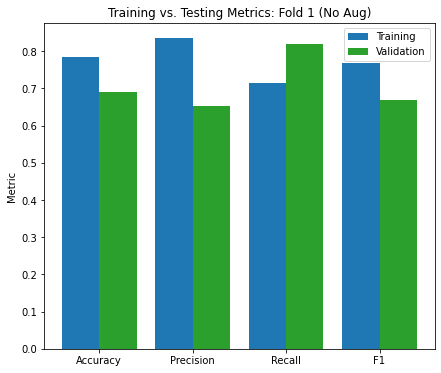

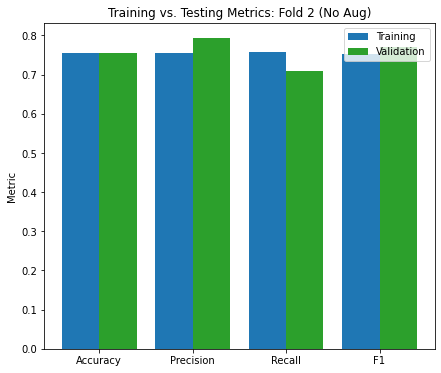

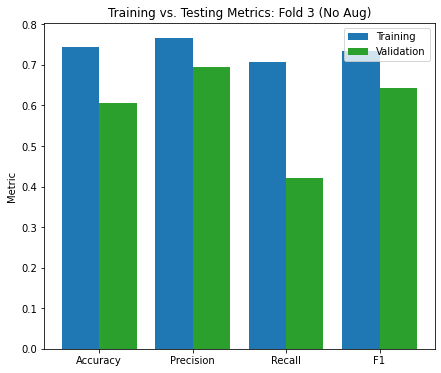

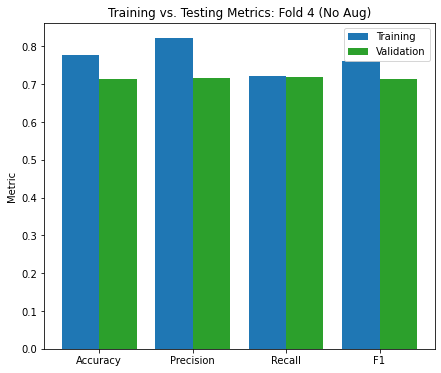

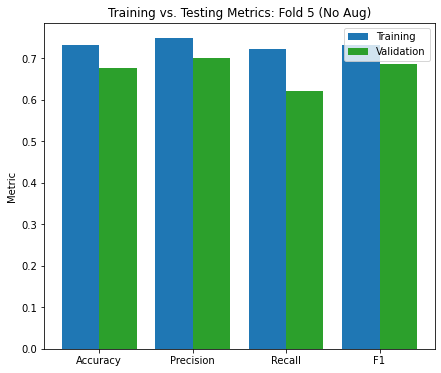

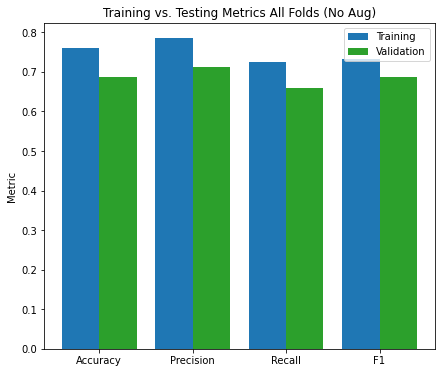

In [47]:
import matplotlib.pyplot as plt
import numpy as np

for FOLD_NUMBER in range(6): 
    
    if FOLD_NUMBER == 5: 
        training_acc = round(METRICS[:, 0].mean(), 3)
        training_precision = round(METRICS[:, 1].mean(), 3)
        training_recall = round(METRICS[:, 2].mean(), 3)
        validation_acc = round(METRICS[:, 3].mean(), 3)
        validation_precision = round(METRICS[:, 4].mean(), 3)
        validation_recall = round(METRICS[:, 5].mean(), 3)

        train_f1 = hmean(training_precision, train_recall)
        val_f1 = hmean(validation_precision, validation_recall)
    
    else : 
        metrics = METRICS_DICT[FOLD_NUMBER]
        training_acc = round(metrics[:, 0].mean(), 3)
        training_precision = round(metrics[:, 1].mean(), 3)
        training_recall = round(metrics[:, 2].mean(), 3)
        validation_acc = round(metrics[:, 3].mean(), 3)
        validation_precision = round(metrics[:, 4].mean(), 3)
        validation_recall = round(metrics[:, 5].mean(), 3)


        training_f1 = hmean(metrics[:, 1], metrics[:, 2]).mean()
        validation_f1 = hmean(metrics[:, 3], metrics[:, 4]).mean()

    labels = ['Accuracy', "Precision", "Recall", "F1"]

    x = np.arange(len(labels))  # the label locations
    width = 0.4  # the width of the bars

    fig, ax = plt.subplots()
    fig.set_size_inches(7, 6)
    rects1 = ax.bar(x - width/2, [training_acc, training_precision, training_recall, training_f1], width, label='Training', color = "tab:blue")
    rects2 = ax.bar(x + width/2, [validation_acc, validation_precision, validation_recall, validation_f1], width, label='Validation', color="tab:green")

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Metric')
    if FOLD_NUMBER != 5: 
        ax.set_title(f"Training vs. Testing Metrics: Fold {FOLD_NUMBER + 1} (No Aug)")
    else: 
        ax.set_title("Training vs. Testing Metrics All Folds (No Aug)")
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(loc="upper right")

    #ax.bar_label(rects1, padding=3)
    #ax.bar_label(rects2, padding=3)

    if FOLD_NUMBER != 5 : 
        plt.savefig(f"balanced_plots/train_vs_test_{FOLD_NUMBER + 1}_naug.png")

    else: 
        plt.savefig("balanced_plots/train_vs_test_all_naug.png")
    plt.show()